# 1 Vision Transformer

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import wandb 
import cv2
import torchvision
from PIL import Image
import math
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import torch.optim as optim
from tqdm import tqdm
import os
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1.1 Tasks

#### Scaled dot product attention block

In [2]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        # Calculate attention scores
        d_k = q.size(-1)
        attn_logits = torch.matmul(q, k.transpose(-2, -1))
        attn_logits = attn_logits / math.sqrt(d_k)
        
        # Apply mask if provided
        if mask is not None:
            attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
        
        # Apply softmax and dropout
        attention = F.softmax(attn_logits, dim=-1)
        attention = self.dropout(attention)
        
        # Calculate output
        output = torch.matmul(attention, v)
        return output, attention

#### Multi-headed attention block

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Linear projections
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        
        self.attention = ScaledDotProductAttention(dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        batch_size, seq_length, embed_dim = x.size()
        
        # Linear projections and reshape for multi-head attention
        q = self.q_proj(x).reshape(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.k_proj(x).reshape(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.v_proj(x).reshape(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        if mask is not None:
            mask = mask.unsqueeze(1)
        
        attn_output, attention = self.attention(q, k, v, mask)
        
        attn_output = attn_output.permute(0, 2, 1, 3).reshape(batch_size, seq_length, embed_dim)
        output = self.o_proj(attn_output)
        
        return output, attention

#### Incorporating dot product attention and multi-headed attentionblocks in the transformer encoder layer

In [4]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        
        #? First LayerNorm and Multi-Head Attention
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.dropout1 = nn.Dropout(dropout)
        
        #? Second LayerNorm and MLP
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x, mask=None):
        #? First sub-layer: Multi-head attention with residual connection
        y, attention = self.attention(self.norm1(x), mask)
        x = x + self.dropout1(y)
        
        #? Second sub-layer: MLP with residual connection
        x = x + self.mlp(self.norm2(x))
        
        return x, attention

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x, mask=None):
        attentions = []
        
        for layer in self.layers:
            x, attention = layer(x, mask)
            attentions.append(attention)
            
        return self.norm(x), attentions
    
class VisionTransformer(nn.Module):
    def __init__(self, image_size=32, patch_size=4, in_channels=3, num_classes=10, embed_dim=384, num_heads=6, mlp_dim=768, num_layers=6, dropout=0.0, emb_dropout=0.0, pos_embed_type='1d_learned', use_pos_embed=True):
        super().__init__()
        
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.embed_dim = embed_dim
        self.pos_embed_type = pos_embed_type
        self.use_pos_embed = use_pos_embed 
        
        self.patch_embedding = nn.Sequential(Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, embed_dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim)) #? Here we add the [CLS] token
        #? Here we add learnable Positional embedding (only if enabled)
        if use_pos_embed:
            if pos_embed_type == '1d_learned':
                self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
            elif pos_embed_type == '2d_learned':
                height = width = int(math.sqrt(self.num_patches))
                self.pos_embedding_2d = nn.Parameter(torch.randn(1, embed_dim, height, width))
                self.register_buffer('pos_embedding', None)
            elif pos_embed_type == 'sinusoidal':
                self.register_buffer('pos_embedding', self._create_sinusoidal_embedding())
            elif pos_embed_type == 'none':
                self.register_buffer('pos_embedding', torch.zeros(1, self.num_patches + 1, embed_dim))

        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = TransformerEncoder(embed_dim, num_heads, mlp_dim, num_layers, dropout)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        
    def _create_sinusoidal_embedding(self):
        position = torch.arange(self.num_patches + 1).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.embed_dim, 2) * -(math.log(10000.0) / self.embed_dim))
        
        pos_embed = torch.zeros(1, self.num_patches + 1, self.embed_dim)
        pos_embed[0, :, 0::2] = torch.sin(position * div_term)
        pos_embed[0, :, 1::2] = torch.cos(position * div_term)
        
        return pos_embed
        
    def _calculate_2d_positional_embedding(self, x):
        batch_size, _, embed_dim = x.shape
        height = width = int(math.sqrt(self.num_patches))
        
        #? Get the patch embeddings (all except CLS token)
        patch_embeddings = x[:, 1:, :]
        
        #? Reshape to 2D spatial layout
        patch_embeddings = patch_embeddings.reshape(batch_size, height, width, embed_dim)
        patch_embeddings = patch_embeddings.permute(0, 3, 1, 2)  # B, C, H, W
        
        #? Add 2D positional embedding
        pos_embed = self.pos_embedding_2d.expand(batch_size, -1, -1, -1)
        patch_embeddings = patch_embeddings + pos_embed
        
        #? Reshape back
        patch_embeddings = patch_embeddings.permute(0, 2, 3, 1)  # B, H, W, C
        patch_embeddings = patch_embeddings.reshape(batch_size, self.num_patches, embed_dim)
        
        #? Combine with CLS token
        cls_tokens = x[:, 0:1, :]
        x = torch.cat([cls_tokens, patch_embeddings], dim=1)
        
        return x
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embedding(x)
        
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)

        if self.use_pos_embed:
            if self.pos_embed_type == '1d_learned':
                x = x + self.pos_embedding
            elif self.pos_embed_type == '2d_learned':
                x = self._calculate_2d_positional_embedding(x)
            elif self.pos_embed_type in ['sinusoidal', 'none']:
                x = x + self.pos_embedding

        x = self.dropout(x)
        x, attentions = self.transformer(x)
        x = x[:, 0]
        x = self.mlp_head(x)
        
        return x, attentions
   

In [15]:

def get_dataloaders(batch_size=128, train_transform=None):
    if train_transform is not None:
        train_transform = train_transform
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        ])
    
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])
    
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, test_loader


def plot_loss_curves(train_losses, test_losses, train_accs, test_accs, title=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(train_losses) + 1)
    
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, test_losses, 'r-', label='Validation Loss')
    ax1.set_title(f'Training and Validation Loss {title}')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    ax2.plot(epochs, test_accs, 'r-', label='Validation Accuracy')
    ax2.set_title(f'Training and Validation Accuracy {title}')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    
    plt.tight_layout()
    return fig

In [6]:

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        progress_bar.set_postfix({
            'loss': running_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })
    
    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing")
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            progress_bar.set_postfix({
                'loss': running_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })
    
    return running_loss / len(test_loader), 100. * correct / total

def train_model(model, train_loader, test_loader, device, num_epochs, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        #? Save best model
        # if save_path and (epoch == 0 or test_acc > max(val_accs[:-1])):
        #     os.makedirs(os.path.dirname(save_path), exist_ok=True)
        #     torch.save({
        #         'epoch': epoch + 1,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'train_loss': train_loss,
        #         'test_loss': test_loss,
        #         'test_acc': test_acc,
        #         'config': config
        #     }, save_path)
        #     print(f"Model saved to {save_path}")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
    }

#### Training on CIFAR-10 dataset
For the initial experiments we use path size = 4

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                            std=[0.247, 0.243, 0.261]),
])

trainloader, testloader = get_dataloaders(train_transform=transform_train)

model = VisionTransformer(
        image_size=32, 
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=256,
        num_heads=8,
        mlp_dim=32,
        num_layers=8,
        dropout=0.1,  
        emb_dropout=0.1,
        use_pos_embed=True  
)
model = model.to(device)

results = train_model(model, trainloader, testloader, device, 50, learning_rate=1e-4)
# torch.save(model.state_dict(), f'checkpoints/visual_transformer.pth')



Epoch 1/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.19it/s, loss=1.73, acc=37.5]


Train Loss: 1.9390 | Train Acc: 28.52%
Val Loss: 1.7269 | Val Acc: 37.52%

Epoch 2/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.94it/s, loss=1.49, acc=47.5]


Train Loss: 1.6699 | Train Acc: 39.13%
Val Loss: 1.4856 | Val Acc: 47.51%

Epoch 3/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.05it/s, loss=1.4, acc=50.4] 


Train Loss: 1.5412 | Train Acc: 44.24%
Val Loss: 1.4033 | Val Acc: 50.37%

Epoch 4/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.97it/s, loss=1.33, acc=52.4]


Train Loss: 1.4753 | Train Acc: 46.70%
Val Loss: 1.3274 | Val Acc: 52.42%

Epoch 5/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.63it/s, loss=1.32, acc=52.8]


Train Loss: 1.4186 | Train Acc: 48.79%
Val Loss: 1.3233 | Val Acc: 52.80%

Epoch 6/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.81it/s, loss=1.26, acc=54.7]


Train Loss: 1.3778 | Train Acc: 50.29%
Val Loss: 1.2560 | Val Acc: 54.68%

Epoch 7/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.72it/s, loss=1.22, acc=56.5]


Train Loss: 1.3428 | Train Acc: 51.47%
Val Loss: 1.2201 | Val Acc: 56.53%

Epoch 8/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.96it/s, loss=1.21, acc=57]  


Train Loss: 1.3086 | Train Acc: 52.81%
Val Loss: 1.2087 | Val Acc: 56.95%

Epoch 9/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.56it/s, loss=1.15, acc=58.7]


Train Loss: 1.2811 | Train Acc: 54.14%
Val Loss: 1.1536 | Val Acc: 58.67%

Epoch 10/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.84it/s, loss=1.16, acc=58.9]


Train Loss: 1.2478 | Train Acc: 55.15%
Val Loss: 1.1618 | Val Acc: 58.92%

Epoch 11/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.88it/s, loss=1.13, acc=60.1]


Train Loss: 1.2223 | Train Acc: 56.05%
Val Loss: 1.1302 | Val Acc: 60.14%

Epoch 12/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.33it/s, loss=1.13, acc=59.9]


Train Loss: 1.1999 | Train Acc: 57.03%
Val Loss: 1.1270 | Val Acc: 59.92%

Epoch 13/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.37it/s, loss=1.08, acc=61.5]


Train Loss: 1.1796 | Train Acc: 57.63%
Val Loss: 1.0819 | Val Acc: 61.46%

Epoch 14/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.39it/s, loss=1.09, acc=61.7]


Train Loss: 1.1535 | Train Acc: 58.62%
Val Loss: 1.0890 | Val Acc: 61.67%

Epoch 15/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.14it/s, loss=1.08, acc=61.5]


Train Loss: 1.1378 | Train Acc: 59.38%
Val Loss: 1.0768 | Val Acc: 61.48%

Epoch 16/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.46it/s, loss=1.06, acc=62.1]


Train Loss: 1.1204 | Train Acc: 60.06%
Val Loss: 1.0603 | Val Acc: 62.08%

Epoch 17/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.46it/s, loss=1.03, acc=63]  


Train Loss: 1.1004 | Train Acc: 60.57%
Val Loss: 1.0343 | Val Acc: 62.99%

Epoch 18/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.09it/s, loss=1.04, acc=63.2]


Train Loss: 1.0856 | Train Acc: 61.27%
Val Loss: 1.0380 | Val Acc: 63.17%

Epoch 19/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.23it/s, loss=0.986, acc=64.8]


Train Loss: 1.0688 | Train Acc: 61.85%
Val Loss: 0.9855 | Val Acc: 64.78%

Epoch 20/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.42it/s, loss=0.988, acc=64.8]


Train Loss: 1.0556 | Train Acc: 62.21%
Val Loss: 0.9878 | Val Acc: 64.84%

Epoch 21/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.94it/s, loss=0.969, acc=65.8]


Train Loss: 1.0391 | Train Acc: 63.04%
Val Loss: 0.9686 | Val Acc: 65.75%

Epoch 22/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.42it/s, loss=0.941, acc=66.6]


Train Loss: 1.0240 | Train Acc: 63.58%
Val Loss: 0.9406 | Val Acc: 66.61%

Epoch 23/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.31it/s, loss=0.948, acc=66.5]


Train Loss: 1.0119 | Train Acc: 63.96%
Val Loss: 0.9476 | Val Acc: 66.50%

Epoch 24/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.45it/s, loss=0.957, acc=66.2]


Train Loss: 0.9950 | Train Acc: 64.66%
Val Loss: 0.9575 | Val Acc: 66.15%

Epoch 25/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.37it/s, loss=0.937, acc=66.5]


Train Loss: 0.9873 | Train Acc: 64.72%
Val Loss: 0.9369 | Val Acc: 66.55%

Epoch 26/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.45it/s, loss=0.915, acc=67.3]


Train Loss: 0.9676 | Train Acc: 65.64%
Val Loss: 0.9153 | Val Acc: 67.33%

Epoch 27/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.24it/s, loss=0.924, acc=68]  


Train Loss: 0.9646 | Train Acc: 65.94%
Val Loss: 0.9237 | Val Acc: 68.00%

Epoch 28/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.42it/s, loss=0.9, acc=68]    


Train Loss: 0.9477 | Train Acc: 66.21%
Val Loss: 0.8996 | Val Acc: 68.04%

Epoch 29/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.31it/s, loss=0.899, acc=68.6]


Train Loss: 0.9418 | Train Acc: 66.38%
Val Loss: 0.8990 | Val Acc: 68.59%

Epoch 30/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.50it/s, loss=0.897, acc=69]  


Train Loss: 0.9299 | Train Acc: 66.88%
Val Loss: 0.8970 | Val Acc: 69.04%

Epoch 31/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.40it/s, loss=0.884, acc=69.1]


Train Loss: 0.9194 | Train Acc: 67.29%
Val Loss: 0.8839 | Val Acc: 69.06%

Epoch 32/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.13it/s, loss=0.891, acc=68.4]


Train Loss: 0.9050 | Train Acc: 67.79%
Val Loss: 0.8906 | Val Acc: 68.38%

Epoch 33/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.10it/s, loss=0.862, acc=70]  


Train Loss: 0.9025 | Train Acc: 67.85%
Val Loss: 0.8616 | Val Acc: 70.00%

Epoch 34/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.36it/s, loss=0.878, acc=69.4]


Train Loss: 0.8842 | Train Acc: 68.65%
Val Loss: 0.8780 | Val Acc: 69.40%

Epoch 35/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.19it/s, loss=0.845, acc=71.1]


Train Loss: 0.8772 | Train Acc: 68.74%
Val Loss: 0.8449 | Val Acc: 71.07%

Epoch 36/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.25it/s, loss=0.844, acc=70.6]


Train Loss: 0.8702 | Train Acc: 69.12%
Val Loss: 0.8442 | Val Acc: 70.62%

Epoch 37/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.47it/s, loss=0.832, acc=71]  


Train Loss: 0.8606 | Train Acc: 69.55%
Val Loss: 0.8317 | Val Acc: 71.00%

Epoch 38/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.41it/s, loss=0.854, acc=70.2]


Train Loss: 0.8526 | Train Acc: 69.76%
Val Loss: 0.8540 | Val Acc: 70.24%

Epoch 39/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.45it/s, loss=0.832, acc=71]  


Train Loss: 0.8401 | Train Acc: 70.26%
Val Loss: 0.8323 | Val Acc: 70.99%

Epoch 40/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.73it/s, loss=0.837, acc=71.2]


Train Loss: 0.8422 | Train Acc: 69.98%
Val Loss: 0.8372 | Val Acc: 71.18%

Epoch 41/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.47it/s, loss=0.82, acc=71.5] 


Train Loss: 0.8311 | Train Acc: 70.50%
Val Loss: 0.8199 | Val Acc: 71.55%

Epoch 42/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.39it/s, loss=0.833, acc=71.3]


Train Loss: 0.8184 | Train Acc: 70.98%
Val Loss: 0.8331 | Val Acc: 71.30%

Epoch 43/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.38it/s, loss=0.797, acc=72.4]


Train Loss: 0.8091 | Train Acc: 71.12%
Val Loss: 0.7972 | Val Acc: 72.39%

Epoch 44/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.13it/s, loss=0.807, acc=72]  


Train Loss: 0.8059 | Train Acc: 71.43%
Val Loss: 0.8066 | Val Acc: 71.98%

Epoch 45/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.57it/s, loss=0.807, acc=72.4]


Train Loss: 0.8029 | Train Acc: 71.49%
Val Loss: 0.8072 | Val Acc: 72.37%

Epoch 46/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.32it/s, loss=0.791, acc=72.7]


Train Loss: 0.7944 | Train Acc: 71.70%
Val Loss: 0.7915 | Val Acc: 72.74%

Epoch 47/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.15it/s, loss=0.785, acc=73]  


Train Loss: 0.7852 | Train Acc: 72.11%
Val Loss: 0.7847 | Val Acc: 73.00%

Epoch 48/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.17it/s, loss=0.774, acc=73.2]


Train Loss: 0.7740 | Train Acc: 72.65%
Val Loss: 0.7745 | Val Acc: 73.25%

Epoch 49/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.24it/s, loss=0.781, acc=73.5]


Train Loss: 0.7703 | Train Acc: 72.60%
Val Loss: 0.7811 | Val Acc: 73.46%

Epoch 50/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.37it/s, loss=0.78, acc=73.3] 

Train Loss: 0.7708 | Train Acc: 72.82%
Val Loss: 0.7803 | Val Acc: 73.32%


Test Accuracy : 73.32


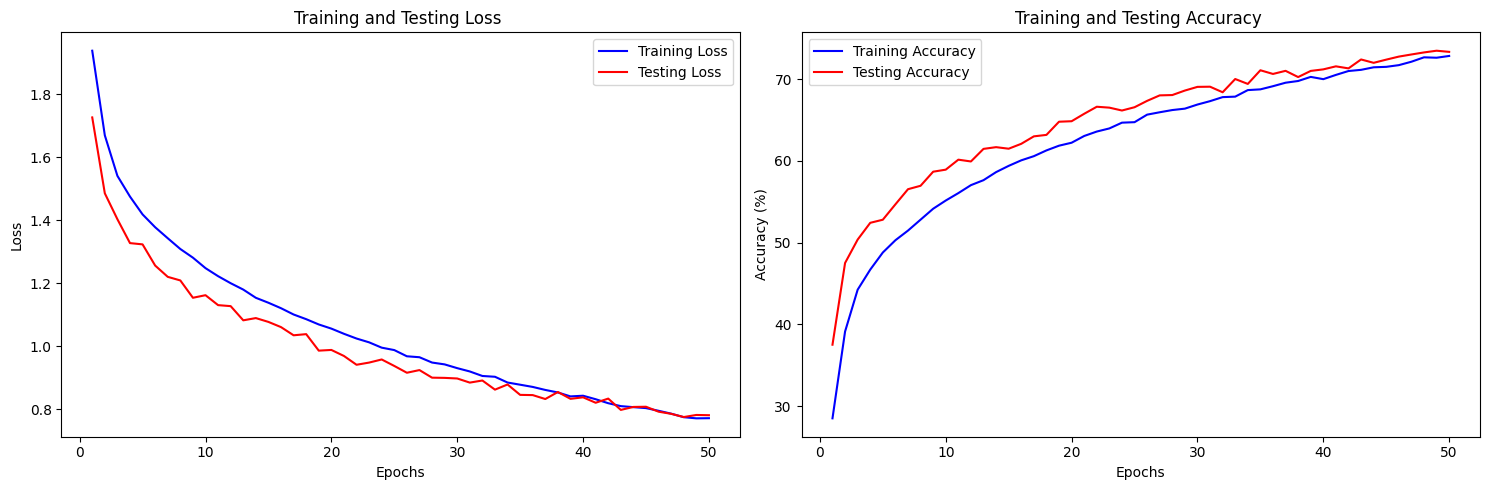

In [14]:
plot_loss_curves(results['train_losses'], results['test_losses'], results['train_accs'], results['test_accs'])
print(f"Test Accuracy : {results['test_accs'][-1]}")

## 1.2 Experiments

### 1. Patch Size Variation

#### Train and evaluate the model with patch sizes of 2, 4 (default), and 8.

In [6]:
NUM_EPOCHS=50
patch_sizes = [2, 4, 8]
results = []

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                            std=[0.247, 0.243, 0.261]),
])

trainloader, testloader = get_dataloaders(train_transform=transform_train)

We apply these consistent basic augmentations for the initial evaluations, which are kept constant across comparisons (here, path size) to ensure the model does not overfit at 50 epochs.

In [7]:
for patch_size in patch_sizes:
    print(f"Training with patch size: {patch_size}")
    model = VisionTransformer(patch_size=patch_size)
    model = model.to(device)
    result = train_model(model, trainloader, testloader, device, num_epochs=NUM_EPOCHS)
    results.append(result)

Training with patch size: 2

Epoch 1/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=1.61, acc=42.4]


Train Loss: 1.8666 | Train Acc: 31.42%
Val Loss: 1.6103 | Val Acc: 42.41%

Epoch 2/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=1.34, acc=51.9]


Train Loss: 1.5060 | Train Acc: 45.35%
Val Loss: 1.3409 | Val Acc: 51.86%

Epoch 3/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=1.26, acc=54.9]


Train Loss: 1.3517 | Train Acc: 50.79%
Val Loss: 1.2627 | Val Acc: 54.87%

Epoch 4/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s, loss=1.15, acc=58.9]


Train Loss: 1.2501 | Train Acc: 54.56%
Val Loss: 1.1500 | Val Acc: 58.88%

Epoch 5/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=1.12, acc=60]  


Train Loss: 1.1678 | Train Acc: 57.93%
Val Loss: 1.1162 | Val Acc: 60.01%

Epoch 6/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=1.08, acc=61.2]


Train Loss: 1.1024 | Train Acc: 60.32%
Val Loss: 1.0778 | Val Acc: 61.25%

Epoch 7/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=1.03, acc=62.9]


Train Loss: 1.0496 | Train Acc: 62.22%
Val Loss: 1.0318 | Val Acc: 62.91%

Epoch 8/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.979, acc=65.1]


Train Loss: 0.9992 | Train Acc: 64.33%
Val Loss: 0.9793 | Val Acc: 65.07%

Epoch 9/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.929, acc=66.6]


Train Loss: 0.9558 | Train Acc: 65.84%
Val Loss: 0.9285 | Val Acc: 66.60%

Epoch 10/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.884, acc=68.6]


Train Loss: 0.9268 | Train Acc: 66.83%
Val Loss: 0.8845 | Val Acc: 68.63%

Epoch 11/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.858, acc=69.5]


Train Loss: 0.8904 | Train Acc: 68.09%
Val Loss: 0.8579 | Val Acc: 69.51%

Epoch 12/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.862, acc=69.3]


Train Loss: 0.8592 | Train Acc: 69.22%
Val Loss: 0.8618 | Val Acc: 69.29%

Epoch 13/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.821, acc=70.9]


Train Loss: 0.8229 | Train Acc: 70.68%
Val Loss: 0.8212 | Val Acc: 70.89%

Epoch 14/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.819, acc=71.1]


Train Loss: 0.7980 | Train Acc: 71.61%
Val Loss: 0.8189 | Val Acc: 71.08%

Epoch 15/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.816, acc=71]  


Train Loss: 0.7685 | Train Acc: 72.65%
Val Loss: 0.8158 | Val Acc: 70.95%

Epoch 16/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.774, acc=73]  


Train Loss: 0.7465 | Train Acc: 73.30%
Val Loss: 0.7737 | Val Acc: 72.99%

Epoch 17/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.828, acc=70.7]


Train Loss: 0.7218 | Train Acc: 74.22%
Val Loss: 0.8281 | Val Acc: 70.68%

Epoch 18/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.775, acc=73.1]


Train Loss: 0.7029 | Train Acc: 74.98%
Val Loss: 0.7749 | Val Acc: 73.09%

Epoch 19/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.739, acc=73.8]


Train Loss: 0.6796 | Train Acc: 76.00%
Val Loss: 0.7387 | Val Acc: 73.76%

Epoch 20/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.738, acc=74.2]


Train Loss: 0.6600 | Train Acc: 76.60%
Val Loss: 0.7378 | Val Acc: 74.16%

Epoch 21/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.721, acc=74.4]


Train Loss: 0.6391 | Train Acc: 77.17%
Val Loss: 0.7213 | Val Acc: 74.44%

Epoch 22/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.726, acc=74.9]


Train Loss: 0.6236 | Train Acc: 77.67%
Val Loss: 0.7260 | Val Acc: 74.91%

Epoch 23/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.712, acc=75.4]


Train Loss: 0.5979 | Train Acc: 78.76%
Val Loss: 0.7118 | Val Acc: 75.38%

Epoch 24/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.707, acc=75.3]


Train Loss: 0.5796 | Train Acc: 79.07%
Val Loss: 0.7075 | Val Acc: 75.29%

Epoch 25/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s, loss=0.707, acc=75.8]


Train Loss: 0.5637 | Train Acc: 79.99%
Val Loss: 0.7065 | Val Acc: 75.81%

Epoch 26/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.675, acc=76.8]


Train Loss: 0.5457 | Train Acc: 80.45%
Val Loss: 0.6751 | Val Acc: 76.81%

Epoch 27/50


Testing: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s, loss=0.677, acc=76.8]


Train Loss: 0.5253 | Train Acc: 81.23%
Val Loss: 0.6770 | Val Acc: 76.82%

Epoch 28/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.683, acc=76.2]


Train Loss: 0.5124 | Train Acc: 81.79%
Val Loss: 0.6829 | Val Acc: 76.20%

Epoch 29/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.67, acc=77.4] 


Train Loss: 0.4871 | Train Acc: 82.61%
Val Loss: 0.6702 | Val Acc: 77.40%

Epoch 30/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.672, acc=77.5]


Train Loss: 0.4703 | Train Acc: 83.25%
Val Loss: 0.6724 | Val Acc: 77.49%

Epoch 31/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.68, acc=77.5] 


Train Loss: 0.4528 | Train Acc: 83.88%
Val Loss: 0.6803 | Val Acc: 77.47%

Epoch 32/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.656, acc=77.9]


Train Loss: 0.4403 | Train Acc: 84.27%
Val Loss: 0.6563 | Val Acc: 77.86%

Epoch 33/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.684, acc=77.1]


Train Loss: 0.4197 | Train Acc: 84.84%
Val Loss: 0.6840 | Val Acc: 77.07%

Epoch 34/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.657, acc=78]  


Train Loss: 0.3962 | Train Acc: 85.98%
Val Loss: 0.6574 | Val Acc: 77.95%

Epoch 35/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.685, acc=77.7]


Train Loss: 0.3860 | Train Acc: 86.13%
Val Loss: 0.6849 | Val Acc: 77.66%

Epoch 36/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.714, acc=76.7]


Train Loss: 0.3685 | Train Acc: 86.88%
Val Loss: 0.7139 | Val Acc: 76.74%

Epoch 37/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.682, acc=77.6]


Train Loss: 0.3535 | Train Acc: 87.37%
Val Loss: 0.6824 | Val Acc: 77.58%

Epoch 38/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.733, acc=76.7]


Train Loss: 0.3358 | Train Acc: 88.02%
Val Loss: 0.7328 | Val Acc: 76.67%

Epoch 39/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.729, acc=76.9]


Train Loss: 0.3175 | Train Acc: 88.62%
Val Loss: 0.7290 | Val Acc: 76.86%

Epoch 40/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.709, acc=77.8]


Train Loss: 0.3053 | Train Acc: 89.00%
Val Loss: 0.7093 | Val Acc: 77.79%

Epoch 41/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.712, acc=77.8]


Train Loss: 0.2857 | Train Acc: 89.73%
Val Loss: 0.7122 | Val Acc: 77.76%

Epoch 42/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.722, acc=77.4]


Train Loss: 0.2707 | Train Acc: 90.34%
Val Loss: 0.7221 | Val Acc: 77.36%

Epoch 43/50


Testing: 100%|██████████| 79/79 [00:15<00:00,  5.27it/s, loss=0.744, acc=77.4]


Train Loss: 0.2560 | Train Acc: 90.78%
Val Loss: 0.7443 | Val Acc: 77.36%

Epoch 44/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s, loss=0.756, acc=77.7]


Train Loss: 0.2478 | Train Acc: 91.14%
Val Loss: 0.7561 | Val Acc: 77.69%

Epoch 45/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.772, acc=77.4]


Train Loss: 0.2310 | Train Acc: 91.66%
Val Loss: 0.7724 | Val Acc: 77.39%

Epoch 46/50


Testing: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s, loss=0.788, acc=77.5]


Train Loss: 0.2221 | Train Acc: 91.95%
Val Loss: 0.7876 | Val Acc: 77.53%

Epoch 47/50


Testing: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s, loss=0.777, acc=77.5]


Train Loss: 0.2097 | Train Acc: 92.48%
Val Loss: 0.7768 | Val Acc: 77.54%

Epoch 48/50


Testing: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s, loss=0.799, acc=77.6]


Train Loss: 0.1925 | Train Acc: 93.15%
Val Loss: 0.7988 | Val Acc: 77.56%

Epoch 49/50


Testing: 100%|██████████| 79/79 [00:15<00:00,  5.27it/s, loss=0.821, acc=77.3]


Train Loss: 0.1849 | Train Acc: 93.51%
Val Loss: 0.8212 | Val Acc: 77.31%

Epoch 50/50


Testing: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s, loss=0.795, acc=77.7]


Train Loss: 0.1806 | Train Acc: 93.51%
Val Loss: 0.7950 | Val Acc: 77.69%
Training with patch size: 4

Epoch 1/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.62it/s, loss=1.52, acc=44.7]


Train Loss: 1.7792 | Train Acc: 34.90%
Val Loss: 1.5248 | Val Acc: 44.66%

Epoch 2/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.66it/s, loss=1.34, acc=51.9]


Train Loss: 1.4663 | Train Acc: 47.15%
Val Loss: 1.3415 | Val Acc: 51.91%

Epoch 3/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.78it/s, loss=1.25, acc=55.2]


Train Loss: 1.3406 | Train Acc: 51.76%
Val Loss: 1.2473 | Val Acc: 55.23%

Epoch 4/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.78it/s, loss=1.2, acc=56.8] 


Train Loss: 1.2592 | Train Acc: 54.85%
Val Loss: 1.1957 | Val Acc: 56.82%

Epoch 5/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.68it/s, loss=1.1, acc=60.8] 


Train Loss: 1.1968 | Train Acc: 57.05%
Val Loss: 1.0983 | Val Acc: 60.81%

Epoch 6/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.60it/s, loss=1.11, acc=60.1]


Train Loss: 1.1345 | Train Acc: 59.35%
Val Loss: 1.1144 | Val Acc: 60.08%

Epoch 7/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.46it/s, loss=1.05, acc=62.9]


Train Loss: 1.0895 | Train Acc: 61.00%
Val Loss: 1.0501 | Val Acc: 62.91%

Epoch 8/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.63it/s, loss=0.997, acc=64.1]


Train Loss: 1.0411 | Train Acc: 62.85%
Val Loss: 0.9966 | Val Acc: 64.10%

Epoch 9/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.57it/s, loss=0.971, acc=65.5]


Train Loss: 1.0111 | Train Acc: 63.80%
Val Loss: 0.9712 | Val Acc: 65.46%

Epoch 10/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.58it/s, loss=0.934, acc=66.7]


Train Loss: 0.9649 | Train Acc: 65.54%
Val Loss: 0.9344 | Val Acc: 66.68%

Epoch 11/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.61it/s, loss=0.918, acc=67.4]


Train Loss: 0.9339 | Train Acc: 66.96%
Val Loss: 0.9179 | Val Acc: 67.40%

Epoch 12/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.51it/s, loss=0.89, acc=68.2] 


Train Loss: 0.9066 | Train Acc: 67.75%
Val Loss: 0.8905 | Val Acc: 68.15%

Epoch 13/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.59it/s, loss=0.933, acc=66.9]


Train Loss: 0.8644 | Train Acc: 69.18%
Val Loss: 0.9335 | Val Acc: 66.86%

Epoch 14/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.61it/s, loss=0.837, acc=70.5]


Train Loss: 0.8392 | Train Acc: 70.04%
Val Loss: 0.8369 | Val Acc: 70.51%

Epoch 15/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.56it/s, loss=0.831, acc=70.7]


Train Loss: 0.8126 | Train Acc: 71.03%
Val Loss: 0.8311 | Val Acc: 70.67%

Epoch 16/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.53it/s, loss=0.828, acc=70.7]


Train Loss: 0.7861 | Train Acc: 71.92%
Val Loss: 0.8276 | Val Acc: 70.68%

Epoch 17/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.59it/s, loss=0.801, acc=71.7]


Train Loss: 0.7626 | Train Acc: 72.98%
Val Loss: 0.8007 | Val Acc: 71.65%

Epoch 18/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.55it/s, loss=0.791, acc=71.9]


Train Loss: 0.7365 | Train Acc: 73.86%
Val Loss: 0.7909 | Val Acc: 71.88%

Epoch 19/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.58it/s, loss=0.774, acc=72.9]


Train Loss: 0.7111 | Train Acc: 74.66%
Val Loss: 0.7741 | Val Acc: 72.87%

Epoch 20/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.59it/s, loss=0.76, acc=73]   


Train Loss: 0.6930 | Train Acc: 75.42%
Val Loss: 0.7598 | Val Acc: 72.98%

Epoch 21/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.60it/s, loss=0.75, acc=74.1] 


Train Loss: 0.6669 | Train Acc: 76.34%
Val Loss: 0.7497 | Val Acc: 74.14%

Epoch 22/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.59it/s, loss=0.741, acc=73.8]


Train Loss: 0.6477 | Train Acc: 76.97%
Val Loss: 0.7409 | Val Acc: 73.84%

Epoch 23/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.63it/s, loss=0.721, acc=74.7]


Train Loss: 0.6352 | Train Acc: 77.23%
Val Loss: 0.7211 | Val Acc: 74.72%

Epoch 24/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.58it/s, loss=0.715, acc=75.2]


Train Loss: 0.6111 | Train Acc: 78.33%
Val Loss: 0.7145 | Val Acc: 75.22%

Epoch 25/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.54it/s, loss=0.7, acc=75.5]  


Train Loss: 0.5973 | Train Acc: 78.90%
Val Loss: 0.7002 | Val Acc: 75.50%

Epoch 26/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.64it/s, loss=0.716, acc=75.1]


Train Loss: 0.5713 | Train Acc: 79.62%
Val Loss: 0.7161 | Val Acc: 75.10%

Epoch 27/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.54it/s, loss=0.711, acc=75.5]


Train Loss: 0.5592 | Train Acc: 80.03%
Val Loss: 0.7115 | Val Acc: 75.48%

Epoch 28/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.55it/s, loss=0.698, acc=75.6]


Train Loss: 0.5415 | Train Acc: 80.63%
Val Loss: 0.6983 | Val Acc: 75.62%

Epoch 29/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.59it/s, loss=0.683, acc=76.2]


Train Loss: 0.5205 | Train Acc: 81.53%
Val Loss: 0.6835 | Val Acc: 76.23%

Epoch 30/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.47it/s, loss=0.696, acc=76.1]


Train Loss: 0.5039 | Train Acc: 81.97%
Val Loss: 0.6956 | Val Acc: 76.06%

Epoch 31/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.77it/s, loss=0.722, acc=75.3]


Train Loss: 0.4872 | Train Acc: 82.48%
Val Loss: 0.7225 | Val Acc: 75.32%

Epoch 32/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.68it/s, loss=0.693, acc=76.8]


Train Loss: 0.4707 | Train Acc: 83.20%
Val Loss: 0.6927 | Val Acc: 76.78%

Epoch 33/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.64it/s, loss=0.667, acc=76.7]


Train Loss: 0.4509 | Train Acc: 83.97%
Val Loss: 0.6665 | Val Acc: 76.72%

Epoch 34/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.65it/s, loss=0.701, acc=76.5]


Train Loss: 0.4313 | Train Acc: 84.66%
Val Loss: 0.7007 | Val Acc: 76.54%

Epoch 35/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.66it/s, loss=0.682, acc=77.5]


Train Loss: 0.4206 | Train Acc: 84.88%
Val Loss: 0.6817 | Val Acc: 77.46%

Epoch 36/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.67it/s, loss=0.684, acc=77.5]


Train Loss: 0.3980 | Train Acc: 85.60%
Val Loss: 0.6844 | Val Acc: 77.46%

Epoch 37/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.58it/s, loss=0.686, acc=77.6]


Train Loss: 0.3853 | Train Acc: 86.16%
Val Loss: 0.6857 | Val Acc: 77.62%

Epoch 38/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.63it/s, loss=0.69, acc=77.9] 


Train Loss: 0.3700 | Train Acc: 86.78%
Val Loss: 0.6903 | Val Acc: 77.90%

Epoch 39/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.72it/s, loss=0.685, acc=77.8]


Train Loss: 0.3514 | Train Acc: 87.49%
Val Loss: 0.6848 | Val Acc: 77.79%

Epoch 40/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.56it/s, loss=0.69, acc=78]   


Train Loss: 0.3375 | Train Acc: 87.77%
Val Loss: 0.6903 | Val Acc: 77.95%

Epoch 41/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.56it/s, loss=0.68, acc=78.1] 


Train Loss: 0.3203 | Train Acc: 88.47%
Val Loss: 0.6796 | Val Acc: 78.08%

Epoch 42/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.66it/s, loss=0.698, acc=78.1]


Train Loss: 0.3082 | Train Acc: 88.86%
Val Loss: 0.6977 | Val Acc: 78.11%

Epoch 43/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.59it/s, loss=0.705, acc=78.2]


Train Loss: 0.2965 | Train Acc: 89.24%
Val Loss: 0.7054 | Val Acc: 78.15%

Epoch 44/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.66it/s, loss=0.724, acc=78.1]


Train Loss: 0.2785 | Train Acc: 90.04%
Val Loss: 0.7235 | Val Acc: 78.06%

Epoch 45/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.67it/s, loss=0.716, acc=78.3]


Train Loss: 0.2645 | Train Acc: 90.66%
Val Loss: 0.7165 | Val Acc: 78.29%

Epoch 46/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.54it/s, loss=0.715, acc=78.4]


Train Loss: 0.2539 | Train Acc: 90.83%
Val Loss: 0.7154 | Val Acc: 78.40%

Epoch 47/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.51it/s, loss=0.711, acc=78.8]


Train Loss: 0.2452 | Train Acc: 91.11%
Val Loss: 0.7113 | Val Acc: 78.77%

Epoch 48/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.55it/s, loss=0.737, acc=78.4]


Train Loss: 0.2291 | Train Acc: 91.93%
Val Loss: 0.7369 | Val Acc: 78.42%

Epoch 49/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.48it/s, loss=0.733, acc=78.7]


Train Loss: 0.2172 | Train Acc: 92.13%
Val Loss: 0.7329 | Val Acc: 78.67%

Epoch 50/50


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.44it/s, loss=0.759, acc=78.1]


Train Loss: 0.2077 | Train Acc: 92.63%
Val Loss: 0.7589 | Val Acc: 78.10%
Training with patch size: 8

Epoch 1/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 79.75it/s, loss=1.51, acc=46.1]


Train Loss: 1.7952 | Train Acc: 33.86%
Val Loss: 1.5104 | Val Acc: 46.11%

Epoch 2/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 78.26it/s, loss=1.42, acc=49.5]


Train Loss: 1.5204 | Train Acc: 44.74%
Val Loss: 1.4235 | Val Acc: 49.53%

Epoch 3/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.07it/s, loss=1.34, acc=51.4]


Train Loss: 1.4170 | Train Acc: 48.76%
Val Loss: 1.3432 | Val Acc: 51.38%

Epoch 4/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.04it/s, loss=1.27, acc=54.5]


Train Loss: 1.3533 | Train Acc: 50.91%
Val Loss: 1.2700 | Val Acc: 54.51%

Epoch 5/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.18it/s, loss=1.25, acc=56]  


Train Loss: 1.2980 | Train Acc: 52.91%
Val Loss: 1.2451 | Val Acc: 55.97%

Epoch 6/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.13it/s, loss=1.21, acc=56.2]


Train Loss: 1.2543 | Train Acc: 54.53%
Val Loss: 1.2093 | Val Acc: 56.23%

Epoch 7/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.34it/s, loss=1.18, acc=58]  


Train Loss: 1.2201 | Train Acc: 56.12%
Val Loss: 1.1768 | Val Acc: 57.96%

Epoch 8/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.84it/s, loss=1.15, acc=58.5]


Train Loss: 1.1885 | Train Acc: 57.56%
Val Loss: 1.1532 | Val Acc: 58.45%

Epoch 9/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.81it/s, loss=1.14, acc=59.6]


Train Loss: 1.1540 | Train Acc: 58.56%
Val Loss: 1.1352 | Val Acc: 59.65%

Epoch 10/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.76it/s, loss=1.15, acc=58.8]


Train Loss: 1.1329 | Train Acc: 59.41%
Val Loss: 1.1529 | Val Acc: 58.81%

Epoch 11/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.89it/s, loss=1.08, acc=61.1]


Train Loss: 1.1061 | Train Acc: 60.36%
Val Loss: 1.0825 | Val Acc: 61.07%

Epoch 12/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 79.29it/s, loss=1.08, acc=61.5]


Train Loss: 1.0813 | Train Acc: 61.31%
Val Loss: 1.0813 | Val Acc: 61.51%

Epoch 13/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.53it/s, loss=1.06, acc=62.2]


Train Loss: 1.0582 | Train Acc: 62.11%
Val Loss: 1.0648 | Val Acc: 62.16%

Epoch 14/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.38it/s, loss=1.03, acc=63.1]


Train Loss: 1.0382 | Train Acc: 62.98%
Val Loss: 1.0320 | Val Acc: 63.08%

Epoch 15/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.91it/s, loss=1.02, acc=63.5]


Train Loss: 1.0174 | Train Acc: 63.95%
Val Loss: 1.0245 | Val Acc: 63.54%

Epoch 16/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.66it/s, loss=1.01, acc=64]   


Train Loss: 0.9957 | Train Acc: 64.35%
Val Loss: 1.0120 | Val Acc: 63.96%

Epoch 17/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.70it/s, loss=1.01, acc=63.9] 


Train Loss: 0.9745 | Train Acc: 65.47%
Val Loss: 1.0093 | Val Acc: 63.90%

Epoch 18/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.18it/s, loss=0.995, acc=65]  


Train Loss: 0.9529 | Train Acc: 66.04%
Val Loss: 0.9946 | Val Acc: 65.00%

Epoch 19/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.29it/s, loss=0.988, acc=64.6]


Train Loss: 0.9370 | Train Acc: 66.44%
Val Loss: 0.9882 | Val Acc: 64.56%

Epoch 20/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.23it/s, loss=0.952, acc=66.6]


Train Loss: 0.9135 | Train Acc: 67.42%
Val Loss: 0.9515 | Val Acc: 66.63%

Epoch 21/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.13it/s, loss=0.933, acc=66.7]


Train Loss: 0.9002 | Train Acc: 67.97%
Val Loss: 0.9334 | Val Acc: 66.71%

Epoch 22/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.47it/s, loss=0.928, acc=67]  


Train Loss: 0.8761 | Train Acc: 68.61%
Val Loss: 0.9276 | Val Acc: 67.02%

Epoch 23/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.32it/s, loss=0.924, acc=66.8]


Train Loss: 0.8673 | Train Acc: 68.98%
Val Loss: 0.9245 | Val Acc: 66.82%

Epoch 24/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.13it/s, loss=0.947, acc=66.4]


Train Loss: 0.8465 | Train Acc: 69.84%
Val Loss: 0.9467 | Val Acc: 66.42%

Epoch 25/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.29it/s, loss=0.909, acc=68.1]


Train Loss: 0.8277 | Train Acc: 70.47%
Val Loss: 0.9090 | Val Acc: 68.06%

Epoch 26/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.08it/s, loss=0.894, acc=68.2]


Train Loss: 0.8110 | Train Acc: 71.02%
Val Loss: 0.8935 | Val Acc: 68.20%

Epoch 27/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.21it/s, loss=0.872, acc=68.7]


Train Loss: 0.7945 | Train Acc: 71.70%
Val Loss: 0.8717 | Val Acc: 68.74%

Epoch 28/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.05it/s, loss=0.867, acc=69.3]


Train Loss: 0.7784 | Train Acc: 72.21%
Val Loss: 0.8671 | Val Acc: 69.29%

Epoch 29/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.34it/s, loss=0.846, acc=70.1]


Train Loss: 0.7611 | Train Acc: 72.70%
Val Loss: 0.8456 | Val Acc: 70.07%

Epoch 30/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.46it/s, loss=0.884, acc=69.6]


Train Loss: 0.7446 | Train Acc: 73.64%
Val Loss: 0.8845 | Val Acc: 69.63%

Epoch 31/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.62it/s, loss=0.842, acc=70.2]


Train Loss: 0.7291 | Train Acc: 73.96%
Val Loss: 0.8417 | Val Acc: 70.22%

Epoch 32/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.41it/s, loss=0.838, acc=70.6]


Train Loss: 0.7097 | Train Acc: 74.79%
Val Loss: 0.8383 | Val Acc: 70.57%

Epoch 33/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.82it/s, loss=0.831, acc=70.7]


Train Loss: 0.6945 | Train Acc: 75.34%
Val Loss: 0.8310 | Val Acc: 70.68%

Epoch 34/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.12it/s, loss=0.833, acc=70.5]


Train Loss: 0.6819 | Train Acc: 75.80%
Val Loss: 0.8325 | Val Acc: 70.51%

Epoch 35/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 79.04it/s, loss=0.816, acc=71.4]


Train Loss: 0.6636 | Train Acc: 76.28%
Val Loss: 0.8163 | Val Acc: 71.40%

Epoch 36/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.39it/s, loss=0.832, acc=70.8]


Train Loss: 0.6554 | Train Acc: 76.79%
Val Loss: 0.8321 | Val Acc: 70.81%

Epoch 37/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 79.73it/s, loss=0.813, acc=71.4]


Train Loss: 0.6382 | Train Acc: 77.29%
Val Loss: 0.8129 | Val Acc: 71.43%

Epoch 38/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.58it/s, loss=0.799, acc=72.5]


Train Loss: 0.6243 | Train Acc: 77.88%
Val Loss: 0.7992 | Val Acc: 72.52%

Epoch 39/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.68it/s, loss=0.784, acc=72.8]


Train Loss: 0.6098 | Train Acc: 78.39%
Val Loss: 0.7844 | Val Acc: 72.80%

Epoch 40/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 81.08it/s, loss=0.812, acc=72]  


Train Loss: 0.5959 | Train Acc: 78.75%
Val Loss: 0.8122 | Val Acc: 72.02%

Epoch 41/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 79.68it/s, loss=0.804, acc=72.7]


Train Loss: 0.5807 | Train Acc: 79.29%
Val Loss: 0.8043 | Val Acc: 72.66%

Epoch 42/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 78.31it/s, loss=0.786, acc=72.8]


Train Loss: 0.5701 | Train Acc: 79.90%
Val Loss: 0.7855 | Val Acc: 72.85%

Epoch 43/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.36it/s, loss=0.782, acc=73]  


Train Loss: 0.5538 | Train Acc: 80.45%
Val Loss: 0.7818 | Val Acc: 73.00%

Epoch 44/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 78.85it/s, loss=0.781, acc=73.3]


Train Loss: 0.5429 | Train Acc: 80.63%
Val Loss: 0.7809 | Val Acc: 73.35%

Epoch 45/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 78.87it/s, loss=0.777, acc=73.8]


Train Loss: 0.5261 | Train Acc: 81.07%
Val Loss: 0.7773 | Val Acc: 73.76%

Epoch 46/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 79.63it/s, loss=0.771, acc=74]  


Train Loss: 0.5120 | Train Acc: 81.61%
Val Loss: 0.7713 | Val Acc: 74.02%

Epoch 47/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 78.66it/s, loss=0.778, acc=73.9]


Train Loss: 0.5071 | Train Acc: 81.73%
Val Loss: 0.7782 | Val Acc: 73.89%

Epoch 48/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.99it/s, loss=0.766, acc=74.6]


Train Loss: 0.4827 | Train Acc: 82.79%
Val Loss: 0.7663 | Val Acc: 74.58%

Epoch 49/50


Testing: 100%|██████████| 79/79 [00:01<00:00, 78.42it/s, loss=0.794, acc=74]  


Train Loss: 0.4716 | Train Acc: 82.97%
Val Loss: 0.7937 | Val Acc: 74.03%

Epoch 50/50


Testing: 100%|██████████| 79/79 [00:00<00:00, 80.04it/s, loss=0.783, acc=74]  

Train Loss: 0.4596 | Train Acc: 83.59%
Val Loss: 0.7829 | Val Acc: 74.00%


In [8]:
print(f"Test Accuracy for patch sizes {patch_sizes}: {[result['test_accs'][-1] for result in results]}")
print(results)

Test Accuracy for patch sizes [2, 4, 8]: [77.69, 78.1, 74.0]
[{'train_losses': [1.86656725924948, 1.5060389325441912, 1.3517241758458756, 1.2500533647549428, 1.1677729728276773, 1.1023959756812172, 1.0495506480831625, 0.9991565349766666, 0.9558312405100868, 0.9267905788958225, 0.8903932641534245, 0.8591593380474374, 0.8229403693962585, 0.7979880470753936, 0.7685274175365867, 0.7465127811712378, 0.7218057347075714, 0.7028601488951222, 0.6796426173213803, 0.6599573816942133, 0.6391210246573934, 0.6236472055125419, 0.5979399494350414, 0.5796049434663085, 0.5636849937688969, 0.5456759946425552, 0.5252891056372991, 0.5124091694269644, 0.48706871362598353, 0.4702830882480992, 0.4527605101275627, 0.4402542353209937, 0.4197145150902936, 0.39623350202275054, 0.38599152138928317, 0.3684576202155379, 0.3535329709806101, 0.33581887940159233, 0.3174615642222602, 0.3053443077046548, 0.2856937864095049, 0.2707209241054857, 0.2560108855481038, 0.24775738667344194, 0.23100918729591857, 0.22208544044086

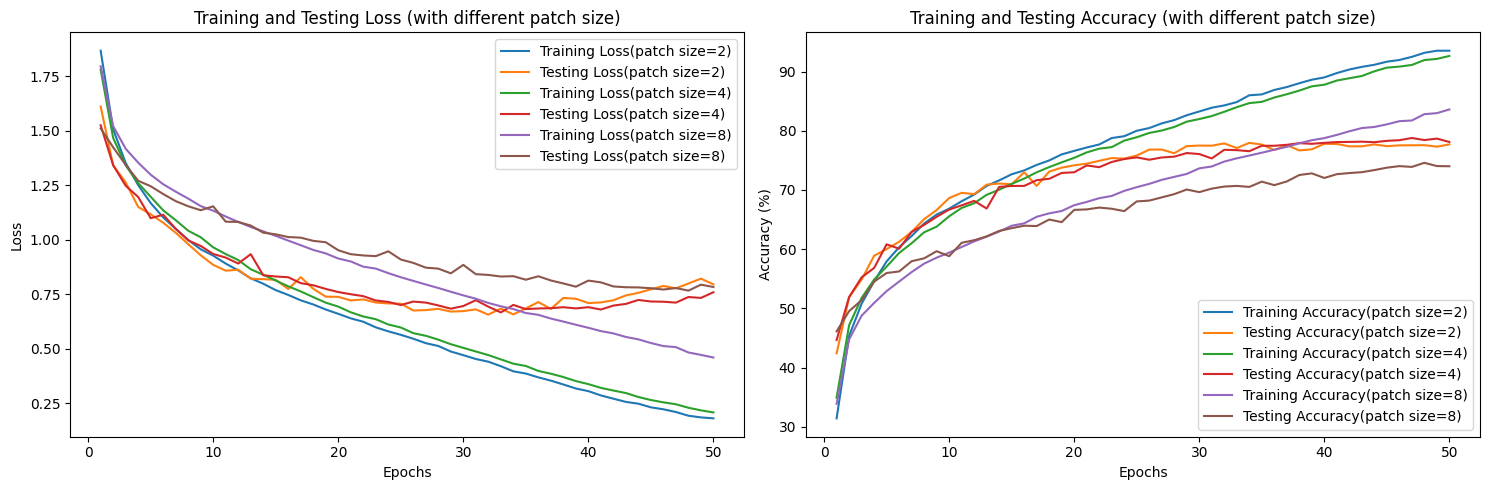

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(results[0]['train_losses']) + 1)

# Loss plot
for result, patch_size in zip(results, patch_sizes):
    ax1.plot(epochs, result['train_losses'], label=f'Training Loss(patch size={patch_size})')
    ax1.plot(epochs, result['test_losses'], label=f'Testing Loss(patch size={patch_size})')

ax1.set_title(f'Training and Testing Loss (with different patch size)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy plot
for result, patch_size in zip(results, patch_sizes):
    ax2.plot(epochs, result['train_accs'], label=f'Training Accuracy(patch size={patch_size})')
    ax2.plot(epochs, result['test_accs'], label=f'Testing Accuracy(patch size={patch_size})')

ax2.set_title(f'Training and Testing Accuracy (with different patch size)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.tight_layout()
plt.show()

In [8]:
def get_dataloaders(batch_size=128,
                    train_transform=None,
                    val_split=0.1,
                    num_workers=4,
                    pin_memory=True,
                    random_seed=42):
    # -------------------
    # Transforms
    # -------------------
    if train_transform is None:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2470, 0.2430, 0.2610))
        ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2430, 0.2610))
    ])
    
    # -------------------
    # Prepare train + val splits
    # -------------------
    # 1. Load the full training set *without* transforms just to get indices
    full_train = datasets.CIFAR10(root='./data',
                                  train=True,
                                  download=True)
    num_train = len(full_train)
    val_size = int(num_train * val_split)
    train_size = num_train - val_size

    # 2. Generate a fixed random permutation of indices
    g = torch.Generator().manual_seed(random_seed)
    permuted_indices = torch.randperm(num_train, generator=g)

    train_indices = permuted_indices[:train_size].tolist()
    val_indices   = permuted_indices[train_size:].tolist()

    # 3. Create Subset instances, each with its own transform
    train_dataset = Subset(
        datasets.CIFAR10(root='./data',
                         train=True,
                         download=False,
                         transform=train_transform),
        train_indices
    )
    val_dataset = Subset(
        datasets.CIFAR10(root='./data',
                         train=True,
                         download=False,
                         transform=test_transform),
        val_indices
    )

    # -------------------
    # Test set
    # -------------------
    test_dataset = datasets.CIFAR10(root='./data',
                                    train=False,
                                    download=True,
                                    transform=test_transform)

    # -------------------
    # DataLoaders
    # -------------------
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=num_workers,
                            pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=num_workers,
                             pin_memory=pin_memory)

    return train_loader, val_loader, test_loader


### 2. Hyperparameter exploration

In [9]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                            std=[0.247, 0.243, 0.261]),
])

import copy

trainloader, valloader, testloader = get_dataloaders(train_transform=transform_train)

configurations = [
    {
        "patch_size": 4,
        "embedding_dim": 128,
        "mlp_dim": 256,
        "num_layers": 6,
        "num_heads": 4,
        "dropout_rate": 0.1
    },
    {
        "patch_size": 4,
        "embedding_dim": 256,
        "mlp_dim": 512,
        "num_layers": 4,
        "num_heads": 8,
        "dropout_rate": 0.1
    },
    {
        "patch_size": 4,
        "embedding_dim": 96,
        "mlp_dim": 192,
        "num_layers": 12,
        "num_heads": 3,
        "dropout_rate": 0.1
    },
    {
        "patch_size": 8,
        "embedding_dim": 128,
        "mlp_dim": 256,
        "num_layers": 8,
        "num_heads": 8,
        "dropout_rate": 0.1
    },
    {
        "patch_size": 4,
        "embedding_dim": 384,
        "mlp_dim": 768,
        "num_layers": 6,
        "num_heads": 6,
        "dropout_rate": 0.1
    },
    {
        "patch_size": 4,
        "embedding_dim": 128,
        "mlp_dim": 256,
        "num_layers": 6,
        "num_heads": 4,
        "dropout_rate": 0.3
    }


]

NUM_EPOCHS = 50
LEARNING_RATE = 3e-4

results = []
best_model = None
best_accurs = 0
best_config = None

In [10]:
for config in configurations:
    print(f"\n\n\nTraining with {config['embedding_dim']} embedding dimension, {config['num_layers']} layers, {config['mlp_dim']} MLP dimension, {config['num_heads']} heads, patch size {config['patch_size']}, dropout rate {config['dropout_rate']}")
    print("_" * 100)
    model = VisionTransformer(
        image_size=32,
        patch_size=config['patch_size'],
        in_channels=3,
        num_classes=10,
        embed_dim=config['embedding_dim'],
        num_heads=config['num_heads'],
        mlp_dim=config['mlp_dim'],
        num_layers=config['num_layers'],
        dropout=config['dropout_rate'],
        emb_dropout=config['dropout_rate'],
        use_pos_embed=True
    ).to(device)


    result = train_model(model, trainloader, valloader, device, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)
    torch.save(model.state_dict(), f'checkpoints/visual_transformer.pth')
    results.append(result)

    if result['val_accs'][-1] > best_accurs:
        best_accurs = result['val_accs'][-1]
        best_model = copy.deepcopy(model)
        best_config = config
    print()
    print("_" * 50)
    print()
    
    test_loss, test_acc = evaluate(model, testloader, nn.CrossEntropyLoss(), device)
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")





Training with 128 embedding dimension, 6 layers, 256 MLP dimension, 4 heads, patch size 4, dropout rate 0.1
____________________________________________________________________________________________________

Epoch 1/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.14it/s, loss=1.71, acc=38]  


Train Loss: 1.9247 | Train Acc: 28.12%
Val Loss: 1.7069 | Val Acc: 37.96%

Epoch 2/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 84.85it/s, loss=1.48, acc=47.9]


Train Loss: 1.6451 | Train Acc: 40.00%
Val Loss: 1.4753 | Val Acc: 47.90%

Epoch 3/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 85.10it/s, loss=1.41, acc=48.6]


Train Loss: 1.5378 | Train Acc: 44.23%
Val Loss: 1.4144 | Val Acc: 48.60%

Epoch 4/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.40it/s, loss=1.36, acc=51.1]


Train Loss: 1.4683 | Train Acc: 46.58%
Val Loss: 1.3623 | Val Acc: 51.10%

Epoch 5/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 84.22it/s, loss=1.3, acc=53.2] 


Train Loss: 1.4142 | Train Acc: 48.45%
Val Loss: 1.2975 | Val Acc: 53.16%

Epoch 6/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 80.60it/s, loss=1.25, acc=54.6]


Train Loss: 1.3697 | Train Acc: 50.19%
Val Loss: 1.2518 | Val Acc: 54.58%

Epoch 7/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 85.20it/s, loss=1.21, acc=56.2]


Train Loss: 1.3283 | Train Acc: 51.81%
Val Loss: 1.2053 | Val Acc: 56.18%

Epoch 8/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.38it/s, loss=1.17, acc=58.3]


Train Loss: 1.2923 | Train Acc: 53.19%
Val Loss: 1.1705 | Val Acc: 58.32%

Epoch 9/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 80.73it/s, loss=1.18, acc=57.5]


Train Loss: 1.2577 | Train Acc: 54.64%
Val Loss: 1.1756 | Val Acc: 57.46%

Epoch 10/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.47it/s, loss=1.15, acc=58.9]


Train Loss: 1.2257 | Train Acc: 55.44%
Val Loss: 1.1460 | Val Acc: 58.86%

Epoch 11/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.22it/s, loss=1.11, acc=59.6]


Train Loss: 1.1976 | Train Acc: 56.61%
Val Loss: 1.1144 | Val Acc: 59.58%

Epoch 12/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 84.52it/s, loss=1.09, acc=59.9]


Train Loss: 1.1766 | Train Acc: 57.56%
Val Loss: 1.0874 | Val Acc: 59.88%

Epoch 13/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 80.77it/s, loss=1.06, acc=61.5]


Train Loss: 1.1482 | Train Acc: 58.67%
Val Loss: 1.0576 | Val Acc: 61.50%

Epoch 14/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.46it/s, loss=1.03, acc=62.4]


Train Loss: 1.1224 | Train Acc: 59.86%
Val Loss: 1.0304 | Val Acc: 62.40%

Epoch 15/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 84.75it/s, loss=1.01, acc=63.8]


Train Loss: 1.0993 | Train Acc: 60.55%
Val Loss: 1.0081 | Val Acc: 63.82%

Epoch 16/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 84.22it/s, loss=0.981, acc=64.3]


Train Loss: 1.0822 | Train Acc: 61.10%
Val Loss: 0.9814 | Val Acc: 64.32%

Epoch 17/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.97it/s, loss=0.973, acc=65.5]


Train Loss: 1.0579 | Train Acc: 62.22%
Val Loss: 0.9732 | Val Acc: 65.46%

Epoch 18/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 80.69it/s, loss=0.959, acc=65.4]


Train Loss: 1.0320 | Train Acc: 62.96%
Val Loss: 0.9585 | Val Acc: 65.44%

Epoch 19/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 85.03it/s, loss=0.945, acc=65.9]


Train Loss: 1.0112 | Train Acc: 63.58%
Val Loss: 0.9452 | Val Acc: 65.92%

Epoch 20/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 80.89it/s, loss=0.93, acc=67]   


Train Loss: 0.9963 | Train Acc: 64.26%
Val Loss: 0.9298 | Val Acc: 66.98%

Epoch 21/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.83it/s, loss=0.924, acc=67.2]


Train Loss: 0.9817 | Train Acc: 64.69%
Val Loss: 0.9236 | Val Acc: 67.24%

Epoch 22/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.60it/s, loss=0.924, acc=66.7]


Train Loss: 0.9629 | Train Acc: 65.60%
Val Loss: 0.9239 | Val Acc: 66.74%

Epoch 23/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.21it/s, loss=0.896, acc=67.6]


Train Loss: 0.9530 | Train Acc: 65.93%
Val Loss: 0.8957 | Val Acc: 67.58%

Epoch 24/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 80.88it/s, loss=0.866, acc=69.1]


Train Loss: 0.9325 | Train Acc: 66.62%
Val Loss: 0.8655 | Val Acc: 69.06%

Epoch 25/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.21it/s, loss=0.89, acc=68.4] 


Train Loss: 0.9216 | Train Acc: 67.17%
Val Loss: 0.8898 | Val Acc: 68.44%

Epoch 26/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 80.72it/s, loss=0.842, acc=69.3]


Train Loss: 0.9079 | Train Acc: 67.39%
Val Loss: 0.8424 | Val Acc: 69.26%

Epoch 27/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.63it/s, loss=0.842, acc=69.1]


Train Loss: 0.8912 | Train Acc: 67.81%
Val Loss: 0.8416 | Val Acc: 69.14%

Epoch 28/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.55it/s, loss=0.835, acc=70.3]


Train Loss: 0.8813 | Train Acc: 68.59%
Val Loss: 0.8347 | Val Acc: 70.28%

Epoch 29/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.47it/s, loss=0.854, acc=69.2]


Train Loss: 0.8721 | Train Acc: 68.99%
Val Loss: 0.8535 | Val Acc: 69.20%

Epoch 30/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.66it/s, loss=0.823, acc=70.8]


Train Loss: 0.8548 | Train Acc: 69.31%
Val Loss: 0.8232 | Val Acc: 70.80%

Epoch 31/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.98it/s, loss=0.83, acc=70.6] 


Train Loss: 0.8445 | Train Acc: 69.77%
Val Loss: 0.8298 | Val Acc: 70.62%

Epoch 32/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 80.76it/s, loss=0.835, acc=70.5]


Train Loss: 0.8351 | Train Acc: 70.12%
Val Loss: 0.8352 | Val Acc: 70.52%

Epoch 33/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.48it/s, loss=0.845, acc=69.9]


Train Loss: 0.8273 | Train Acc: 70.56%
Val Loss: 0.8451 | Val Acc: 69.94%

Epoch 34/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 84.62it/s, loss=0.819, acc=71]  


Train Loss: 0.8169 | Train Acc: 70.93%
Val Loss: 0.8191 | Val Acc: 70.96%

Epoch 35/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.93it/s, loss=0.78, acc=72.4] 


Train Loss: 0.8027 | Train Acc: 71.45%
Val Loss: 0.7799 | Val Acc: 72.44%

Epoch 36/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.81it/s, loss=0.774, acc=72.1]


Train Loss: 0.7989 | Train Acc: 71.42%
Val Loss: 0.7741 | Val Acc: 72.08%

Epoch 37/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.34it/s, loss=0.789, acc=71.5]


Train Loss: 0.7938 | Train Acc: 71.90%
Val Loss: 0.7893 | Val Acc: 71.50%

Epoch 38/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.93it/s, loss=0.768, acc=73]  


Train Loss: 0.7855 | Train Acc: 72.17%
Val Loss: 0.7680 | Val Acc: 73.00%

Epoch 39/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 79.52it/s, loss=0.786, acc=72.1]


Train Loss: 0.7656 | Train Acc: 72.90%
Val Loss: 0.7864 | Val Acc: 72.06%

Epoch 40/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.80it/s, loss=0.773, acc=72]  


Train Loss: 0.7661 | Train Acc: 72.77%
Val Loss: 0.7727 | Val Acc: 72.02%

Epoch 41/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.33it/s, loss=0.765, acc=72.2]


Train Loss: 0.7559 | Train Acc: 73.09%
Val Loss: 0.7648 | Val Acc: 72.18%

Epoch 42/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.72it/s, loss=0.743, acc=73.8]


Train Loss: 0.7472 | Train Acc: 73.54%
Val Loss: 0.7427 | Val Acc: 73.84%

Epoch 43/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.68it/s, loss=0.77, acc=73]   


Train Loss: 0.7333 | Train Acc: 73.75%
Val Loss: 0.7700 | Val Acc: 73.00%

Epoch 44/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 78.29it/s, loss=0.738, acc=73.8]


Train Loss: 0.7284 | Train Acc: 74.31%
Val Loss: 0.7377 | Val Acc: 73.82%

Epoch 45/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.36it/s, loss=0.737, acc=73.9]


Train Loss: 0.7189 | Train Acc: 74.45%
Val Loss: 0.7372 | Val Acc: 73.88%

Epoch 46/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.12it/s, loss=0.722, acc=74.2]


Train Loss: 0.7121 | Train Acc: 74.70%
Val Loss: 0.7224 | Val Acc: 74.18%

Epoch 47/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.34it/s, loss=0.726, acc=74.7]


Train Loss: 0.6968 | Train Acc: 75.44%
Val Loss: 0.7256 | Val Acc: 74.68%

Epoch 48/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 80.18it/s, loss=0.713, acc=74.8]


Train Loss: 0.6878 | Train Acc: 75.42%
Val Loss: 0.7129 | Val Acc: 74.82%

Epoch 49/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.33it/s, loss=0.698, acc=75.7]


Train Loss: 0.6886 | Train Acc: 75.37%
Val Loss: 0.6981 | Val Acc: 75.66%

Epoch 50/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.16it/s, loss=0.712, acc=75]  


Train Loss: 0.6732 | Train Acc: 76.12%
Val Loss: 0.7119 | Val Acc: 75.00%

__________________________________________________



Testing: 100%|██████████| 79/79 [00:00<00:00, 90.87it/s, loss=0.686, acc=75.9] 


Test Loss: 0.6862 | Test Acc: 75.90%



Training with 256 embedding dimension, 4 layers, 512 MLP dimension, 8 heads, patch size 4, dropout rate 0.1
____________________________________________________________________________________________________

Epoch 1/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.19it/s, loss=1.56, acc=44.6]


Train Loss: 1.8346 | Train Acc: 32.47%
Val Loss: 1.5592 | Val Acc: 44.58%

Epoch 2/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.93it/s, loss=1.41, acc=49.7]


Train Loss: 1.5544 | Train Acc: 43.41%
Val Loss: 1.4089 | Val Acc: 49.68%

Epoch 3/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.55it/s, loss=1.32, acc=51.9]


Train Loss: 1.4394 | Train Acc: 47.62%
Val Loss: 1.3175 | Val Acc: 51.90%

Epoch 4/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.30it/s, loss=1.28, acc=53.9]


Train Loss: 1.3742 | Train Acc: 50.01%
Val Loss: 1.2784 | Val Acc: 53.92%

Epoch 5/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.88it/s, loss=1.2, acc=56.7] 


Train Loss: 1.3194 | Train Acc: 52.22%
Val Loss: 1.2003 | Val Acc: 56.74%

Epoch 6/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.95it/s, loss=1.19, acc=56.8]


Train Loss: 1.2776 | Train Acc: 53.43%
Val Loss: 1.1926 | Val Acc: 56.78%

Epoch 7/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.53it/s, loss=1.15, acc=58.2]


Train Loss: 1.2260 | Train Acc: 55.60%
Val Loss: 1.1468 | Val Acc: 58.24%

Epoch 8/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.52it/s, loss=1.15, acc=58.5]


Train Loss: 1.1989 | Train Acc: 56.79%
Val Loss: 1.1469 | Val Acc: 58.46%

Epoch 9/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.25it/s, loss=1.1, acc=60.3] 


Train Loss: 1.1667 | Train Acc: 57.97%
Val Loss: 1.0980 | Val Acc: 60.32%

Epoch 10/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.19it/s, loss=1.06, acc=61.6]


Train Loss: 1.1290 | Train Acc: 59.36%
Val Loss: 1.0566 | Val Acc: 61.56%

Epoch 11/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.15it/s, loss=1.03, acc=63.1]


Train Loss: 1.1057 | Train Acc: 60.31%
Val Loss: 1.0251 | Val Acc: 63.14%

Epoch 12/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.68it/s, loss=0.991, acc=64.5]


Train Loss: 1.0758 | Train Acc: 61.52%
Val Loss: 0.9913 | Val Acc: 64.52%

Epoch 13/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 54.67it/s, loss=0.986, acc=64.8]


Train Loss: 1.0387 | Train Acc: 62.80%
Val Loss: 0.9857 | Val Acc: 64.76%

Epoch 14/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 57.20it/s, loss=0.956, acc=65.3]


Train Loss: 1.0158 | Train Acc: 63.79%
Val Loss: 0.9564 | Val Acc: 65.34%

Epoch 15/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.34it/s, loss=0.943, acc=65.8]


Train Loss: 0.9940 | Train Acc: 64.57%
Val Loss: 0.9434 | Val Acc: 65.76%

Epoch 16/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.80it/s, loss=0.92, acc=66.3] 


Train Loss: 0.9718 | Train Acc: 65.34%
Val Loss: 0.9198 | Val Acc: 66.34%

Epoch 17/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.84it/s, loss=0.913, acc=67.3]


Train Loss: 0.9487 | Train Acc: 66.09%
Val Loss: 0.9130 | Val Acc: 67.28%

Epoch 18/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.24it/s, loss=0.91, acc=68.5] 


Train Loss: 0.9303 | Train Acc: 66.84%
Val Loss: 0.9103 | Val Acc: 68.48%

Epoch 19/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.47it/s, loss=0.879, acc=68.4]


Train Loss: 0.9115 | Train Acc: 67.43%
Val Loss: 0.8789 | Val Acc: 68.38%

Epoch 20/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.19it/s, loss=0.877, acc=68.3]


Train Loss: 0.8968 | Train Acc: 68.05%
Val Loss: 0.8773 | Val Acc: 68.26%

Epoch 21/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.35it/s, loss=0.829, acc=70.7]


Train Loss: 0.8769 | Train Acc: 68.90%
Val Loss: 0.8293 | Val Acc: 70.68%

Epoch 22/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.68it/s, loss=0.875, acc=68.3]


Train Loss: 0.8575 | Train Acc: 69.39%
Val Loss: 0.8752 | Val Acc: 68.26%

Epoch 23/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.95it/s, loss=0.831, acc=70.1]


Train Loss: 0.8452 | Train Acc: 69.70%
Val Loss: 0.8307 | Val Acc: 70.14%

Epoch 24/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.56it/s, loss=0.852, acc=69.8]


Train Loss: 0.8280 | Train Acc: 70.38%
Val Loss: 0.8523 | Val Acc: 69.80%

Epoch 25/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.02it/s, loss=0.814, acc=71.6]


Train Loss: 0.8153 | Train Acc: 70.90%
Val Loss: 0.8135 | Val Acc: 71.64%

Epoch 26/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.79it/s, loss=0.803, acc=71.4]


Train Loss: 0.7999 | Train Acc: 71.61%
Val Loss: 0.8025 | Val Acc: 71.44%

Epoch 27/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.71it/s, loss=0.776, acc=72.5]


Train Loss: 0.7872 | Train Acc: 71.90%
Val Loss: 0.7760 | Val Acc: 72.46%

Epoch 28/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.91it/s, loss=0.781, acc=72.3]


Train Loss: 0.7697 | Train Acc: 72.54%
Val Loss: 0.7805 | Val Acc: 72.34%

Epoch 29/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 57.05it/s, loss=0.773, acc=72.1]


Train Loss: 0.7555 | Train Acc: 73.25%
Val Loss: 0.7729 | Val Acc: 72.06%

Epoch 30/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 57.27it/s, loss=0.753, acc=73]  


Train Loss: 0.7463 | Train Acc: 73.41%
Val Loss: 0.7534 | Val Acc: 73.00%

Epoch 31/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 57.09it/s, loss=0.743, acc=73.7]


Train Loss: 0.7301 | Train Acc: 73.95%
Val Loss: 0.7430 | Val Acc: 73.66%

Epoch 32/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 57.07it/s, loss=0.755, acc=74.4]


Train Loss: 0.7194 | Train Acc: 74.33%
Val Loss: 0.7549 | Val Acc: 74.40%

Epoch 33/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 57.28it/s, loss=0.728, acc=74.5]


Train Loss: 0.7012 | Train Acc: 75.23%
Val Loss: 0.7278 | Val Acc: 74.50%

Epoch 34/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 57.16it/s, loss=0.728, acc=74.1]


Train Loss: 0.6942 | Train Acc: 75.14%
Val Loss: 0.7280 | Val Acc: 74.10%

Epoch 35/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 57.46it/s, loss=0.768, acc=73.5]


Train Loss: 0.6754 | Train Acc: 75.90%
Val Loss: 0.7676 | Val Acc: 73.46%

Epoch 36/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 57.01it/s, loss=0.727, acc=75.2]


Train Loss: 0.6691 | Train Acc: 76.23%
Val Loss: 0.7266 | Val Acc: 75.16%

Epoch 37/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.73it/s, loss=0.729, acc=74.8]


Train Loss: 0.6601 | Train Acc: 76.41%
Val Loss: 0.7288 | Val Acc: 74.82%

Epoch 38/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.94it/s, loss=0.688, acc=76.1]


Train Loss: 0.6468 | Train Acc: 77.01%
Val Loss: 0.6881 | Val Acc: 76.10%

Epoch 39/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.22it/s, loss=0.72, acc=75.8] 


Train Loss: 0.6358 | Train Acc: 77.31%
Val Loss: 0.7202 | Val Acc: 75.84%

Epoch 40/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.65it/s, loss=0.727, acc=74.8]


Train Loss: 0.6242 | Train Acc: 77.86%
Val Loss: 0.7271 | Val Acc: 74.78%

Epoch 41/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.84it/s, loss=0.677, acc=76.8]


Train Loss: 0.6178 | Train Acc: 77.89%
Val Loss: 0.6769 | Val Acc: 76.76%

Epoch 42/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.88it/s, loss=0.683, acc=76.2]


Train Loss: 0.6068 | Train Acc: 78.61%
Val Loss: 0.6832 | Val Acc: 76.24%

Epoch 43/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.98it/s, loss=0.719, acc=76]  


Train Loss: 0.5984 | Train Acc: 78.67%
Val Loss: 0.7194 | Val Acc: 76.04%

Epoch 44/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.88it/s, loss=0.676, acc=77.4]


Train Loss: 0.5869 | Train Acc: 79.04%
Val Loss: 0.6759 | Val Acc: 77.42%

Epoch 45/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 56.46it/s, loss=0.707, acc=75.7]


Train Loss: 0.5779 | Train Acc: 79.51%
Val Loss: 0.7066 | Val Acc: 75.72%

Epoch 46/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 57.11it/s, loss=0.667, acc=78]  


Train Loss: 0.5677 | Train Acc: 79.96%
Val Loss: 0.6675 | Val Acc: 78.04%

Epoch 47/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.95it/s, loss=0.692, acc=76.3]


Train Loss: 0.5573 | Train Acc: 80.11%
Val Loss: 0.6916 | Val Acc: 76.32%

Epoch 48/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 57.01it/s, loss=0.663, acc=77.2]


Train Loss: 0.5566 | Train Acc: 80.20%
Val Loss: 0.6630 | Val Acc: 77.24%

Epoch 49/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 55.83it/s, loss=0.646, acc=78.2]


Train Loss: 0.5483 | Train Acc: 80.63%
Val Loss: 0.6458 | Val Acc: 78.18%

Epoch 50/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 57.52it/s, loss=0.649, acc=77.9]


Train Loss: 0.5362 | Train Acc: 80.94%
Val Loss: 0.6492 | Val Acc: 77.88%

__________________________________________________



Testing: 100%|██████████| 79/79 [00:01<00:00, 59.17it/s, loss=0.642, acc=78.1]


Test Loss: 0.6421 | Test Acc: 78.11%



Training with 96 embedding dimension, 12 layers, 192 MLP dimension, 3 heads, patch size 4, dropout rate 0.1
____________________________________________________________________________________________________

Epoch 1/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.45it/s, loss=1.74, acc=36.8]


Train Loss: 1.9444 | Train Acc: 27.62%
Val Loss: 1.7418 | Val Acc: 36.76%

Epoch 2/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 62.51it/s, loss=1.55, acc=45.1]


Train Loss: 1.6535 | Train Acc: 39.42%
Val Loss: 1.5460 | Val Acc: 45.10%

Epoch 3/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.13it/s, loss=1.44, acc=47.9]


Train Loss: 1.5418 | Train Acc: 43.75%
Val Loss: 1.4411 | Val Acc: 47.94%

Epoch 4/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.80it/s, loss=1.36, acc=51.5]


Train Loss: 1.4660 | Train Acc: 47.05%
Val Loss: 1.3553 | Val Acc: 51.48%

Epoch 5/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 64.25it/s, loss=1.32, acc=52.7]


Train Loss: 1.4028 | Train Acc: 49.22%
Val Loss: 1.3207 | Val Acc: 52.66%

Epoch 6/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.79it/s, loss=1.26, acc=54.1]


Train Loss: 1.3583 | Train Acc: 50.79%
Val Loss: 1.2616 | Val Acc: 54.14%

Epoch 7/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 64.00it/s, loss=1.21, acc=56.1]


Train Loss: 1.3200 | Train Acc: 52.25%
Val Loss: 1.2117 | Val Acc: 56.14%

Epoch 8/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 62.20it/s, loss=1.17, acc=58.1]


Train Loss: 1.2838 | Train Acc: 53.76%
Val Loss: 1.1692 | Val Acc: 58.14%

Epoch 9/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 62.95it/s, loss=1.18, acc=57.8]


Train Loss: 1.2539 | Train Acc: 55.02%
Val Loss: 1.1796 | Val Acc: 57.80%

Epoch 10/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.70it/s, loss=1.11, acc=59.6]


Train Loss: 1.2283 | Train Acc: 55.55%
Val Loss: 1.1067 | Val Acc: 59.60%

Epoch 11/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.28it/s, loss=1.13, acc=59.1]


Train Loss: 1.2129 | Train Acc: 56.22%
Val Loss: 1.1304 | Val Acc: 59.10%

Epoch 12/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.65it/s, loss=1.06, acc=61.5]


Train Loss: 1.1785 | Train Acc: 57.50%
Val Loss: 1.0591 | Val Acc: 61.48%

Epoch 13/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.44it/s, loss=1.07, acc=61.5]


Train Loss: 1.1591 | Train Acc: 58.53%
Val Loss: 1.0684 | Val Acc: 61.46%

Epoch 14/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.31it/s, loss=1.06, acc=62.5]


Train Loss: 1.1406 | Train Acc: 59.16%
Val Loss: 1.0553 | Val Acc: 62.54%

Epoch 15/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.70it/s, loss=1.03, acc=63.1]


Train Loss: 1.1258 | Train Acc: 59.59%
Val Loss: 1.0314 | Val Acc: 63.06%

Epoch 16/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.08it/s, loss=0.989, acc=63.8]


Train Loss: 1.0975 | Train Acc: 60.67%
Val Loss: 0.9886 | Val Acc: 63.78%

Epoch 17/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.76it/s, loss=1.01, acc=62.6]


Train Loss: 1.0796 | Train Acc: 61.44%
Val Loss: 1.0060 | Val Acc: 62.64%

Epoch 18/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.68it/s, loss=1.02, acc=63.3]


Train Loss: 1.0635 | Train Acc: 61.92%
Val Loss: 1.0216 | Val Acc: 63.28%

Epoch 19/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.29it/s, loss=0.981, acc=65.3]


Train Loss: 1.0488 | Train Acc: 62.36%
Val Loss: 0.9813 | Val Acc: 65.26%

Epoch 20/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.93it/s, loss=0.945, acc=66.4]


Train Loss: 1.0317 | Train Acc: 63.14%
Val Loss: 0.9449 | Val Acc: 66.38%

Epoch 21/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.41it/s, loss=0.987, acc=63.9]


Train Loss: 1.0069 | Train Acc: 63.83%
Val Loss: 0.9868 | Val Acc: 63.90%

Epoch 22/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 62.20it/s, loss=0.95, acc=65.9] 


Train Loss: 0.9869 | Train Acc: 64.64%
Val Loss: 0.9502 | Val Acc: 65.88%

Epoch 23/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.73it/s, loss=0.946, acc=65.9]


Train Loss: 0.9761 | Train Acc: 65.04%
Val Loss: 0.9459 | Val Acc: 65.92%

Epoch 24/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.78it/s, loss=0.922, acc=67.1]


Train Loss: 0.9571 | Train Acc: 65.82%
Val Loss: 0.9220 | Val Acc: 67.10%

Epoch 25/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.56it/s, loss=0.873, acc=68.8]


Train Loss: 0.9444 | Train Acc: 66.00%
Val Loss: 0.8733 | Val Acc: 68.84%

Epoch 26/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.26it/s, loss=0.894, acc=68.1]


Train Loss: 0.9239 | Train Acc: 67.23%
Val Loss: 0.8940 | Val Acc: 68.14%

Epoch 27/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.66it/s, loss=0.871, acc=68.9]


Train Loss: 0.9195 | Train Acc: 67.47%
Val Loss: 0.8712 | Val Acc: 68.90%

Epoch 28/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.13it/s, loss=0.85, acc=69.6] 


Train Loss: 0.9053 | Train Acc: 67.90%
Val Loss: 0.8505 | Val Acc: 69.62%

Epoch 29/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.58it/s, loss=0.891, acc=68.5]


Train Loss: 0.8864 | Train Acc: 68.42%
Val Loss: 0.8912 | Val Acc: 68.54%

Epoch 30/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.99it/s, loss=0.863, acc=69.5]


Train Loss: 0.8812 | Train Acc: 68.55%
Val Loss: 0.8630 | Val Acc: 69.48%

Epoch 31/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.56it/s, loss=0.844, acc=70]  


Train Loss: 0.8624 | Train Acc: 69.25%
Val Loss: 0.8438 | Val Acc: 70.00%

Epoch 32/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.25it/s, loss=0.813, acc=71.4]


Train Loss: 0.8580 | Train Acc: 69.32%
Val Loss: 0.8131 | Val Acc: 71.38%

Epoch 33/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.30it/s, loss=0.81, acc=71.4] 


Train Loss: 0.8412 | Train Acc: 70.08%
Val Loss: 0.8103 | Val Acc: 71.38%

Epoch 34/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.75it/s, loss=0.844, acc=70.6]


Train Loss: 0.8352 | Train Acc: 70.23%
Val Loss: 0.8444 | Val Acc: 70.56%

Epoch 35/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.46it/s, loss=0.813, acc=71.6]


Train Loss: 0.8222 | Train Acc: 70.97%
Val Loss: 0.8133 | Val Acc: 71.56%

Epoch 36/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.82it/s, loss=0.802, acc=71.1]


Train Loss: 0.8144 | Train Acc: 71.02%
Val Loss: 0.8017 | Val Acc: 71.06%

Epoch 37/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.48it/s, loss=0.8, acc=71.7]  


Train Loss: 0.8062 | Train Acc: 71.43%
Val Loss: 0.8003 | Val Acc: 71.68%

Epoch 38/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.22it/s, loss=0.773, acc=72.4]


Train Loss: 0.7947 | Train Acc: 71.81%
Val Loss: 0.7729 | Val Acc: 72.40%

Epoch 39/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.74it/s, loss=0.764, acc=72.7]


Train Loss: 0.7876 | Train Acc: 72.17%
Val Loss: 0.7640 | Val Acc: 72.66%

Epoch 40/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 62.56it/s, loss=0.774, acc=73]  


Train Loss: 0.7818 | Train Acc: 72.20%
Val Loss: 0.7736 | Val Acc: 72.98%

Epoch 41/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.10it/s, loss=0.771, acc=72.7]


Train Loss: 0.7687 | Train Acc: 72.74%
Val Loss: 0.7709 | Val Acc: 72.74%

Epoch 42/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.66it/s, loss=0.762, acc=72.9]


Train Loss: 0.7604 | Train Acc: 72.93%
Val Loss: 0.7624 | Val Acc: 72.86%

Epoch 43/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.60it/s, loss=0.765, acc=73.3]


Train Loss: 0.7521 | Train Acc: 73.33%
Val Loss: 0.7654 | Val Acc: 73.26%

Epoch 44/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.27it/s, loss=0.752, acc=73.9]


Train Loss: 0.7482 | Train Acc: 73.48%
Val Loss: 0.7518 | Val Acc: 73.90%

Epoch 45/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.31it/s, loss=0.747, acc=74.5]


Train Loss: 0.7302 | Train Acc: 74.11%
Val Loss: 0.7468 | Val Acc: 74.50%

Epoch 46/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.40it/s, loss=0.734, acc=74.5]


Train Loss: 0.7313 | Train Acc: 74.01%
Val Loss: 0.7341 | Val Acc: 74.46%

Epoch 47/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.59it/s, loss=0.742, acc=73.6]


Train Loss: 0.7239 | Train Acc: 74.30%
Val Loss: 0.7419 | Val Acc: 73.64%

Epoch 48/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.27it/s, loss=0.717, acc=74.5]


Train Loss: 0.7159 | Train Acc: 74.53%
Val Loss: 0.7171 | Val Acc: 74.48%

Epoch 49/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 62.00it/s, loss=0.745, acc=73.6]


Train Loss: 0.7113 | Train Acc: 74.74%
Val Loss: 0.7447 | Val Acc: 73.60%

Epoch 50/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 63.23it/s, loss=0.721, acc=74.4]


Train Loss: 0.6973 | Train Acc: 75.24%
Val Loss: 0.7208 | Val Acc: 74.40%

__________________________________________________



Testing: 100%|██████████| 79/79 [00:01<00:00, 66.32it/s, loss=0.73, acc=75.2] 


Test Loss: 0.7295 | Test Acc: 75.17%



Training with 128 embedding dimension, 8 layers, 256 MLP dimension, 8 heads, patch size 8, dropout rate 0.1
____________________________________________________________________________________________________

Epoch 1/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 120.15it/s, loss=1.6, acc=42.6] 


Train Loss: 1.8839 | Train Acc: 30.27%
Val Loss: 1.5984 | Val Acc: 42.62%

Epoch 2/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 119.90it/s, loss=1.47, acc=47.6]


Train Loss: 1.6104 | Train Acc: 41.44%
Val Loss: 1.4685 | Val Acc: 47.64%

Epoch 3/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 127.70it/s, loss=1.39, acc=50.2]


Train Loss: 1.5129 | Train Acc: 45.12%
Val Loss: 1.3872 | Val Acc: 50.18%

Epoch 4/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 123.97it/s, loss=1.34, acc=51.9]


Train Loss: 1.4539 | Train Acc: 47.19%
Val Loss: 1.3368 | Val Acc: 51.90%

Epoch 5/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 116.46it/s, loss=1.32, acc=52.8]


Train Loss: 1.4017 | Train Acc: 49.01%
Val Loss: 1.3177 | Val Acc: 52.82%

Epoch 6/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 126.68it/s, loss=1.31, acc=53]  


Train Loss: 1.3640 | Train Acc: 50.78%
Val Loss: 1.3086 | Val Acc: 53.04%

Epoch 7/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 123.49it/s, loss=1.25, acc=55.5]


Train Loss: 1.3373 | Train Acc: 51.59%
Val Loss: 1.2480 | Val Acc: 55.50%

Epoch 8/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 115.63it/s, loss=1.22, acc=56]  


Train Loss: 1.3068 | Train Acc: 52.64%
Val Loss: 1.2241 | Val Acc: 55.96%

Epoch 9/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 120.52it/s, loss=1.2, acc=56.8] 


Train Loss: 1.2838 | Train Acc: 53.54%
Val Loss: 1.2048 | Val Acc: 56.78%

Epoch 10/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 119.23it/s, loss=1.2, acc=57.5] 


Train Loss: 1.2667 | Train Acc: 54.22%
Val Loss: 1.1959 | Val Acc: 57.46%

Epoch 11/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 118.62it/s, loss=1.2, acc=57.1] 


Train Loss: 1.2479 | Train Acc: 54.92%
Val Loss: 1.2000 | Val Acc: 57.10%

Epoch 12/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 123.87it/s, loss=1.18, acc=58.1]


Train Loss: 1.2295 | Train Acc: 55.72%
Val Loss: 1.1788 | Val Acc: 58.10%

Epoch 13/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 116.87it/s, loss=1.18, acc=58.5]


Train Loss: 1.2154 | Train Acc: 56.21%
Val Loss: 1.1761 | Val Acc: 58.52%

Epoch 14/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 129.41it/s, loss=1.15, acc=59.3]


Train Loss: 1.1968 | Train Acc: 57.19%
Val Loss: 1.1533 | Val Acc: 59.34%

Epoch 15/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 124.03it/s, loss=1.13, acc=59.8]


Train Loss: 1.1806 | Train Acc: 57.47%
Val Loss: 1.1348 | Val Acc: 59.76%

Epoch 16/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 129.32it/s, loss=1.11, acc=60]  


Train Loss: 1.1675 | Train Acc: 57.97%
Val Loss: 1.1124 | Val Acc: 59.98%

Epoch 17/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 122.63it/s, loss=1.11, acc=60.2]


Train Loss: 1.1621 | Train Acc: 58.36%
Val Loss: 1.1057 | Val Acc: 60.16%

Epoch 18/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 128.21it/s, loss=1.1, acc=61.6] 


Train Loss: 1.1462 | Train Acc: 58.74%
Val Loss: 1.0998 | Val Acc: 61.56%

Epoch 19/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 119.10it/s, loss=1.09, acc=60.3]


Train Loss: 1.1310 | Train Acc: 59.44%
Val Loss: 1.0931 | Val Acc: 60.28%

Epoch 20/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 124.98it/s, loss=1.07, acc=62]  


Train Loss: 1.1173 | Train Acc: 60.02%
Val Loss: 1.0692 | Val Acc: 61.96%

Epoch 21/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 125.11it/s, loss=1.07, acc=61.7]


Train Loss: 1.1060 | Train Acc: 60.54%
Val Loss: 1.0749 | Val Acc: 61.68%

Epoch 22/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 126.48it/s, loss=1.05, acc=62.5]


Train Loss: 1.0941 | Train Acc: 60.95%
Val Loss: 1.0495 | Val Acc: 62.54%

Epoch 23/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 121.16it/s, loss=1.04, acc=63.1]


Train Loss: 1.0824 | Train Acc: 61.07%
Val Loss: 1.0357 | Val Acc: 63.08%

Epoch 24/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 121.09it/s, loss=1.02, acc=63.4]


Train Loss: 1.0737 | Train Acc: 61.57%
Val Loss: 1.0243 | Val Acc: 63.36%

Epoch 25/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 123.71it/s, loss=1.01, acc=64.1] 


Train Loss: 1.0592 | Train Acc: 62.04%
Val Loss: 1.0103 | Val Acc: 64.08%

Epoch 26/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 123.32it/s, loss=1, acc=64.3]    


Train Loss: 1.0491 | Train Acc: 62.60%
Val Loss: 1.0014 | Val Acc: 64.34%

Epoch 27/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 125.26it/s, loss=0.997, acc=64.5]


Train Loss: 1.0352 | Train Acc: 63.21%
Val Loss: 0.9973 | Val Acc: 64.52%

Epoch 28/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 127.30it/s, loss=0.999, acc=64.3]


Train Loss: 1.0289 | Train Acc: 63.14%
Val Loss: 0.9986 | Val Acc: 64.34%

Epoch 29/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 122.33it/s, loss=0.98, acc=65.2] 


Train Loss: 1.0208 | Train Acc: 63.64%
Val Loss: 0.9805 | Val Acc: 65.22%

Epoch 30/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 126.37it/s, loss=0.965, acc=65.8]


Train Loss: 1.0101 | Train Acc: 63.78%
Val Loss: 0.9647 | Val Acc: 65.80%

Epoch 31/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 128.10it/s, loss=0.947, acc=66.4]


Train Loss: 1.0055 | Train Acc: 64.22%
Val Loss: 0.9469 | Val Acc: 66.36%

Epoch 32/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 122.59it/s, loss=0.966, acc=65.7]


Train Loss: 0.9902 | Train Acc: 64.85%
Val Loss: 0.9656 | Val Acc: 65.70%

Epoch 33/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 117.96it/s, loss=0.984, acc=65.7]


Train Loss: 0.9845 | Train Acc: 64.84%
Val Loss: 0.9837 | Val Acc: 65.74%

Epoch 34/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 124.90it/s, loss=0.944, acc=67.4]


Train Loss: 0.9739 | Train Acc: 65.28%
Val Loss: 0.9443 | Val Acc: 67.44%

Epoch 35/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 118.89it/s, loss=0.932, acc=66.3]


Train Loss: 0.9724 | Train Acc: 65.24%
Val Loss: 0.9324 | Val Acc: 66.34%

Epoch 36/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 122.56it/s, loss=0.93, acc=67.5] 


Train Loss: 0.9692 | Train Acc: 65.36%
Val Loss: 0.9299 | Val Acc: 67.52%

Epoch 37/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 125.61it/s, loss=0.911, acc=67.5]


Train Loss: 0.9600 | Train Acc: 65.52%
Val Loss: 0.9109 | Val Acc: 67.48%

Epoch 38/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 122.23it/s, loss=0.911, acc=67.8]


Train Loss: 0.9500 | Train Acc: 66.18%
Val Loss: 0.9115 | Val Acc: 67.80%

Epoch 39/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 118.94it/s, loss=0.906, acc=67.9]


Train Loss: 0.9413 | Train Acc: 66.64%
Val Loss: 0.9061 | Val Acc: 67.92%

Epoch 40/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 118.67it/s, loss=0.9, acc=67.9]  


Train Loss: 0.9320 | Train Acc: 66.69%
Val Loss: 0.8995 | Val Acc: 67.92%

Epoch 41/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 119.58it/s, loss=0.895, acc=68.8]


Train Loss: 0.9303 | Train Acc: 66.38%
Val Loss: 0.8951 | Val Acc: 68.80%

Epoch 42/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 117.16it/s, loss=0.911, acc=68.3]


Train Loss: 0.9135 | Train Acc: 67.53%
Val Loss: 0.9109 | Val Acc: 68.30%

Epoch 43/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 115.76it/s, loss=0.884, acc=68.7]


Train Loss: 0.9106 | Train Acc: 67.49%
Val Loss: 0.8843 | Val Acc: 68.70%

Epoch 44/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 114.69it/s, loss=0.865, acc=69.7]


Train Loss: 0.9042 | Train Acc: 67.66%
Val Loss: 0.8655 | Val Acc: 69.72%

Epoch 45/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 119.75it/s, loss=0.881, acc=69.1]


Train Loss: 0.8964 | Train Acc: 67.95%
Val Loss: 0.8807 | Val Acc: 69.06%

Epoch 46/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 118.14it/s, loss=0.867, acc=69.7]


Train Loss: 0.8864 | Train Acc: 68.47%
Val Loss: 0.8666 | Val Acc: 69.70%

Epoch 47/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 118.50it/s, loss=0.863, acc=69.2]


Train Loss: 0.8832 | Train Acc: 68.73%
Val Loss: 0.8632 | Val Acc: 69.24%

Epoch 48/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 116.40it/s, loss=0.84, acc=70.2] 


Train Loss: 0.8707 | Train Acc: 68.88%
Val Loss: 0.8402 | Val Acc: 70.20%

Epoch 49/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 116.59it/s, loss=0.839, acc=70.2]


Train Loss: 0.8684 | Train Acc: 69.04%
Val Loss: 0.8393 | Val Acc: 70.24%

Epoch 50/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 114.12it/s, loss=0.837, acc=70.5]


Train Loss: 0.8596 | Train Acc: 69.39%
Val Loss: 0.8372 | Val Acc: 70.54%

__________________________________________________



Testing: 100%|██████████| 79/79 [00:00<00:00, 137.78it/s, loss=0.856, acc=70.2]


Test Loss: 0.8559 | Test Acc: 70.15%



Training with 384 embedding dimension, 6 layers, 768 MLP dimension, 6 heads, patch size 4, dropout rate 0.1
____________________________________________________________________________________________________

Epoch 1/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.13it/s, loss=1.49, acc=47.1]


Train Loss: 1.7944 | Train Acc: 33.75%
Val Loss: 1.4870 | Val Acc: 47.06%

Epoch 2/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 23.91it/s, loss=1.4, acc=49.6] 


Train Loss: 1.5170 | Train Acc: 44.98%
Val Loss: 1.4045 | Val Acc: 49.56%

Epoch 3/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.10it/s, loss=1.27, acc=54]  


Train Loss: 1.3991 | Train Acc: 49.37%
Val Loss: 1.2698 | Val Acc: 53.98%

Epoch 4/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.00it/s, loss=1.27, acc=55.3]


Train Loss: 1.3179 | Train Acc: 52.39%
Val Loss: 1.2732 | Val Acc: 55.28%

Epoch 5/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.16it/s, loss=1.16, acc=57.9]


Train Loss: 1.2695 | Train Acc: 53.93%
Val Loss: 1.1645 | Val Acc: 57.94%

Epoch 6/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.13it/s, loss=1.1, acc=60.3] 


Train Loss: 1.2114 | Train Acc: 56.35%
Val Loss: 1.1023 | Val Acc: 60.26%

Epoch 7/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.10it/s, loss=1.09, acc=60.4]


Train Loss: 1.1629 | Train Acc: 58.38%
Val Loss: 1.0883 | Val Acc: 60.44%

Epoch 8/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.21it/s, loss=1.03, acc=62.7]


Train Loss: 1.1252 | Train Acc: 59.73%
Val Loss: 1.0340 | Val Acc: 62.68%

Epoch 9/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.39it/s, loss=1.01, acc=63.7]


Train Loss: 1.0889 | Train Acc: 60.78%
Val Loss: 1.0063 | Val Acc: 63.68%

Epoch 10/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.33it/s, loss=1, acc=65]      


Train Loss: 1.0564 | Train Acc: 62.11%
Val Loss: 1.0029 | Val Acc: 65.00%

Epoch 11/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.23it/s, loss=0.967, acc=65.2]


Train Loss: 1.0211 | Train Acc: 63.56%
Val Loss: 0.9675 | Val Acc: 65.16%

Epoch 12/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.02it/s, loss=0.971, acc=65.9]


Train Loss: 0.9895 | Train Acc: 65.00%
Val Loss: 0.9712 | Val Acc: 65.94%

Epoch 13/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.17it/s, loss=0.922, acc=66.8]


Train Loss: 0.9624 | Train Acc: 65.66%
Val Loss: 0.9217 | Val Acc: 66.76%

Epoch 14/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.40it/s, loss=0.911, acc=67.1]


Train Loss: 0.9372 | Train Acc: 66.63%
Val Loss: 0.9115 | Val Acc: 67.06%

Epoch 15/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.24it/s, loss=0.871, acc=69.5]


Train Loss: 0.9093 | Train Acc: 67.76%
Val Loss: 0.8706 | Val Acc: 69.52%

Epoch 16/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.25it/s, loss=0.865, acc=68.9]


Train Loss: 0.8867 | Train Acc: 68.64%
Val Loss: 0.8655 | Val Acc: 68.88%

Epoch 17/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.15it/s, loss=0.852, acc=69.4]


Train Loss: 0.8668 | Train Acc: 69.36%
Val Loss: 0.8524 | Val Acc: 69.42%

Epoch 18/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.04it/s, loss=0.838, acc=70.2]


Train Loss: 0.8494 | Train Acc: 69.96%
Val Loss: 0.8376 | Val Acc: 70.16%

Epoch 19/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.55it/s, loss=0.827, acc=71.3]


Train Loss: 0.8296 | Train Acc: 70.41%
Val Loss: 0.8270 | Val Acc: 71.32%

Epoch 20/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.27it/s, loss=0.805, acc=71.7]


Train Loss: 0.8127 | Train Acc: 71.23%
Val Loss: 0.8051 | Val Acc: 71.70%

Epoch 21/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.12it/s, loss=0.763, acc=73.2]


Train Loss: 0.7943 | Train Acc: 71.91%
Val Loss: 0.7629 | Val Acc: 73.24%

Epoch 22/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.17it/s, loss=0.799, acc=71.7]


Train Loss: 0.7740 | Train Acc: 72.57%
Val Loss: 0.7990 | Val Acc: 71.74%

Epoch 23/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.07it/s, loss=0.744, acc=73.5]


Train Loss: 0.7522 | Train Acc: 73.18%
Val Loss: 0.7435 | Val Acc: 73.52%

Epoch 24/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.43it/s, loss=0.758, acc=72.5]


Train Loss: 0.7369 | Train Acc: 73.96%
Val Loss: 0.7578 | Val Acc: 72.52%

Epoch 25/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.09it/s, loss=0.739, acc=74.2]


Train Loss: 0.7194 | Train Acc: 74.51%
Val Loss: 0.7385 | Val Acc: 74.22%

Epoch 26/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.28it/s, loss=0.743, acc=73.6]


Train Loss: 0.6971 | Train Acc: 75.25%
Val Loss: 0.7432 | Val Acc: 73.56%

Epoch 27/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.04it/s, loss=0.716, acc=75.1]


Train Loss: 0.6853 | Train Acc: 75.86%
Val Loss: 0.7160 | Val Acc: 75.12%

Epoch 28/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.25it/s, loss=0.697, acc=75.5]


Train Loss: 0.6706 | Train Acc: 76.41%
Val Loss: 0.6970 | Val Acc: 75.46%

Epoch 29/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 23.81it/s, loss=0.7, acc=75.2]  


Train Loss: 0.6571 | Train Acc: 76.85%
Val Loss: 0.6995 | Val Acc: 75.18%

Epoch 30/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.05it/s, loss=0.733, acc=75.9]


Train Loss: 0.6430 | Train Acc: 77.19%
Val Loss: 0.7327 | Val Acc: 75.86%

Epoch 31/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.03it/s, loss=0.657, acc=77.3]


Train Loss: 0.6390 | Train Acc: 77.54%
Val Loss: 0.6568 | Val Acc: 77.34%

Epoch 32/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 23.93it/s, loss=0.657, acc=77.2]


Train Loss: 0.6120 | Train Acc: 78.16%
Val Loss: 0.6569 | Val Acc: 77.22%

Epoch 33/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.07it/s, loss=0.642, acc=78]  


Train Loss: 0.6096 | Train Acc: 78.25%
Val Loss: 0.6421 | Val Acc: 77.96%

Epoch 34/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.15it/s, loss=0.618, acc=78.9]


Train Loss: 0.5933 | Train Acc: 79.00%
Val Loss: 0.6178 | Val Acc: 78.94%

Epoch 35/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 23.98it/s, loss=0.652, acc=77.5]


Train Loss: 0.5899 | Train Acc: 79.31%
Val Loss: 0.6520 | Val Acc: 77.50%

Epoch 36/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.15it/s, loss=0.675, acc=76.6]


Train Loss: 0.5788 | Train Acc: 79.57%
Val Loss: 0.6750 | Val Acc: 76.60%

Epoch 37/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.06it/s, loss=0.632, acc=78.9]


Train Loss: 0.5674 | Train Acc: 79.92%
Val Loss: 0.6319 | Val Acc: 78.90%

Epoch 38/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 23.87it/s, loss=0.62, acc=78.7] 


Train Loss: 0.5584 | Train Acc: 80.29%
Val Loss: 0.6197 | Val Acc: 78.68%

Epoch 39/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.09it/s, loss=0.704, acc=76.2]


Train Loss: 0.5511 | Train Acc: 80.52%
Val Loss: 0.7040 | Val Acc: 76.22%

Epoch 40/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 23.79it/s, loss=0.604, acc=79.6]


Train Loss: 0.5372 | Train Acc: 80.89%
Val Loss: 0.6041 | Val Acc: 79.56%

Epoch 41/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.08it/s, loss=0.599, acc=79.9]


Train Loss: 0.5342 | Train Acc: 81.26%
Val Loss: 0.5995 | Val Acc: 79.94%

Epoch 42/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.08it/s, loss=0.572, acc=80.4]


Train Loss: 0.5248 | Train Acc: 81.35%
Val Loss: 0.5718 | Val Acc: 80.44%

Epoch 43/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.18it/s, loss=0.602, acc=79.4]


Train Loss: 0.5171 | Train Acc: 81.65%
Val Loss: 0.6025 | Val Acc: 79.38%

Epoch 44/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.18it/s, loss=0.639, acc=79.1]


Train Loss: 0.5086 | Train Acc: 82.01%
Val Loss: 0.6391 | Val Acc: 79.08%

Epoch 45/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.26it/s, loss=0.607, acc=79.3]


Train Loss: 0.5058 | Train Acc: 81.94%
Val Loss: 0.6072 | Val Acc: 79.28%

Epoch 46/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.04it/s, loss=0.609, acc=79.7]


Train Loss: 0.4954 | Train Acc: 82.50%
Val Loss: 0.6093 | Val Acc: 79.74%

Epoch 47/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.21it/s, loss=0.584, acc=79.6]


Train Loss: 0.4910 | Train Acc: 82.48%
Val Loss: 0.5840 | Val Acc: 79.64%

Epoch 48/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 23.89it/s, loss=0.603, acc=80]  


Train Loss: 0.4728 | Train Acc: 83.48%
Val Loss: 0.6027 | Val Acc: 80.00%

Epoch 49/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.23it/s, loss=0.59, acc=79.6] 


Train Loss: 0.4758 | Train Acc: 83.14%
Val Loss: 0.5897 | Val Acc: 79.60%

Epoch 50/50


Testing: 100%|██████████| 40/40 [00:01<00:00, 24.36it/s, loss=0.608, acc=80.7]


Train Loss: 0.4631 | Train Acc: 83.56%
Val Loss: 0.6082 | Val Acc: 80.68%

__________________________________________________



Testing: 100%|██████████| 79/79 [00:03<00:00, 24.68it/s, loss=0.587, acc=80.5]


Test Loss: 0.5868 | Test Acc: 80.50%



Training with 128 embedding dimension, 6 layers, 256 MLP dimension, 4 heads, patch size 4, dropout rate 0.3
____________________________________________________________________________________________________

Epoch 1/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 84.84it/s, loss=1.83, acc=34.7]


Train Loss: 1.9989 | Train Acc: 25.05%
Val Loss: 1.8267 | Val Acc: 34.70%

Epoch 2/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 84.76it/s, loss=1.64, acc=42]  


Train Loss: 1.7772 | Train Acc: 34.54%
Val Loss: 1.6416 | Val Acc: 42.00%

Epoch 3/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 85.40it/s, loss=1.58, acc=44.6]


Train Loss: 1.6581 | Train Acc: 39.13%
Val Loss: 1.5779 | Val Acc: 44.56%

Epoch 4/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.48it/s, loss=1.49, acc=48]  


Train Loss: 1.5922 | Train Acc: 41.60%
Val Loss: 1.4917 | Val Acc: 47.98%

Epoch 5/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.84it/s, loss=1.47, acc=48]  


Train Loss: 1.5403 | Train Acc: 43.88%
Val Loss: 1.4740 | Val Acc: 48.00%

Epoch 6/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.29it/s, loss=1.4, acc=50.4] 


Train Loss: 1.5100 | Train Acc: 44.97%
Val Loss: 1.3998 | Val Acc: 50.36%

Epoch 7/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.93it/s, loss=1.38, acc=50.7]


Train Loss: 1.4704 | Train Acc: 46.24%
Val Loss: 1.3796 | Val Acc: 50.66%

Epoch 8/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.62it/s, loss=1.35, acc=51.3]


Train Loss: 1.4511 | Train Acc: 47.10%
Val Loss: 1.3456 | Val Acc: 51.32%

Epoch 9/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 84.87it/s, loss=1.34, acc=52.2]


Train Loss: 1.4209 | Train Acc: 48.20%
Val Loss: 1.3426 | Val Acc: 52.22%

Epoch 10/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.47it/s, loss=1.31, acc=53.4]


Train Loss: 1.4025 | Train Acc: 48.93%
Val Loss: 1.3087 | Val Acc: 53.38%

Epoch 11/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.90it/s, loss=1.29, acc=53.8]


Train Loss: 1.3770 | Train Acc: 49.78%
Val Loss: 1.2898 | Val Acc: 53.80%

Epoch 12/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.35it/s, loss=1.23, acc=56.1]


Train Loss: 1.3637 | Train Acc: 50.54%
Val Loss: 1.2312 | Val Acc: 56.08%

Epoch 13/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.36it/s, loss=1.26, acc=54.6]


Train Loss: 1.3471 | Train Acc: 50.94%
Val Loss: 1.2613 | Val Acc: 54.60%

Epoch 14/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.60it/s, loss=1.27, acc=54.6]


Train Loss: 1.3278 | Train Acc: 51.68%
Val Loss: 1.2697 | Val Acc: 54.60%

Epoch 15/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.52it/s, loss=1.23, acc=56.1]


Train Loss: 1.3078 | Train Acc: 52.69%
Val Loss: 1.2286 | Val Acc: 56.08%

Epoch 16/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.56it/s, loss=1.18, acc=57.3]


Train Loss: 1.2916 | Train Acc: 52.93%
Val Loss: 1.1764 | Val Acc: 57.32%

Epoch 17/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.94it/s, loss=1.16, acc=58.3]


Train Loss: 1.2840 | Train Acc: 53.46%
Val Loss: 1.1627 | Val Acc: 58.32%

Epoch 18/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 84.20it/s, loss=1.18, acc=58.4]


Train Loss: 1.2682 | Train Acc: 53.90%
Val Loss: 1.1797 | Val Acc: 58.36%

Epoch 19/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.27it/s, loss=1.16, acc=58.8]


Train Loss: 1.2495 | Train Acc: 54.97%
Val Loss: 1.1644 | Val Acc: 58.76%

Epoch 20/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.47it/s, loss=1.11, acc=60.2]


Train Loss: 1.2403 | Train Acc: 55.11%
Val Loss: 1.1142 | Val Acc: 60.20%

Epoch 21/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.06it/s, loss=1.13, acc=59.4]


Train Loss: 1.2268 | Train Acc: 55.36%
Val Loss: 1.1269 | Val Acc: 59.44%

Epoch 22/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.95it/s, loss=1.15, acc=59.6]


Train Loss: 1.2117 | Train Acc: 56.25%
Val Loss: 1.1494 | Val Acc: 59.58%

Epoch 23/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 84.62it/s, loss=1.12, acc=59.8]


Train Loss: 1.1998 | Train Acc: 56.63%
Val Loss: 1.1217 | Val Acc: 59.82%

Epoch 24/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.26it/s, loss=1.12, acc=59.6]


Train Loss: 1.1887 | Train Acc: 57.12%
Val Loss: 1.1246 | Val Acc: 59.56%

Epoch 25/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.65it/s, loss=1.1, acc=61.2] 


Train Loss: 1.1790 | Train Acc: 57.38%
Val Loss: 1.0959 | Val Acc: 61.18%

Epoch 26/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.98it/s, loss=1.08, acc=61.8]


Train Loss: 1.1675 | Train Acc: 57.91%
Val Loss: 1.0755 | Val Acc: 61.84%

Epoch 27/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.92it/s, loss=1.06, acc=62.5]


Train Loss: 1.1522 | Train Acc: 58.67%
Val Loss: 1.0603 | Val Acc: 62.54%

Epoch 28/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 84.88it/s, loss=1.05, acc=62.5]


Train Loss: 1.1391 | Train Acc: 59.07%
Val Loss: 1.0508 | Val Acc: 62.54%

Epoch 29/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.26it/s, loss=1.11, acc=61]  


Train Loss: 1.1273 | Train Acc: 59.26%
Val Loss: 1.1105 | Val Acc: 60.96%

Epoch 30/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.50it/s, loss=1.1, acc=61.1] 


Train Loss: 1.1178 | Train Acc: 59.79%
Val Loss: 1.0966 | Val Acc: 61.06%

Epoch 31/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.47it/s, loss=1.03, acc=63.5]


Train Loss: 1.1088 | Train Acc: 60.21%
Val Loss: 1.0299 | Val Acc: 63.54%

Epoch 32/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.23it/s, loss=1.04, acc=63.2]


Train Loss: 1.0987 | Train Acc: 60.69%
Val Loss: 1.0364 | Val Acc: 63.20%

Epoch 33/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.24it/s, loss=1.06, acc=63.2]


Train Loss: 1.0902 | Train Acc: 60.85%
Val Loss: 1.0583 | Val Acc: 63.20%

Epoch 34/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.40it/s, loss=1.03, acc=63.7]


Train Loss: 1.0825 | Train Acc: 61.24%
Val Loss: 1.0293 | Val Acc: 63.68%

Epoch 35/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.99it/s, loss=1.03, acc=64.2]


Train Loss: 1.0682 | Train Acc: 61.80%
Val Loss: 1.0271 | Val Acc: 64.18%

Epoch 36/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.76it/s, loss=0.985, acc=65.5]


Train Loss: 1.0626 | Train Acc: 61.90%
Val Loss: 0.9849 | Val Acc: 65.50%

Epoch 37/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.77it/s, loss=1.01, acc=64.1]


Train Loss: 1.0583 | Train Acc: 62.46%
Val Loss: 1.0116 | Val Acc: 64.14%

Epoch 38/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.86it/s, loss=0.96, acc=65.9] 


Train Loss: 1.0469 | Train Acc: 62.54%
Val Loss: 0.9599 | Val Acc: 65.90%

Epoch 39/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 80.66it/s, loss=0.968, acc=65.9]


Train Loss: 1.0368 | Train Acc: 63.16%
Val Loss: 0.9677 | Val Acc: 65.94%

Epoch 40/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 79.17it/s, loss=0.984, acc=65.4]


Train Loss: 1.0249 | Train Acc: 63.09%
Val Loss: 0.9839 | Val Acc: 65.40%

Epoch 41/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.31it/s, loss=0.976, acc=66]  


Train Loss: 1.0190 | Train Acc: 63.40%
Val Loss: 0.9756 | Val Acc: 65.98%

Epoch 42/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.16it/s, loss=0.971, acc=65.7]


Train Loss: 1.0162 | Train Acc: 63.59%
Val Loss: 0.9712 | Val Acc: 65.72%

Epoch 43/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.90it/s, loss=0.998, acc=65.5]


Train Loss: 1.0082 | Train Acc: 64.34%
Val Loss: 0.9976 | Val Acc: 65.54%

Epoch 44/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.90it/s, loss=0.952, acc=66.4]


Train Loss: 0.9944 | Train Acc: 64.50%
Val Loss: 0.9515 | Val Acc: 66.42%

Epoch 45/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 85.07it/s, loss=0.995, acc=64.9]


Train Loss: 0.9931 | Train Acc: 64.54%
Val Loss: 0.9951 | Val Acc: 64.92%

Epoch 46/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.41it/s, loss=0.974, acc=66.4]


Train Loss: 0.9858 | Train Acc: 64.66%
Val Loss: 0.9741 | Val Acc: 66.40%

Epoch 47/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 83.41it/s, loss=0.989, acc=65.2]


Train Loss: 0.9819 | Train Acc: 65.02%
Val Loss: 0.9890 | Val Acc: 65.24%

Epoch 48/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.94it/s, loss=0.939, acc=66.6]


Train Loss: 0.9709 | Train Acc: 65.36%
Val Loss: 0.9388 | Val Acc: 66.60%

Epoch 49/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 81.02it/s, loss=0.962, acc=66.1]


Train Loss: 0.9663 | Train Acc: 65.33%
Val Loss: 0.9617 | Val Acc: 66.06%

Epoch 50/50


Testing: 100%|██████████| 40/40 [00:00<00:00, 82.87it/s, loss=0.981, acc=66.4]


Train Loss: 0.9565 | Train Acc: 65.75%
Val Loss: 0.9814 | Val Acc: 66.42%

__________________________________________________



Testing: 100%|██████████| 79/79 [00:00<00:00, 92.27it/s, loss=0.982, acc=66.7]

Test Loss: 0.9818 | Test Acc: 66.72%


In [11]:
print(f"Results: {results}")

Results: [{'train_losses': [1.9246901727535508, 1.6450759812512181, 1.5378194617276841, 1.468277576972138, 1.4142382947558707, 1.3696872659704902, 1.3283339129252867, 1.292308110743761, 1.2576926807788285, 1.22565182806416, 1.1976341439241713, 1.1766442756422542, 1.1482234341515736, 1.122361290522597, 1.0993167150088332, 1.0821503813971172, 1.0579413444819776, 1.0320499691773544, 1.0111916581676765, 0.9962762074375694, 0.9817093055356633, 0.9629347723993388, 0.9529791533608328, 0.9325277996672825, 0.921607414429838, 0.907865868542682, 0.8912081559273329, 0.8812725464390083, 0.8721082268113439, 0.8547833949666132, 0.8445325124670159, 0.835087183185599, 0.8272768306461248, 0.816870603710413, 0.8027437295426022, 0.7988948525691574, 0.7937962605871938, 0.7855303018269214, 0.7655731315978549, 0.7661453007974408, 0.7558654187755152, 0.7472325135022402, 0.7332837296311151, 0.728425738655708, 0.7188829570500688, 0.7121088399805806, 0.6968111582100391, 0.6877698595212265, 0.6886117092587731, 0.

Plot with Config-1: 128 embedding dimension, 6 layers, 256 MLP dimension, 4 heads, patch size 4, dropout rate 0.1
Plot with Config-2: 256 embedding dimension, 4 layers, 512 MLP dimension, 8 heads, patch size 4, dropout rate 0.1
Plot with Config-3: 96 embedding dimension, 12 layers, 192 MLP dimension, 3 heads, patch size 4, dropout rate 0.1
Plot with Config-4: 128 embedding dimension, 8 layers, 256 MLP dimension, 8 heads, patch size 8, dropout rate 0.1
Plot with Config-5: 384 embedding dimension, 6 layers, 768 MLP dimension, 6 heads, patch size 4, dropout rate 0.1
Plot with Config-6: 128 embedding dimension, 6 layers, 256 MLP dimension, 4 heads, patch size 4, dropout rate 0.3


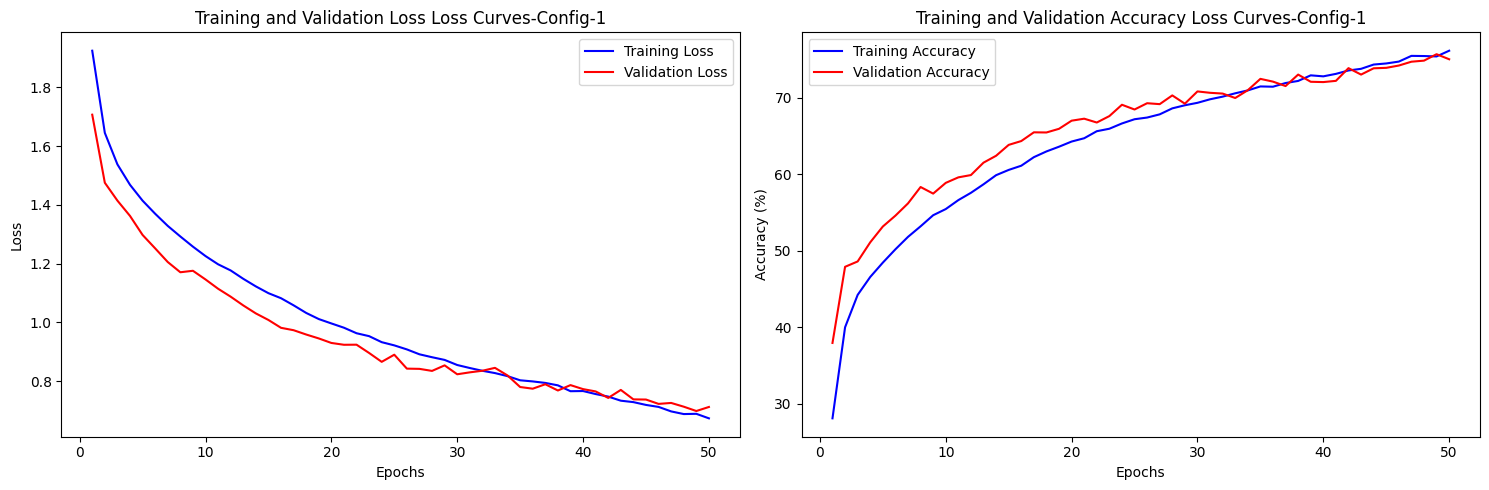

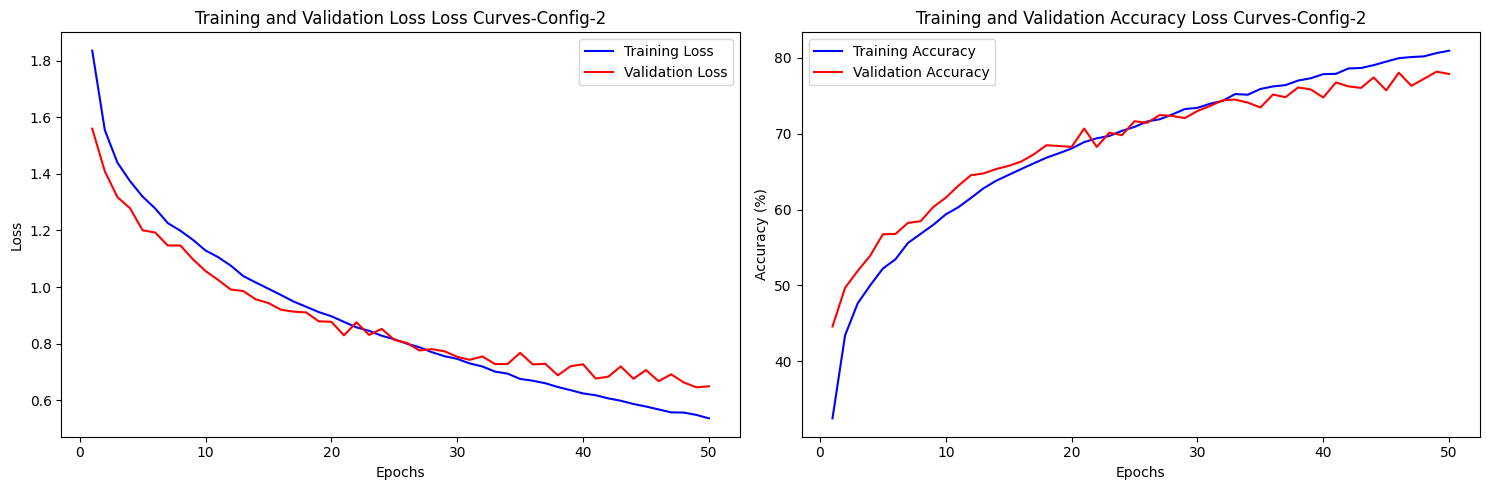

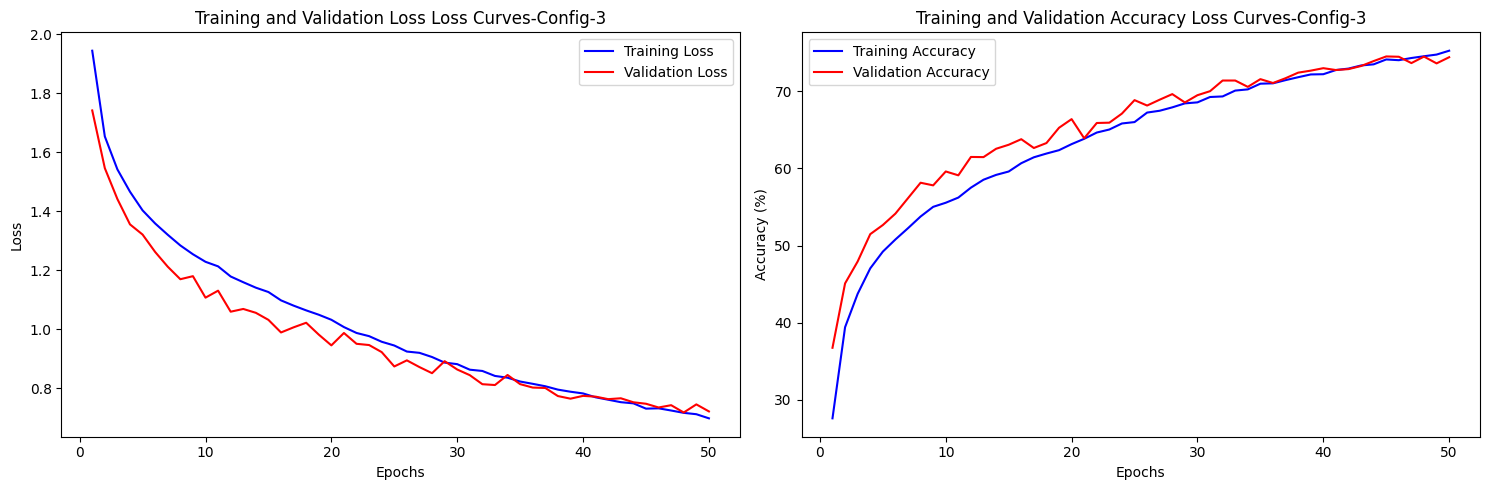

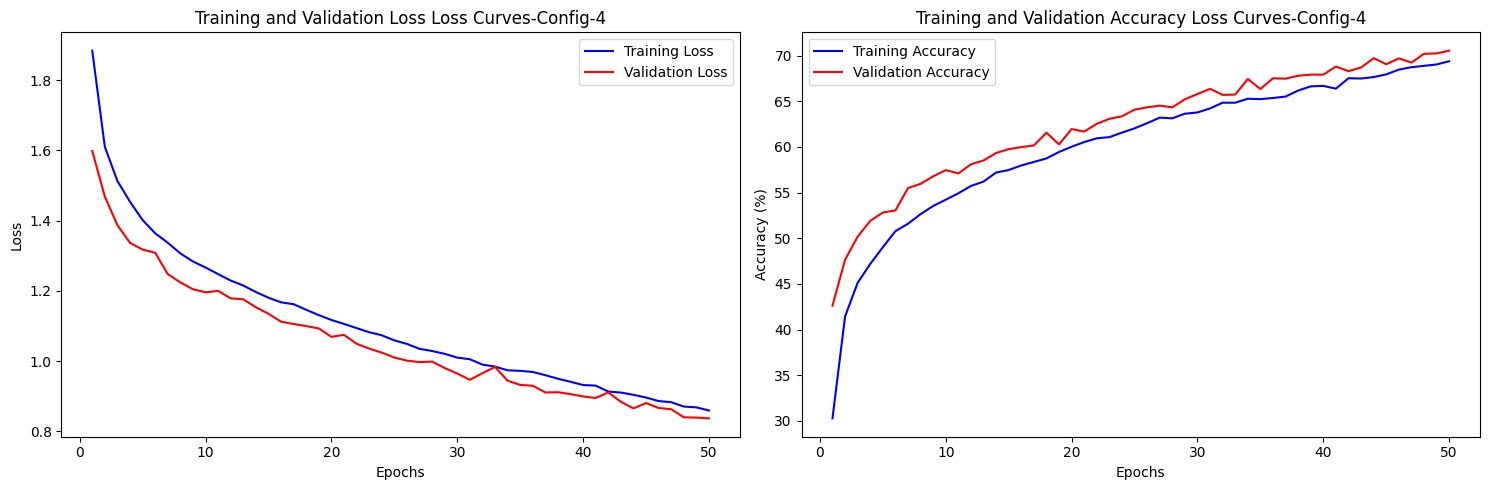

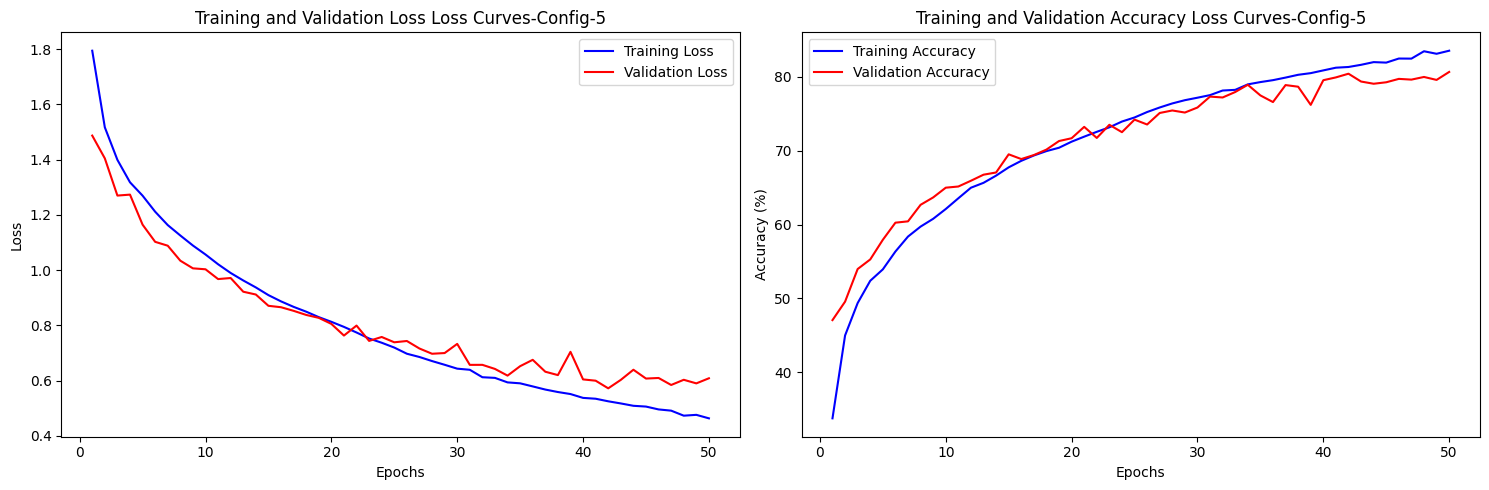

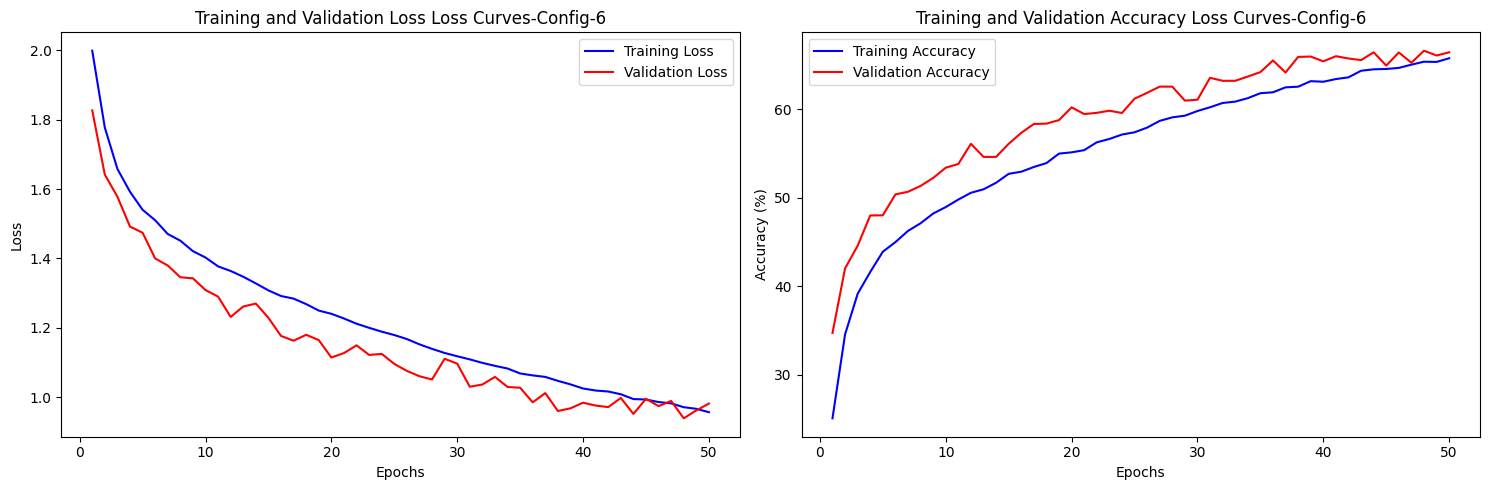

In [18]:
import time
for i, (config, result) in enumerate(zip(configurations, results)):
    print(f"Plot with Config-{i + 1}: {config['embedding_dim']} embedding dimension, {config['num_layers']} layers, {config['mlp_dim']} MLP dimension, {config['num_heads']} heads, patch size {config['patch_size']}, dropout rate {config['dropout_rate']}")
    plot_loss_curves(result['train_losses'], result['val_losses'], result['train_accs'], result['val_accs'], title=f"Loss Curves-Config-{i + 1}")
    time.sleep(1)

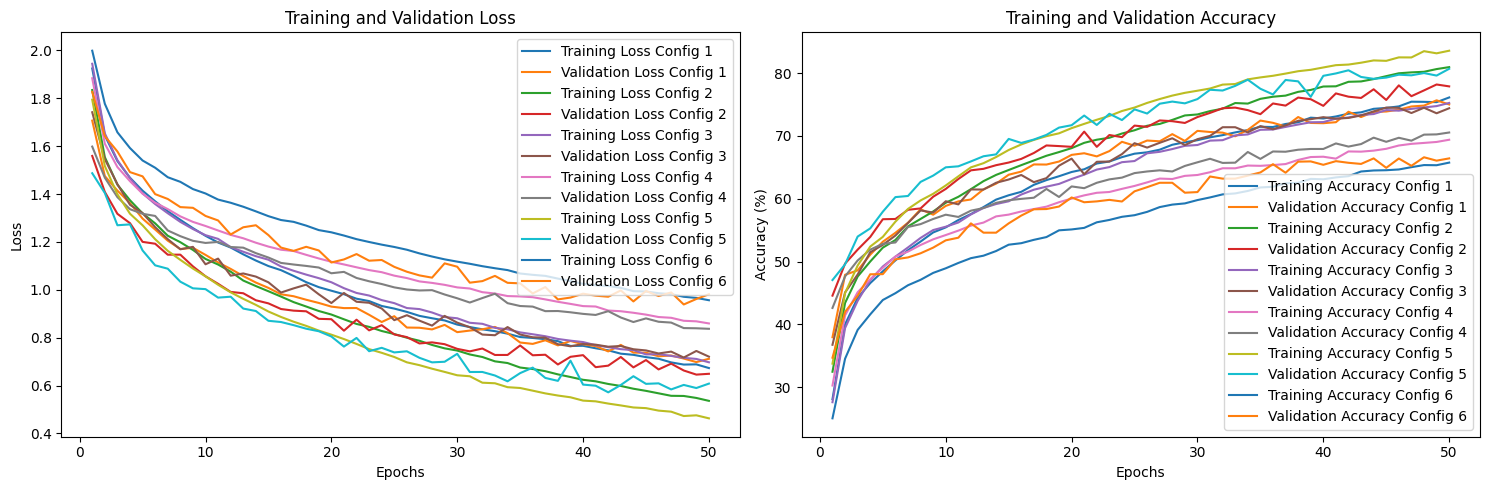

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(results[0]['train_losses']) + 1)

# Loss plot
for i, result in enumerate(results):
    ax1.plot(epochs, result['train_losses'], label=f'Training Loss Config {i+1}')
    ax1.plot(epochs, result['val_losses'], label=f'Validation Loss Config {i+1}')

ax1.set_title(f'Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy plot
for i, result in enumerate(results):
    ax2.plot(epochs, result['train_accs'], label=f'Training Accuracy Config {i+1}')
    ax2.plot(epochs, result['val_accs'], label=f'Validation Accuracy Config {i+1}')

ax2.set_title(f'Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
for config, result in zip(configurations, results):
    print('_' * 50)
    print(f"Plot with Config-{i + 1}: {config['embedding_dim']} embedding dimension, {config['num_layers']} layers, {config['mlp_dim']} MLP dimension, {config['num_heads']} heads, patch size {config['patch_size']}, dropout rate {config['dropout_rate']}")
    print(f"Val Accuracy : {result['val_accs'][-1]}")
    print('_' * 50)

torch.save(best_model.state_dict(), 'visual_transformer_best.pth')
print(best_config)
print(best_accurs)
print(best_model)

For Config : {'patch_size': 4, 'embedding_dim': 128, 'mlp_dim': 256, 'num_layers': 6, 'num_heads': 4, 'dropout_rate': 0.1}:
Val Accuracy : 75.0
For Config : {'patch_size': 4, 'embedding_dim': 256, 'mlp_dim': 512, 'num_layers': 4, 'num_heads': 8, 'dropout_rate': 0.1}:
Val Accuracy : 77.88
For Config : {'patch_size': 4, 'embedding_dim': 96, 'mlp_dim': 192, 'num_layers': 12, 'num_heads': 3, 'dropout_rate': 0.1}:
Val Accuracy : 74.4
For Config : {'patch_size': 8, 'embedding_dim': 128, 'mlp_dim': 256, 'num_layers': 8, 'num_heads': 8, 'dropout_rate': 0.1}:
Val Accuracy : 70.54
For Config : {'patch_size': 4, 'embedding_dim': 384, 'mlp_dim': 768, 'num_layers': 6, 'num_heads': 6, 'dropout_rate': 0.1}:
Val Accuracy : 80.68
For Config : {'patch_size': 4, 'embedding_dim': 128, 'mlp_dim': 256, 'num_layers': 6, 'num_heads': 4, 'dropout_rate': 0.3}:
Val Accuracy : 66.42
{'patch_size': 4, 'embedding_dim': 384, 'mlp_dim': 768, 'num_layers': 6, 'num_heads': 6, 'dropout_rate': 0.1}
80.68
VisionTransforme

### 3. Data Augmentations

In [ ]:
transform1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform3 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),
])

NUM_EPOCHS = 20
augmentation = [transform1, transform2, transform3]
results = []

for augs in augmentation:
    trainloader, testloader = get_dataloaders(train_transform=augs)
    model = VisionTransformer(
        image_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=best_config['embed_dim'],
        num_heads=best_config['num_heads'],
        mlp_dim=best_config['mlp_dim'],
        num_layers=best_config['num_layers'],
        dropout=0.1,
        emb_dropout=0.1,
        use_pos_embed=True
    ).to(device)
    result = train_model(model, trainloader, testloader, device, num_epochs=NUM_EPOCHS)
    results.append(result)


Epoch 1/1


Testing: 100%|██████████| 79/79 [00:01<00:00, 55.64it/s, loss=1.58, acc=43.6]


Train Loss: 1.8978 | Train Acc: 29.52%
Test Loss: 1.5812 | Test Acc: 43.57%

Epoch 1/1


Testing: 100%|██████████| 79/79 [00:01<00:00, 58.08it/s, loss=1.58, acc=43.2]


Train Loss: 1.9823 | Train Acc: 26.92%
Test Loss: 1.5753 | Test Acc: 43.22%

Epoch 1/1


Testing: 100%|██████████| 79/79 [00:01<00:00, 52.99it/s, loss=1.51, acc=45.6]


Train Loss: 1.8171 | Train Acc: 33.73%
Test Loss: 1.5074 | Test Acc: 45.56%


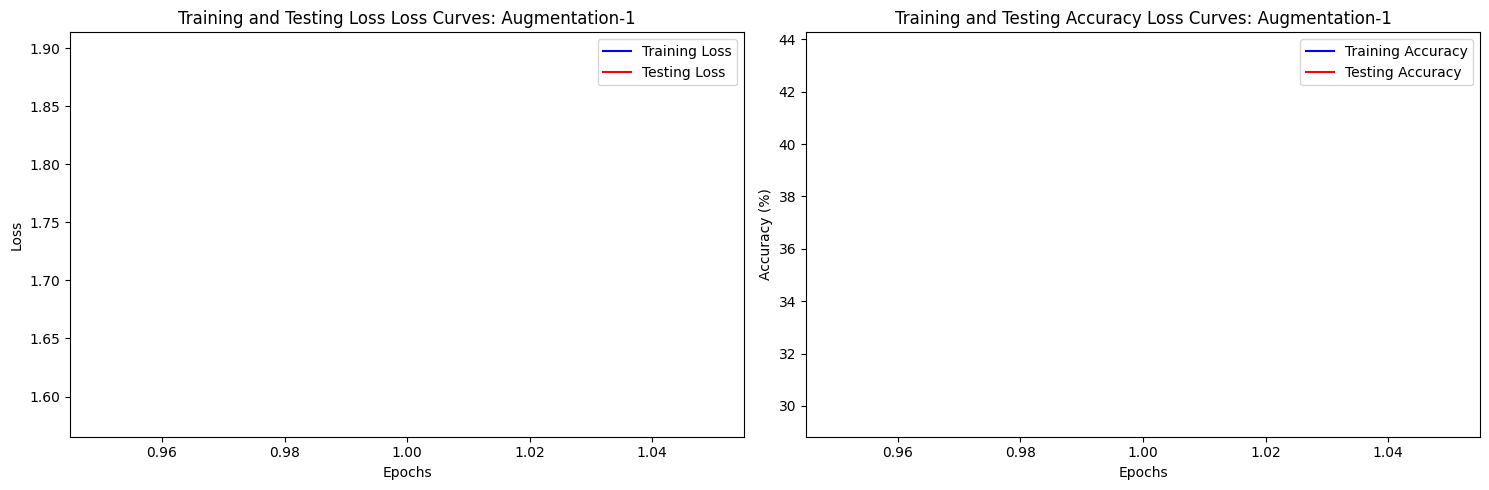

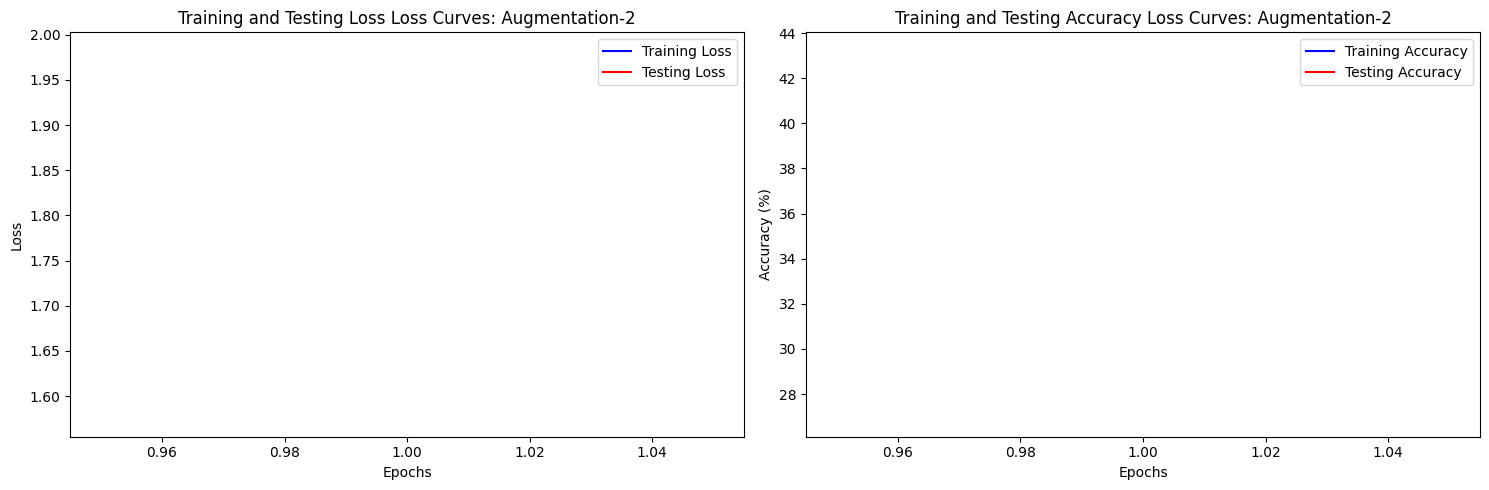

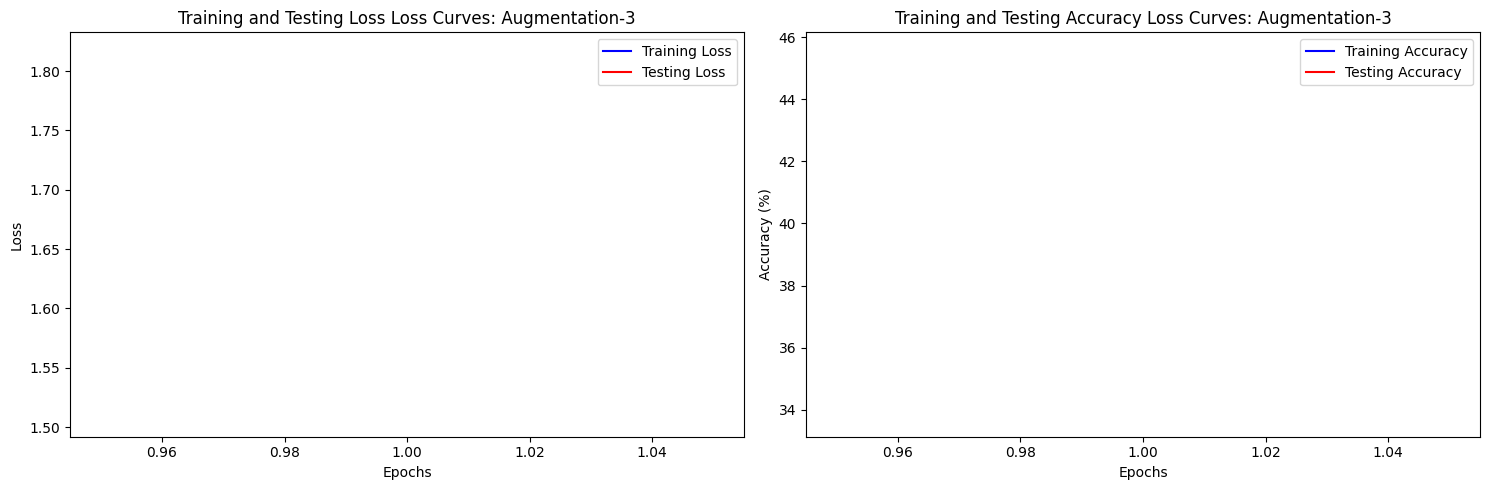

In [ ]:
for i, result in enumerate(results):
    plot_loss_curves(result['train_losses'], result['test_losses'], result['train_accs'], result['test_accs'], title=f"Loss Curves: Augmentation-{i + 1}")

In [ ]:
print("Test Accuracy with different Augmentations:")
for i, result in enumerate(results):
    print(f"Augmentation-{i + 1} - {result['test_accs'][-1]} ")

Test Accuracy with different Augmentations:
Augmentation-1 - 43.57 
Augmentation-2 - 43.22 
Augmentation-3 - 45.56 


## 1.3 Positional Embeddings

In [ ]:
NUM_EPOCHS = 20
pos_embeddings = ['none', '1d_learned', '2d_learned', 'sinusoidal']
results = []

for pos_embds in pos_embeddings:
    model = VisionTransformer(
        image_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=best_config['embed_dim'],
        num_heads=best_config['num_heads'],
        mlp_dim=best_config['mlp_dim'],
        num_layers=best_config['num_layers'],
        dropout=0.1,
        emb_dropout=0.1,
        use_pos_embed=True,
        pos_embed_type=pos_embds
    ).to(device)
    result = train_model(model, trainloader, testloader, device, num_epochs=NUM_EPOCHS)
    results.append(result)


Epoch 1/1


Testing: 100%|██████████| 79/79 [00:01<00:00, 54.84it/s, loss=1.5, acc=47]   


Train Loss: 1.8008 | Train Acc: 33.97%
Test Loss: 1.4954 | Test Acc: 47.03%

Epoch 1/1


Testing: 100%|██████████| 79/79 [00:01<00:00, 54.36it/s, loss=1.48, acc=47.2]


Train Loss: 1.8023 | Train Acc: 34.10%
Test Loss: 1.4818 | Test Acc: 47.25%

Epoch 1/1


Testing: 100%|██████████| 79/79 [00:01<00:00, 54.14it/s, loss=1.47, acc=47.2]


Train Loss: 1.8002 | Train Acc: 34.36%
Test Loss: 1.4667 | Test Acc: 47.24%

Epoch 1/1


Testing: 100%|██████████| 79/79 [00:01<00:00, 53.35it/s, loss=1.49, acc=46.6]


Train Loss: 1.8090 | Train Acc: 33.99%
Test Loss: 1.4924 | Test Acc: 46.58%


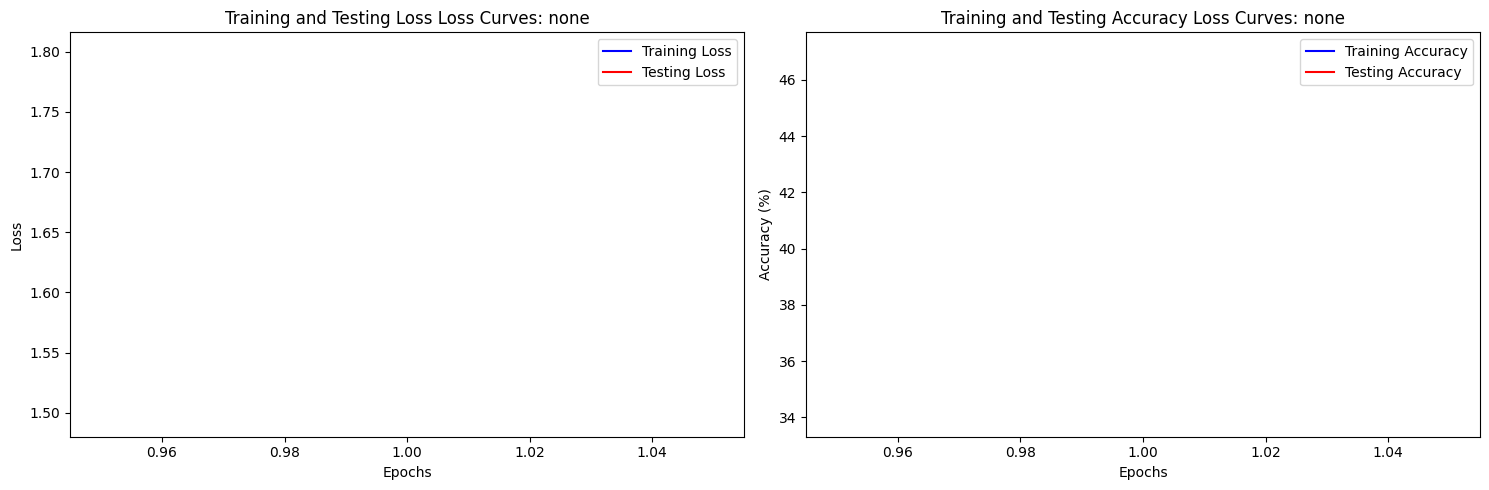

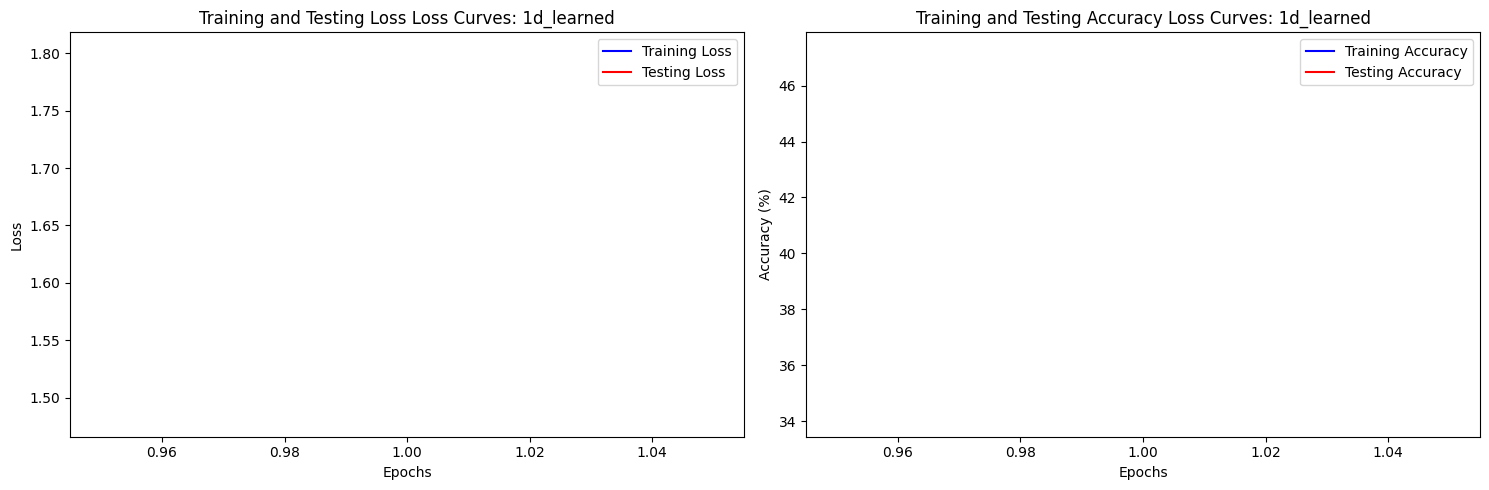

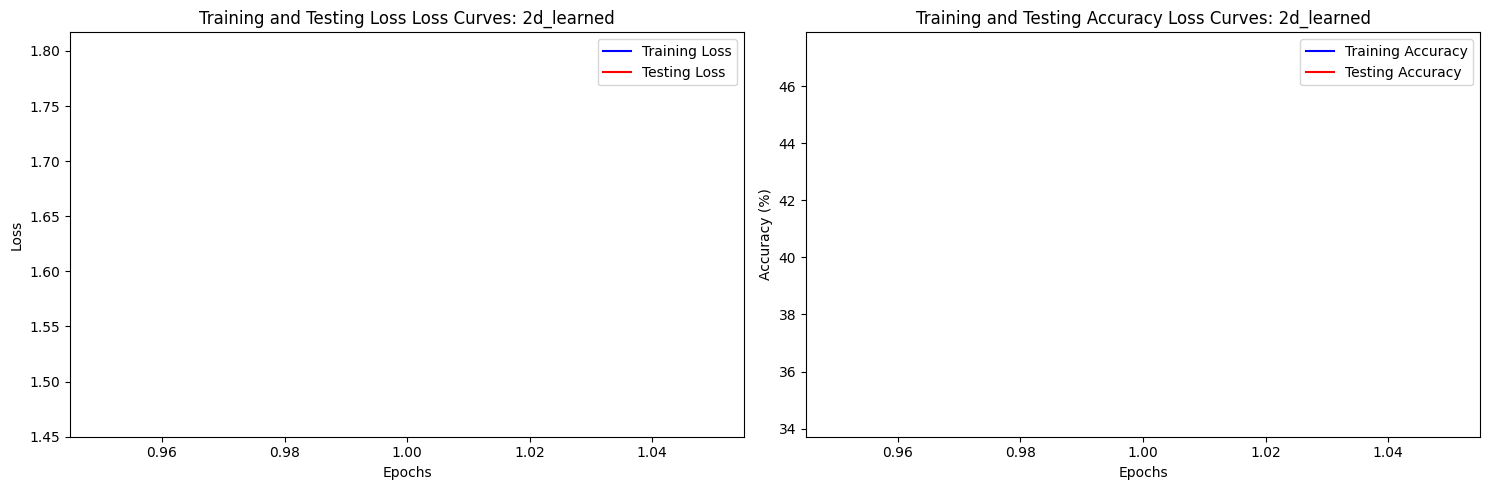

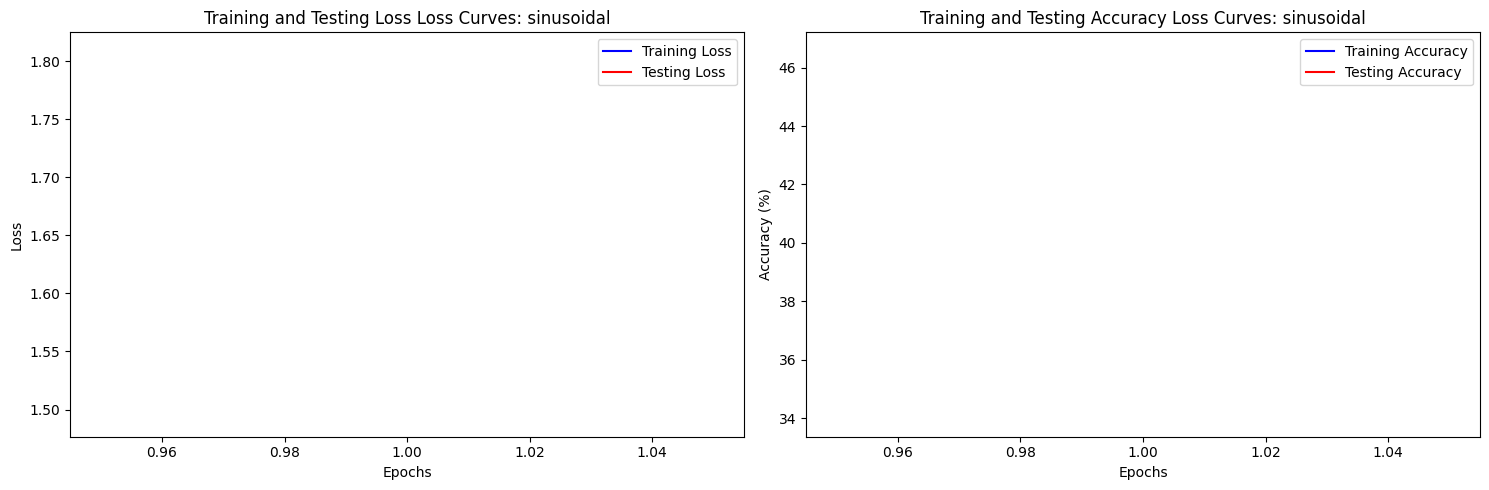

In [ ]:
for result, pos_embd in zip(results, pos_embeddings):
    plot_loss_curves(result['train_losses'], result['test_losses'], result['train_accs'], result['test_accs'], title=f"Loss Curves: {pos_embd}")

In [ ]:
print("Test Accuracy with different positional embeddings:")
for pos_embd, result in zip(pos_embeddings, results):
    print(f"Positional Embedding Type: {pos_embd} - {result['test_accs'][-1]} ")

Test Accuracy with different positional embeddings:
Positional Embedding Type: none - 47.03 
Positional Embedding Type: 1d_learned - 47.25 
Positional Embedding Type: 2d_learned - 47.24 
Positional Embedding Type: sinusoidal - 46.58 


In [ ]:
def visualize_positional_embeddings(model, patch_size=16, save_path=None):
    # Extract positional embeddings from the model
    # Note: The exact way to access these might vary depending on the model implementation
    pos_embed = model.pos_embedding.data
    
    # Remove the class token positional embedding (first token)
    pos_embed = pos_embed[0, 1:, :]
    
    # Normalize the embeddings
    pos_embed_normalized = pos_embed / pos_embed.norm(dim=1, keepdim=True)
    
    # Compute similarity matrix (dot product)
    similarity = torch.matmul(pos_embed_normalized, pos_embed_normalized.transpose(0, 1)).cpu().numpy()
    
    # Get dimensions
    num_patches = pos_embed.shape[0]
    grid_size = int(np.sqrt(num_patches))
    
    plt.figure(figsize=(12, 6))
    
    # Plot the full similarity matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(similarity, cmap="viridis")
    plt.title("Positional Embedding Similarities")
    plt.xlabel("Position Index")
    plt.ylabel("Position Index")
    
    # Plot spatial visualization (2D arrangement)
    plt.subplot(1, 2, 2)
    
    # Reshape for 2D visualization if grid is square
    if grid_size * grid_size == num_patches:
        # Create a 2D grid to visualize spatial relationships more clearly
        pos_indices = np.arange(num_patches)
        selected_pos = grid_size // 2 * grid_size + grid_size // 2  # Center position
        
        # Get similarities with respect to the center position
        center_similarities = similarity[selected_pos]
        center_similarities_2d = center_similarities.reshape(grid_size, grid_size)
        
        # Plot as a heatmap
        sns.heatmap(center_similarities_2d, cmap="viridis")
        plt.title(f"Similarity to Center Position ({selected_pos})")
        plt.xlabel(f"X Position (patch size: {patch_size}px)")
        plt.ylabel(f"Y Position (patch size: {patch_size}px)")
    else:
        # If not a perfect square, just plot the row for the middle position
        middle_pos = num_patches // 2
        plt.plot(similarity[middle_pos])
        plt.title(f"Similarity to Middle Position ({middle_pos})")
        plt.xlabel("Position Index")
        plt.ylabel("Similarity")
    
    plt.tight_layout()
    plt.show()


# Attention rollout implementation as described in the paper
def attention_rollout(attention_maps, discard_ratio=0.9):
    # Get number of layers, batch size, heads, and sequence length
    num_layers = len(attention_maps)
    B, H, N, _ = attention_maps[0].shape
    
    # Initialize identity matrix for the rollout computation
    attention_rollout = torch.eye(N).unsqueeze(0).repeat(B, 1, 1).to(attention_maps[0].device)
    
    # Process each layer
    for attention_map in attention_maps:
        # Average attention across heads
        layer_attention = attention_map.mean(dim=1)  # [B, N, N]
        
        # Apply discard ratio (mask out small attention weights)
        if discard_ratio > 0:
            # Flatten to find threshold value
            flat_attn = layer_attention.view(B, -1)
            # Find threshold for each sample in batch
            threshold_values = torch.kthvalue(
                flat_attn, 
                k=int(flat_attn.shape[1] * discard_ratio), 
                dim=1, 
                keepdim=True
            )[0]
            threshold_values = threshold_values.view(B, 1, 1)
            # Create mask for small attention weights
            mask = (layer_attention >= threshold_values).float()
            # Apply mask and rescale to sum to 1
            layer_attention = layer_attention * mask
            row_sums = layer_attention.sum(dim=-1, keepdim=True)
            row_sums[row_sums == 0] = 1.0  # Avoid division by zero
            layer_attention = layer_attention / row_sums
        
        # Compute rollout: R^(l+1) = R^(l) · A^(l+1)
        attention_rollout = torch.bmm(layer_attention, attention_rollout)
    
    return attention_rollout


# Function to visualize attention maps
def visualize_attention(image_tensor, attention_map, patch_size, save_path=None):
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    # Normalize image for visualization
    img = (img - img.min()) / (img.max() - img.min())
    
    # Attention from CLS token to patches (excluding CLS token attention to itself)
    cls_attention = attention_map[0, 1:].cpu().numpy()
    
    # Reshape attention to match image patches
    img_h, img_w = image_tensor.shape[1], image_tensor.shape[2]
    num_patches_h, num_patches_w = img_h // patch_size, img_w // patch_size
    
    # Reshape attention to match patch grid
    attention_map_img = cls_attention.reshape(num_patches_h, num_patches_w)
    
    # Resize attention map to image size
    attention_map_img = cv2.resize(attention_map_img, (img_w, img_h))
    
    # Create heatmap
    attention_map_img = np.uint8(255 * attention_map_img)
    attention_map_img = cv2.applyColorMap(attention_map_img, cv2.COLORMAP_JET)
    attention_map_img = cv2.cvtColor(attention_map_img, cv2.COLOR_BGR2RGB) / 255.0
    
    # Combine original image and attention map
    alpha = 0.6  # Transparency factor
    plt.figure(figsize=(10, 10))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    
    # Attention map
    plt.subplot(1, 3, 2)
    plt.imshow(attention_map_img)
    plt.title("Attention Map")
    plt.axis('off')
    
    # Combined
    plt.subplot(1, 3, 3)
    plt.imshow(img * (1-alpha) + attention_map_img * alpha)
    plt.title("Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Function to visualize attention maps from all heads
def visualize_multi_head_attention(image_tensor, attention_maps, patch_size, layer_idx, save_path=None):
    _, num_heads, _, _ = attention_maps.shape
    num_plots = num_heads + 2  # 1 original + num_heads + 1 avg
    grid_size = int(np.ceil(np.sqrt(num_plots)))
    
    # Prepare figure
    plt.figure(figsize=(15, 15))
    
    # Normalize image for visualization
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    
    # Show original image
    plt.subplot(grid_size, grid_size, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    
    # Process each attention head
    for h in range(num_heads):
        # Attention from CLS token to patches
        cls_attention = attention_maps[0, h, 0, 1:].cpu().numpy()
        
        # Reshape attention to match image patches
        img_h, img_w = image_tensor.shape[1], image_tensor.shape[2]
        num_patches_h, num_patches_w = img_h // patch_size, img_w // patch_size
        
        # Reshape attention to match patch grid
        attention_map_img = cls_attention.reshape(num_patches_h, num_patches_w)
        
        # Resize attention map to image size for better visualization
        attention_map_img = cv2.resize(attention_map_img, (img_w, img_h))
        
        # Plot attention map
        plt.subplot(grid_size, grid_size, h + 2)  # +2 because we started with original image
        plt.imshow(attention_map_img, cmap='viridis')
        plt.title(f"Head {h}")
        plt.axis('off')
    
    # Average attention across heads
    avg_attention = attention_maps[0, :, 0, 1:].mean(dim=0).cpu().numpy()
    
    # Reshape and resize average attention
    avg_attention_img = avg_attention.reshape(num_patches_h, num_patches_w)
    avg_attention_img = cv2.resize(avg_attention_img, (img_w, img_h))
    
    # Plot average attention
    plt.subplot(grid_size, grid_size, num_heads + 2)
    plt.imshow(avg_attention_img, cmap='viridis')
    plt.title("Average Attention")
    plt.axis('off')
    
    plt.suptitle(f"Layer {layer_idx} Attention Maps", fontsize=16)
    plt.tight_layout()
    plt.show()


# Function to visualize attention rollout results
def visualize_rollout(image_tensor, rollout_map, patch_size, save_path=None):
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    # Normalize image for visualization
    img = (img - img.min()) / (img.max() - img.min())
    
    # Attention from CLS token to patches (excluding CLS token)
    cls_rollout = rollout_map[0, 1:].cpu().numpy()
    
    # Reshape attention to match image patches
    img_h, img_w = image_tensor.shape[1], image_tensor.shape[2]
    num_patches_h, num_patches_w = img_h // patch_size, img_w // patch_size
    
    # Reshape attention to match patch grid
    rollout_img = cls_rollout.reshape(num_patches_h, num_patches_w)
    
    # Resize attention map to image size
    rollout_img = cv2.resize(rollout_img, (img_w, img_h))
    
    # Create heatmap
    rollout_img_heatmap = np.uint8(255 * rollout_img)
    rollout_img_heatmap = cv2.applyColorMap(rollout_img_heatmap, cv2.COLORMAP_JET)
    rollout_img_heatmap = cv2.cvtColor(rollout_img_heatmap, cv2.COLOR_BGR2RGB) / 255.0
    
    # Combine original image and attention map
    alpha = 0.5  # Transparency factor
    plt.figure(figsize=(10, 10))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    
    # Rollout map
    plt.subplot(1, 3, 2)
    plt.imshow(rollout_img, cmap='viridis')
    plt.title("Attention Rollout")
    plt.axis('off')
    
    # Combined
    plt.subplot(1, 3, 3)
    plt.imshow(img * (1-alpha) + rollout_img_heatmap * alpha)
    plt.title("Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_dino_attention(image_tensor, attention_maps, patch_size=8, threshold=None, save_path=None):
    # Convert image tensor to numpy for visualization
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    # Normalize image for visualization
    img = (img - img.min()) / (img.max() - img.min())
    
    # Get the attention from the last layer
    last_attn = attention_maps[-1]  # [B, num_heads, seq_len, seq_len]
    
    # We focus on the attention maps of the [CLS] token (first token in the sequence)
    cls_attn = last_attn[0, :, 0, 1:]  # Take attention from cls token to patch tokens only
    
    # Average over heads
    cls_attn = cls_attn.mean(dim=0)
    
    # Apply threshold if specified
    if threshold is not None:
        val, idx = torch.sort(cls_attn)
        val /= torch.sum(val)
        cumval = torch.cumsum(val, dim=0)
        th_attn = cumval > (1 - threshold)
        idx2 = torch.argsort(idx)
        th_attn = th_attn[idx2]
        cls_attn = cls_attn * th_attn
    
    # Reshape to match the image dimensions
    H, W = image_tensor.shape[1], image_tensor.shape[2] 
    w_featmap = W // patch_size
    h_featmap = H // patch_size
    cls_attn = cls_attn.reshape(w_featmap, h_featmap)
    
    # Upsample to original image size
    cls_attn = cls_attn.unsqueeze(0).unsqueeze(0)
    cls_attn = nn.functional.interpolate(cls_attn, scale_factor=patch_size, mode='nearest')
    cls_attn = cls_attn[0, 0].cpu().numpy()
    
    # Visualize
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    # Attention map
    ax[1].imshow(cls_attn, cmap='viridis')
    ax[1].set_title('Attention Map')
    ax[1].axis('off')
    
    # Overlay
    ax[2].imshow(np.array(img))
    ax[2].imshow(cls_attn, alpha=0.6, cmap='viridis')
    ax[2].set_title('Overlay')
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # if save_path:
    #     plt.savefig(save_path)
    #     print(f"Visualization saved to {save_path}")
    
    # return fig


# Main function to run visualizations
def run_visualizations(model_path, testset, patch_size=4, num_images=1):
    model = VisionTransformer(
        image_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=best_config['embed_dim'],
        num_heads=best_config['num_heads'],
        mlp_dim=best_config['mlp_dim'],
        num_layers=best_config['num_layers'],
        dropout=0.1,
        emb_dropout=0.1,
        use_pos_embed=True,
        pos_embed_type=pos_embds
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # Create output directory
    # os.makedirs('visualizations', exist_ok=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)
    
    # Get class names
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    # Visualization loop
    for i, (image, label) in enumerate(testloader):
        if i >= num_images:
            break
        
        image = image.to(device)
        
        # Forward pass to get attention maps
        with torch.no_grad():
            logits, attention_maps = model(image)
            
            # Create denormalized image for visualization
            vis_image = image.clone().detach()
            mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1).to(device)
            std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1).to(device)
            vis_image = vis_image * std + mean  # Denormalize
            vis_image.clamp_(0, 1)
            
            # Predicted class
            pred = logits.argmax(dim=1).item()
            class_name = classes[label.item()]
            pred_name = classes[pred]
            
            print(f"\nImage {i+1}: True: {class_name}, Predicted: {pred_name}")
            
            # 1. Visualize attention from last layer's CLS token
            last_attn = attention_maps[-1]  # Last layer attention
            
            # Average across heads for attention visualization
            avg_last_attn = last_attn.mean(dim=1)  # [B, N, N]

            save_path = f'visualizations/image{i+1}_{class_name}_cls_attn.png'
            visualize_attention(vis_image[0], avg_last_attn[0], patch_size, save_path)
            
            # 2. Visualize attention maps from all heads of the last layer
            save_path = f'visualizations/image{i+1}_{class_name}_multi_head.png'
            visualize_multi_head_attention(vis_image[0], last_attn, patch_size, "Last", save_path)
            
            # 3. Compute and visualize attention rollout
            rollout = attention_rollout(attention_maps)
            save_path = f'visualizations/image{i+1}_{class_name}_rollout.png'
            visualize_rollout(vis_image[0], rollout[0], patch_size, save_path)

            visualize_positional_embeddings(model)

            visualize_dino_attention(vis_image[0], attention_maps, patch_size)
            
            # 4. Visualize attention across layers (optional)
            for layer_idx, attn in enumerate(attention_maps):
                save_path = f'visualizations/image{i+1}_{class_name}_layer{layer_idx}.png'
                visualize_multi_head_attention(vis_image[0], attn, patch_size, layer_idx, save_path)


Image 1: True: truck, Predicted: truck


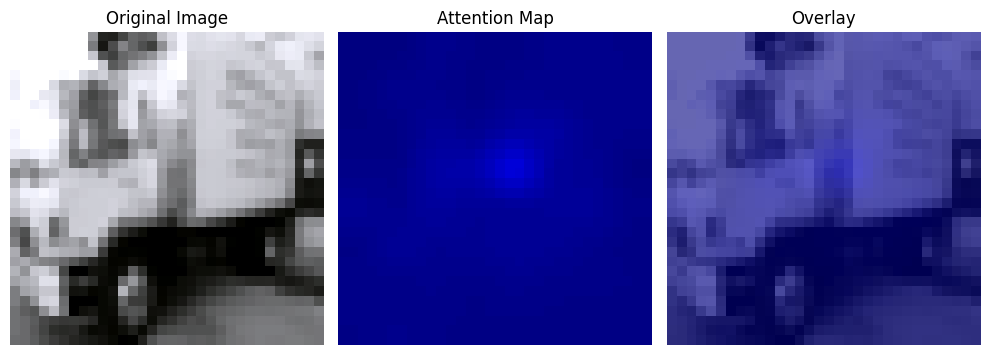

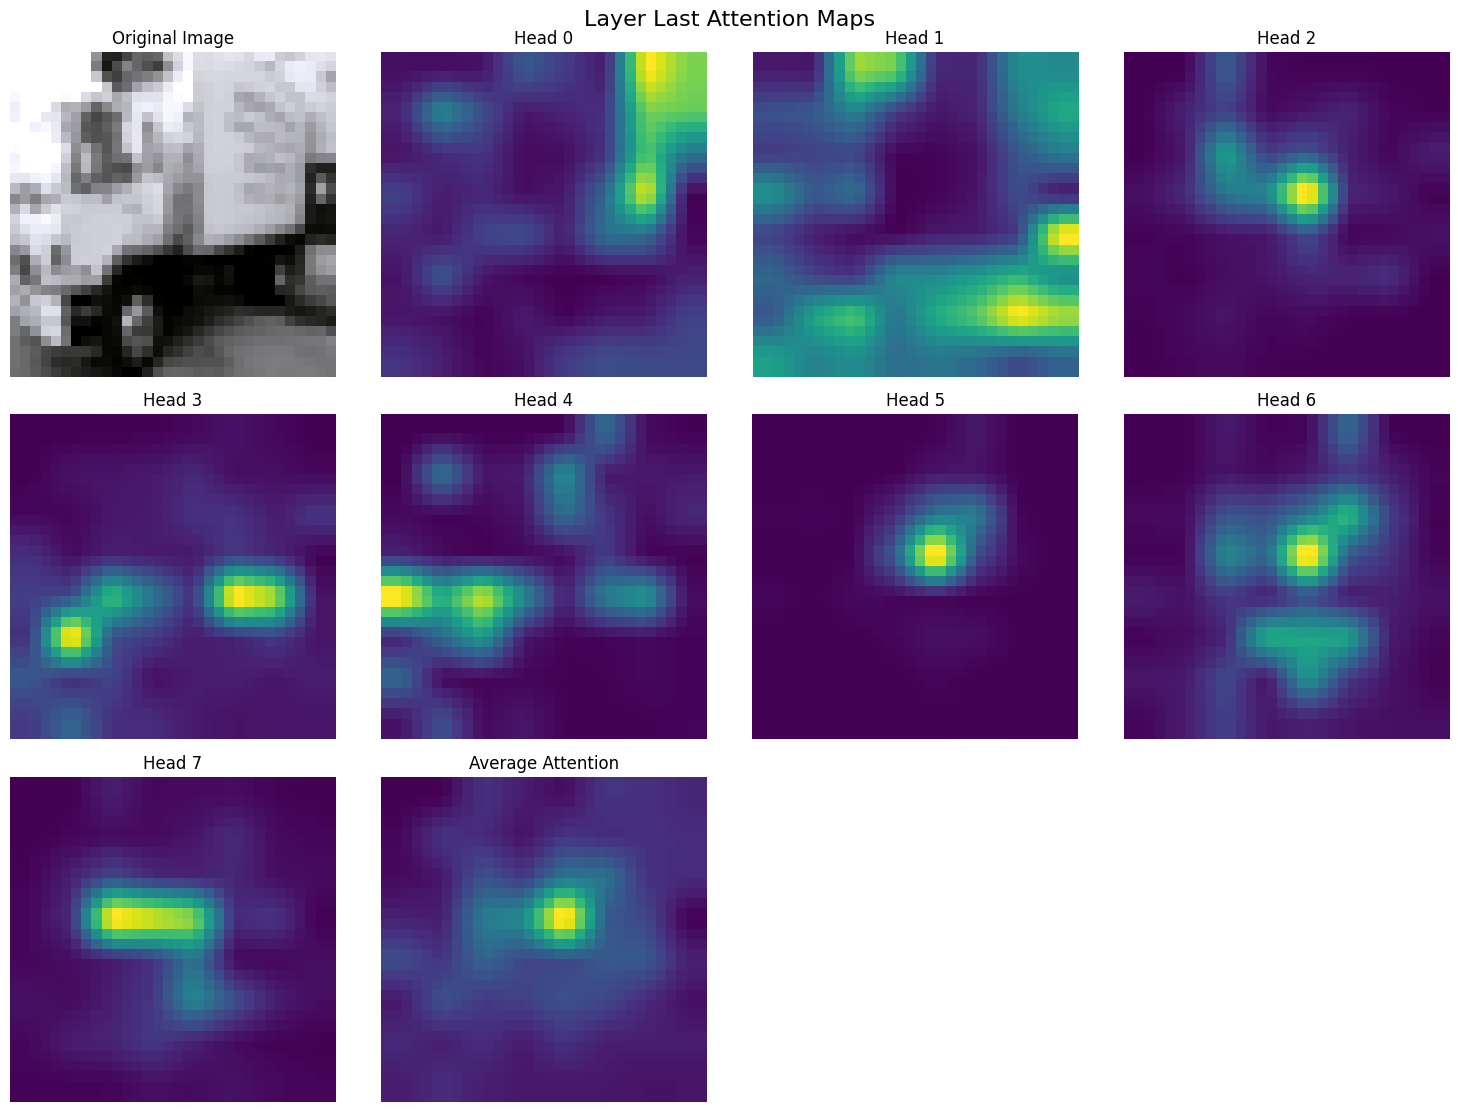

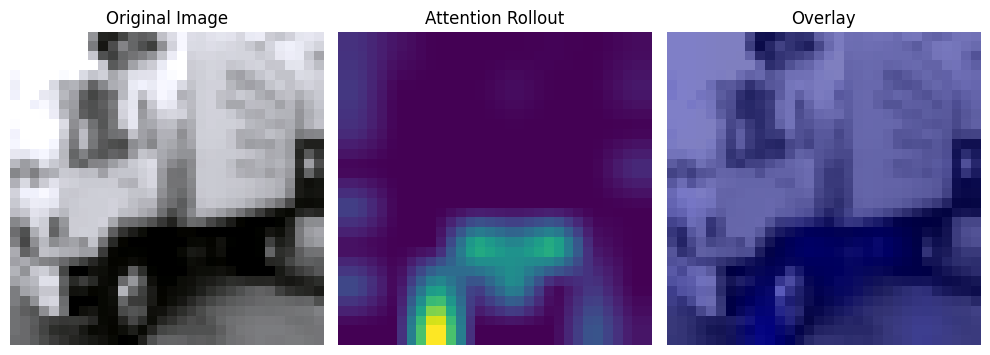

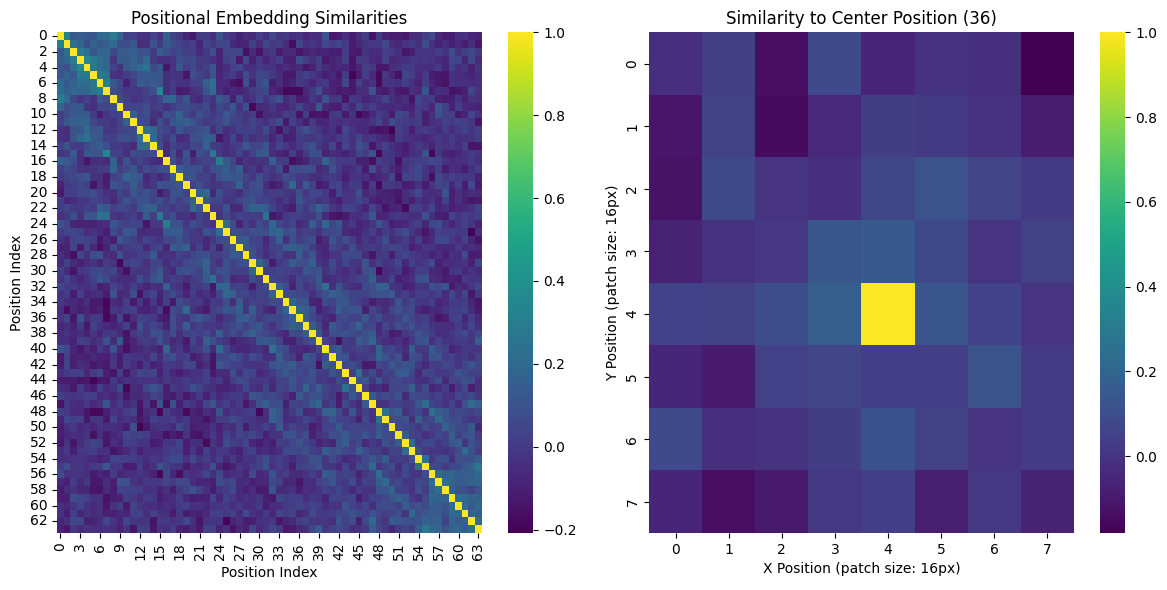

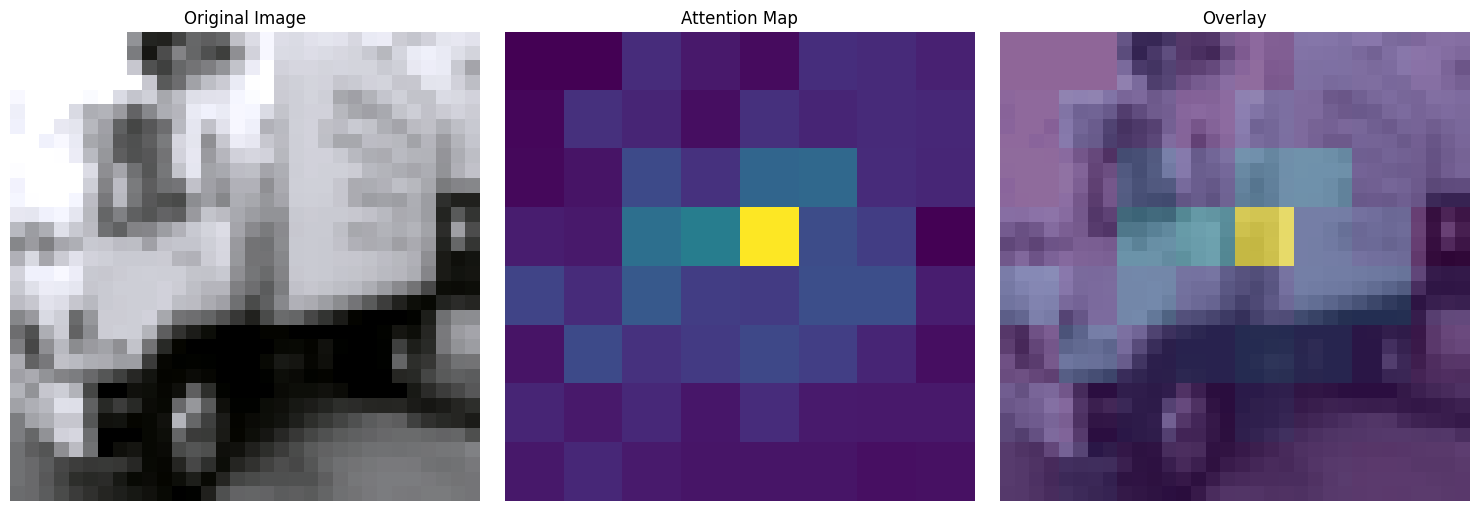

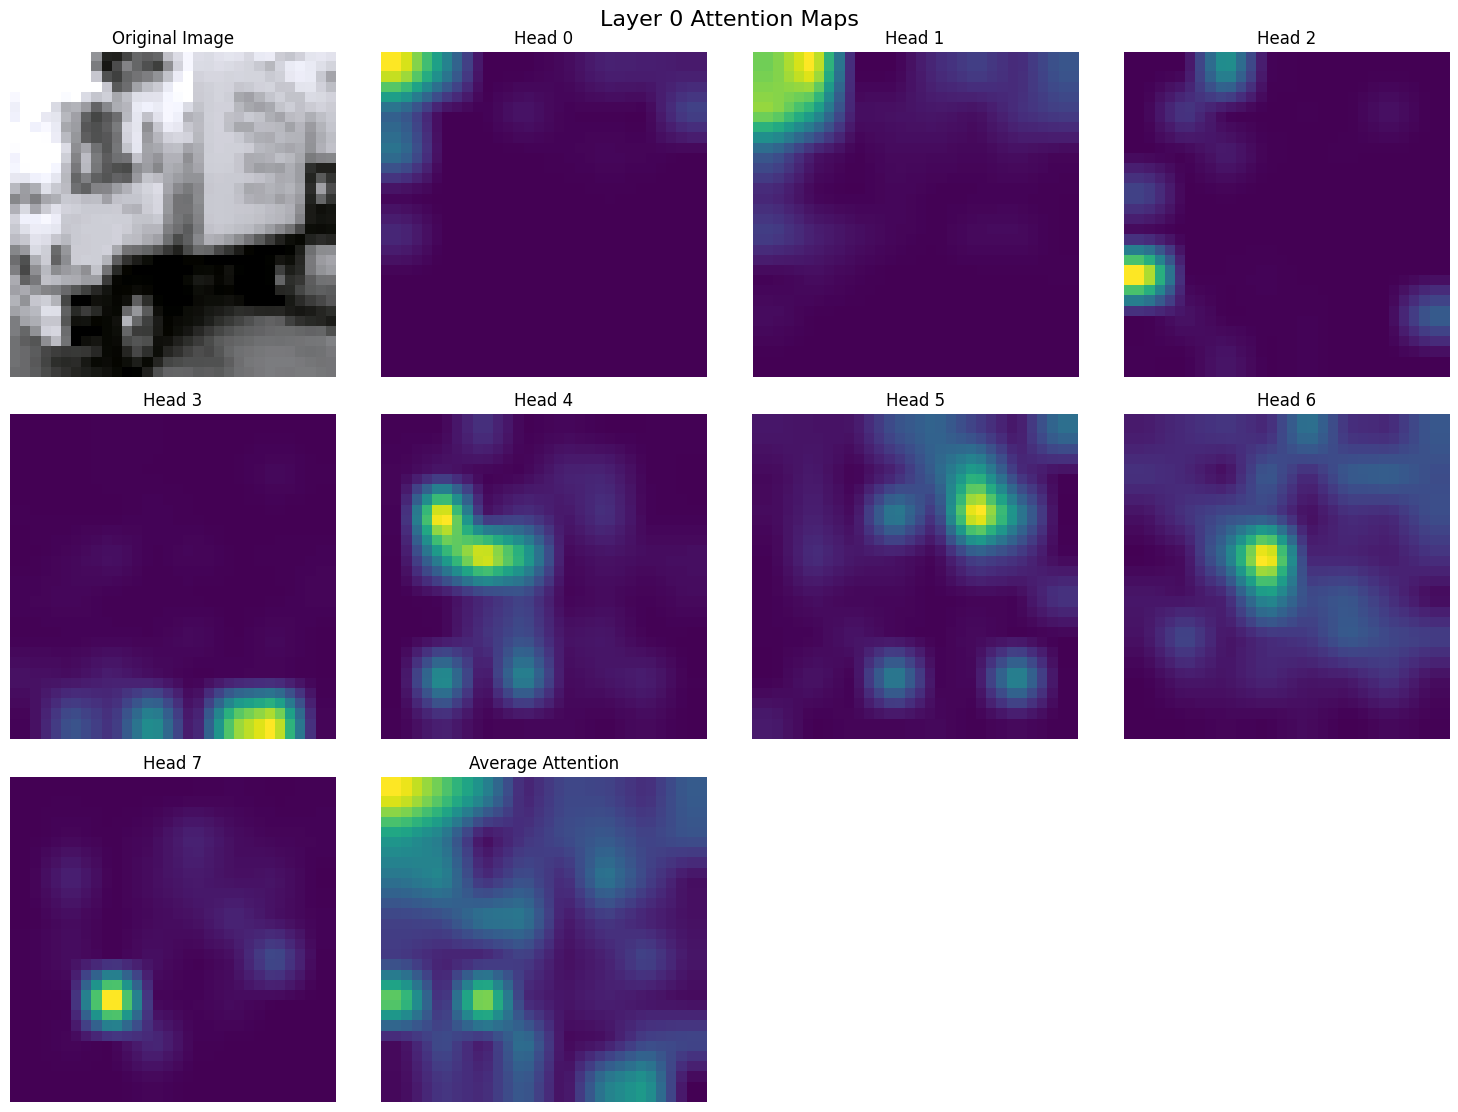

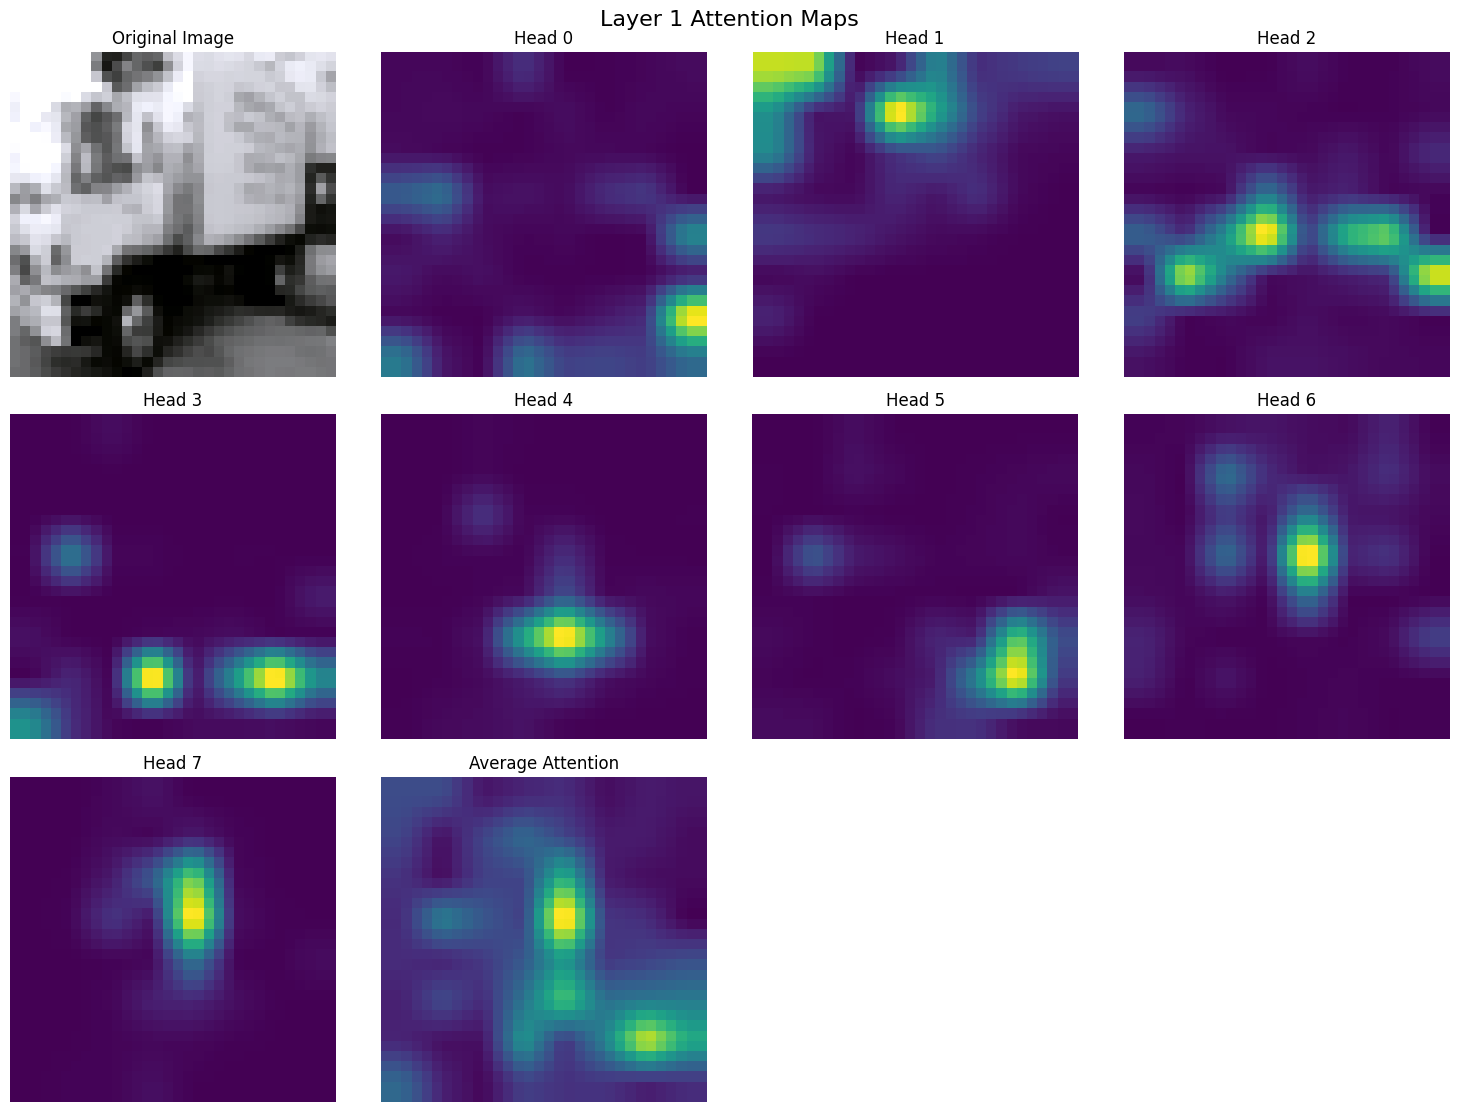

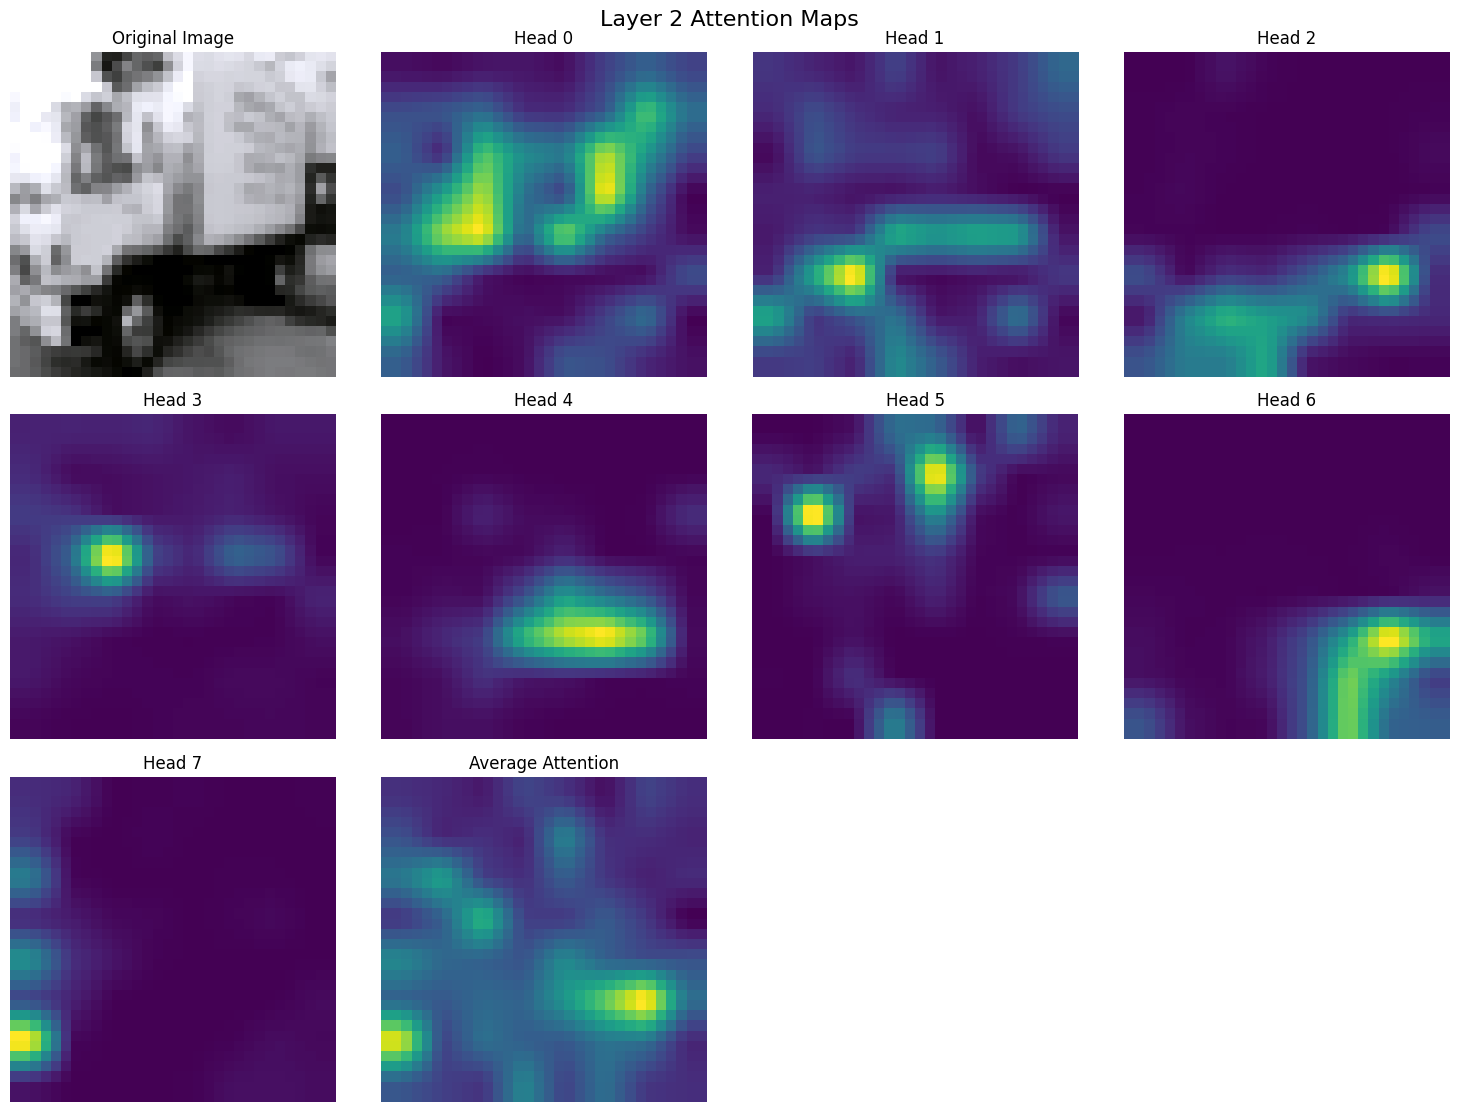

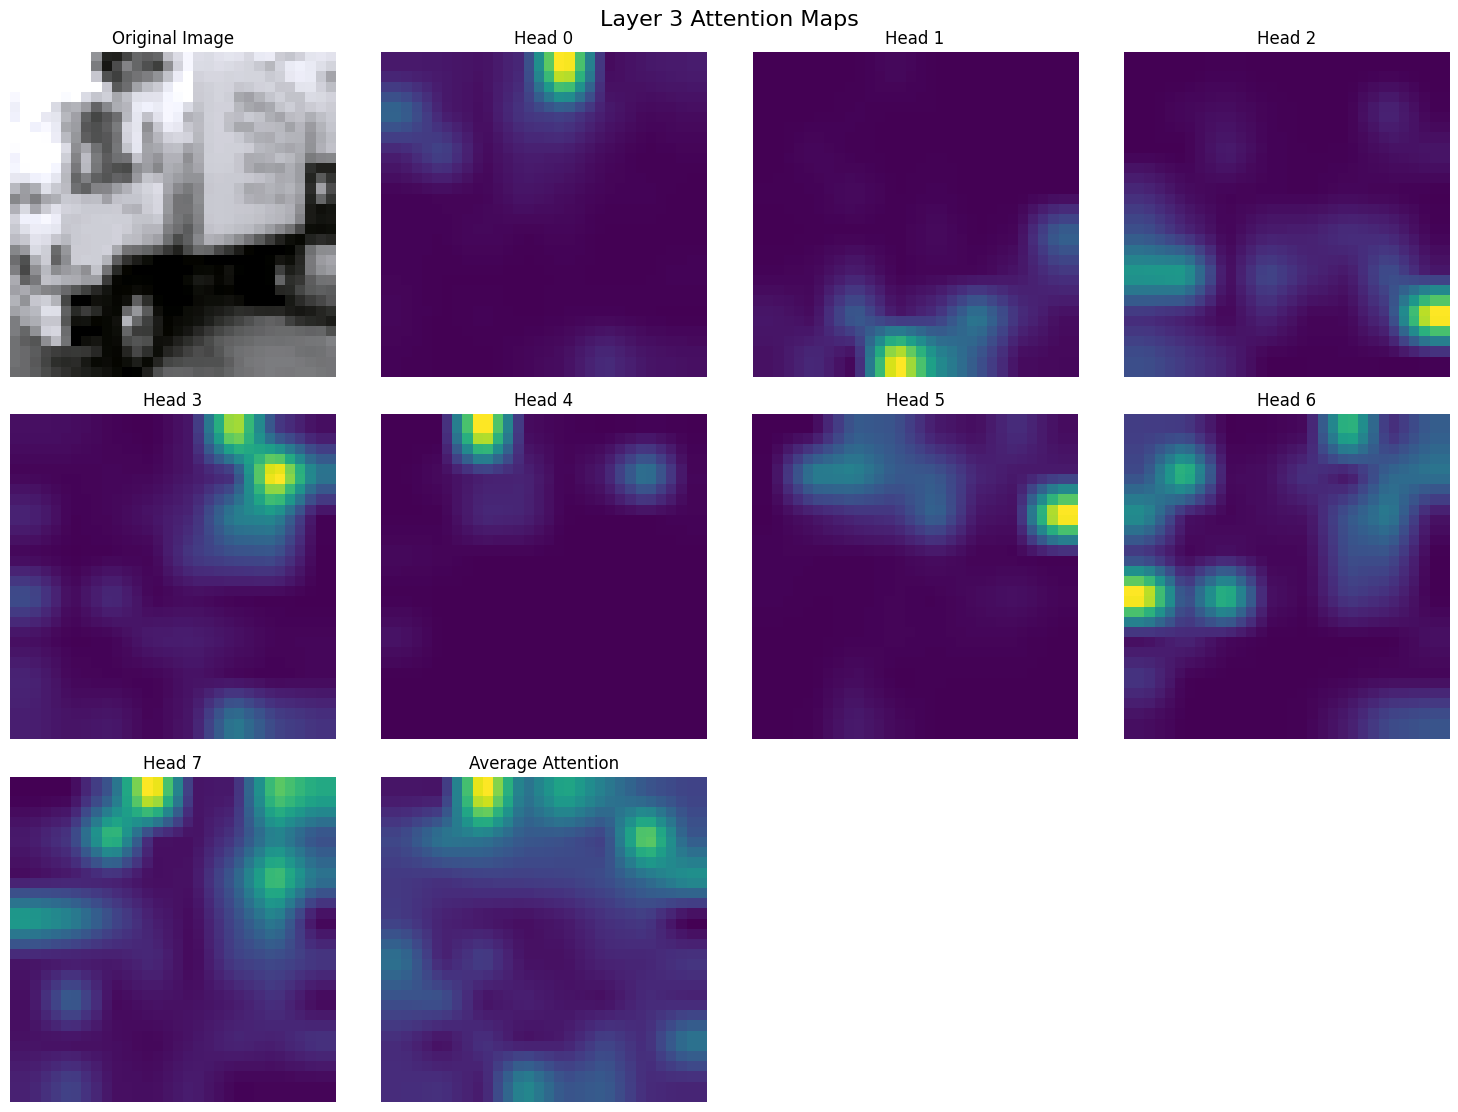

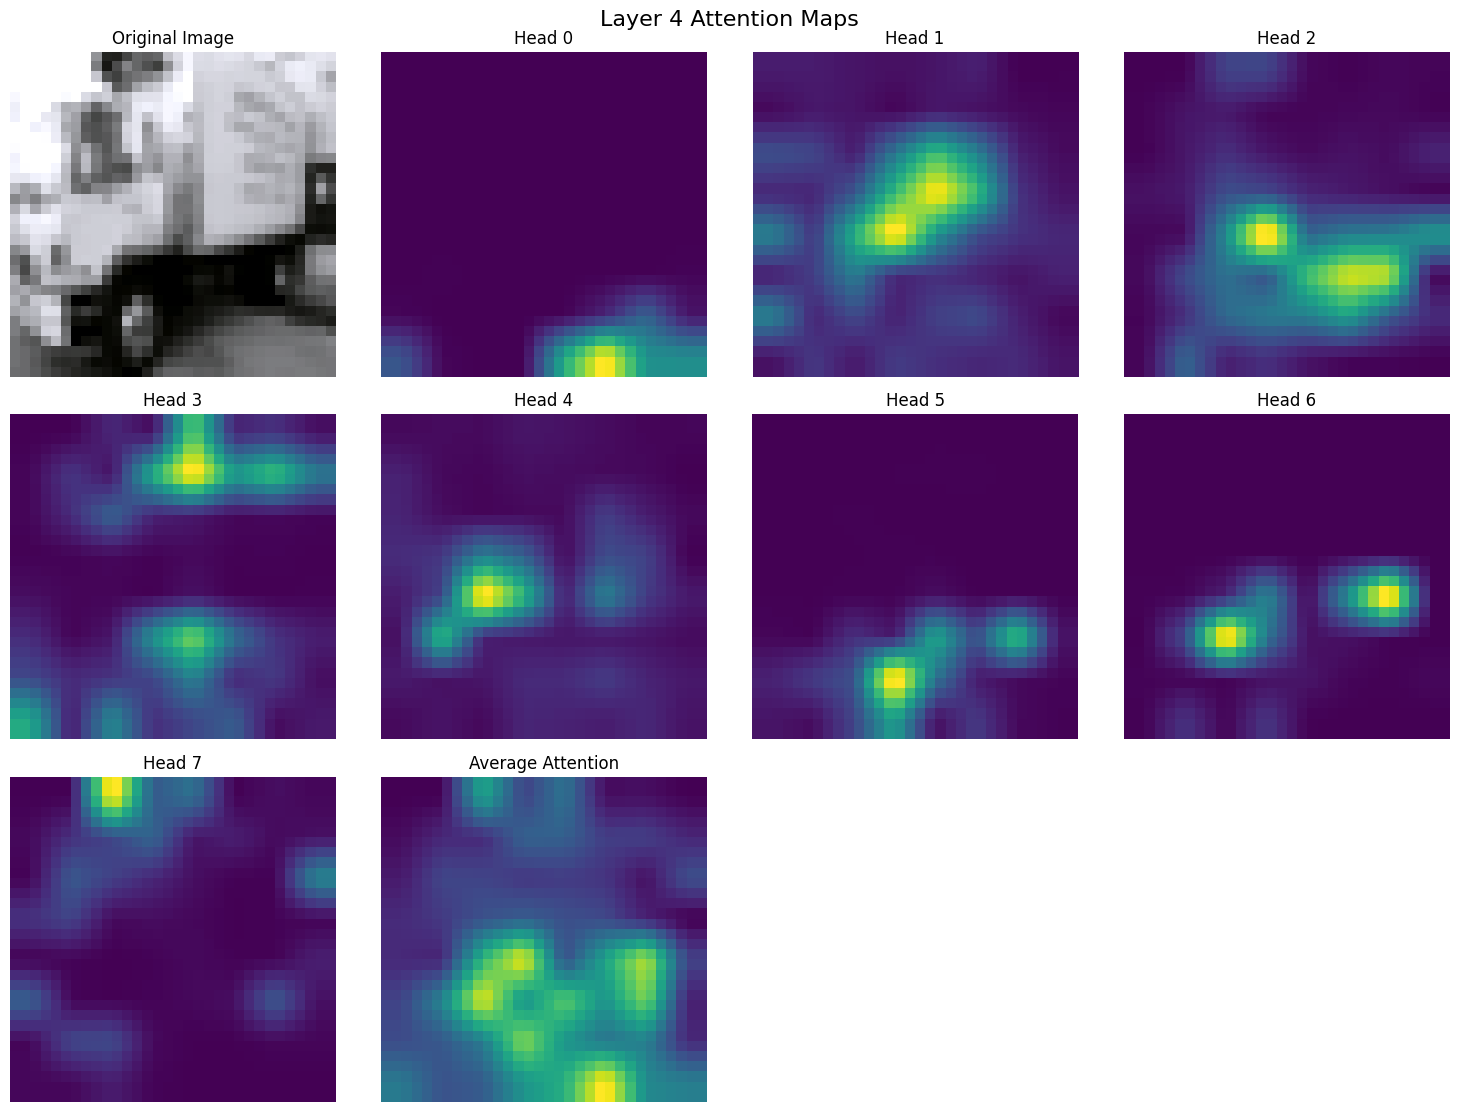

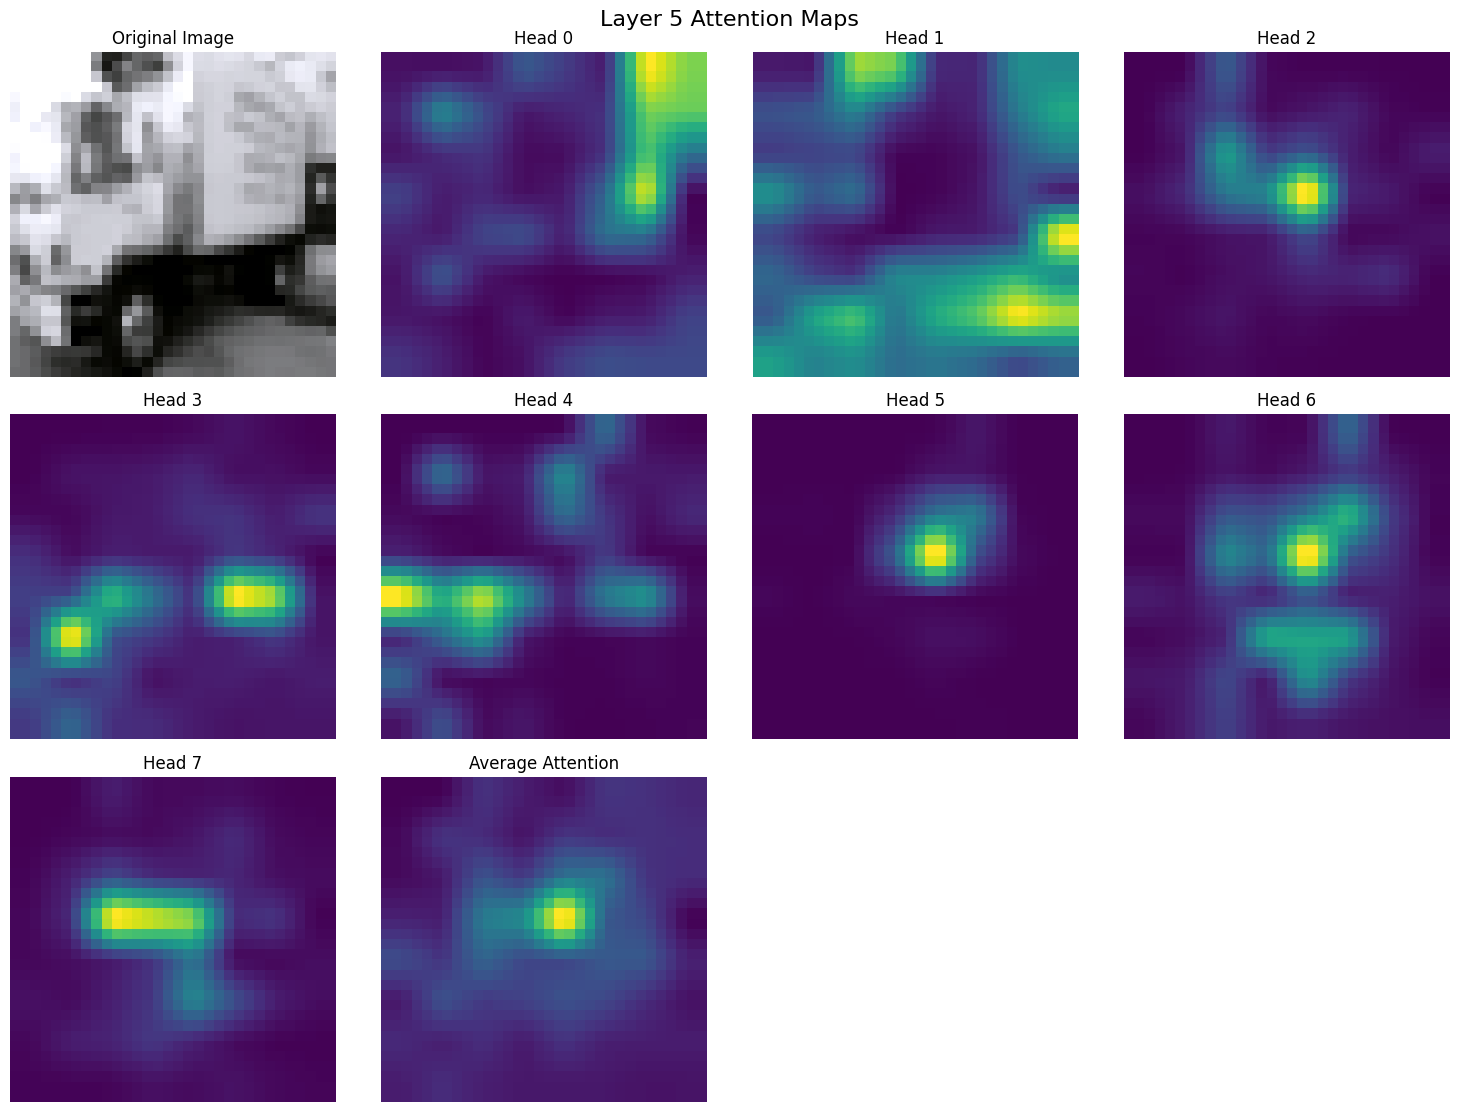

In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
run_visualizations('checkpoints/visual_transformer_best.pth', test_dataset)